In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, Flatten, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data Preparation & Cleaning

In [174]:
files = ['2025-01 - Native Data for Models-January(January 2025).csv', '2025-02 - Native Data for Models-February(1).csv', '2025-03 - Native Data for Models-March(1).csv', '2025-04 - Native Data for Models-April(1).csv']

# List to hold each DataFrame
dfs = []

# Read and store each file
for file in files:
    df = pd.read_csv(file)
    print("Reading ", file)
    df['Source_File'] = file  # Optional: Add column for tracking source file
    dfs.append(df)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Save to a new CSV file
combined_df.to_csv('combined_data.csv', index=False)
combined_df['Source_File'].value_counts()

Reading  2025-01 - Native Data for Models-January(January 2025).csv
Reading  2025-02 - Native Data for Models-February(1).csv
Reading  2025-03 - Native Data for Models-March(1).csv
Reading  2025-04 - Native Data for Models-April(1).csv


Source_File
2025-01 - Native Data for Models-January(January 2025).csv    297739
2025-02 - Native Data for Models-February(1).csv              100001
2025-03 - Native Data for Models-March(1).csv                 100000
2025-04 - Native Data for Models-April(1).csv                 100000
Name: count, dtype: int64

In [175]:
unit_matrix = pd.read_csv('Details-Unit Matrix(Unit Matrix).csv')
unit_type = pd.read_csv('Details-Unit Matrix(Unit Types).csv')

# Merge on different column names
merged_df = pd.merge(unit_matrix, unit_type, left_on='Unit Type', right_on='Unit Name', how='left')

# Optional: Drop the duplicate key column from unit_type
merged_df = merged_df.drop(columns=['Unit Name'])

# Save result
merged_df.to_csv('merged_units.csv', index=False)

merged_df = merged_df.loc[:, ~merged_df.columns.str.startswith('Unnamed')]
merged_df

Location  Unit Number Unit Type    Status  Unit Size (SF)  \
0    Floor 02          202       C3A    Vacant          1191.0   
1    Floor 02          203        A4    Vacant          1061.0   
2    Floor 02          204       A3B    Vacant           587.0   
3    Floor 02          205       A2C    Vacant           589.0   
4    Floor 02          206       A2C    Vacant           589.0   
..        ...          ...       ...       ...             ...   
408  Floor 28         2802       D2A  Occupied          1238.0   
409  Floor 28         2803       D3C  Occupied          2748.0   
410  Floor 28         2804        D1  Occupied           945.0   
411  Floor 28         2805       D1A  Occupied           999.0   
412  Floor 28         2806        D2    Vacant             NaN   

     Unit Size (SM) Unit Type Matrix Unit Class  No. Bedrooms  No. Full Baths  \
0            110.65   Flat 2 x 2 x 0       Flat             2               2   
1             98.57   Flat 1 x 1 x 0       Flat             1               1   
2             54.53   Flat 1 x 1 x 0       Flat             1               1   
3             54.72   Flat 1 x 1 x 0       Flat             1               1   
4             54.72   Flat 1 x 1 x 0       Flat             1               1   
..              ...              ...        ...           ...             ...   
408          115.01   Flat 2 x 2 x 0       Flat             2               2   
409          255.30   Flat 3 x 3 x 1       Flat             3               3   
410           87.79   Flat 1 x 1 x 1       Flat             1               1   
411           92.81   Flat 1 x 1 x 1       Flat             1               1   
412            0.00   Flat 2 x 2 x 0       Flat             2               2   

     No. Half Baths  Stories  Unit Size (Sf)  
0                 0        1            1191  
1                 0        1            1061  
2                 0        1             587  
3                 0        1             589  
4                 0        1             589  
..              ...      ...             ...  
408               0        1            1238  
409               1        1            2748  
410               1        1             945  
411               1        1             999  
412               0        1            1204  

[413 rows x 13 columns]

In [176]:
print(merged_df.isna().sum())
print(combined_df.isna().sum())

Location            0
Unit Number         0
Unit Type           0
Status              0
Unit Size (SF)      1
Unit Size (SM)      0
Unit Type Matrix    0
Unit Class          0
No. Bedrooms        0
No. Full Baths      0
No. Half Baths      0
Stories             0
Unit Size (Sf)      0
dtype: int64
Building Name                0
Unit                         1
Meter #                      1
Time Adjusted by Property    1
Use (gal)                    1
Accu Reading (gal)           1
Water Temp (gal)             1
Signal Strength              1
Battery(Volts)               1
Source_File                  0
dtype: int64


# Joining Flat details with water details

In [177]:
# Perform left join
result_df = pd.merge(combined_df, merged_df, left_on='Unit', right_on='Unit Number', how='left')
result_df = result_df.drop(columns = ['Unit Size (SF)'])
result_df

Building Name    Unit           Meter # Time Adjusted by Property  \
0        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 00:35:56   
1        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 01:35:57   
2        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 02:36:02   
3        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 03:36:07   
4        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 04:36:14   
...              ...     ...               ...                       ...   
613156   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 08:20:47   
613157   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 07:20:42   
613158   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 06:20:37   
613159   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 05:20:33   
613160   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 04:20:27   

       Use (gal) Accu Reading (gal)  Water Temp (gal)  Signal Strength  \
0            0.0             813.65              72.7           -129.0   
1            0.0             813.65              71.9           -101.0   
2            0.0             813.65              71.7           -129.0   
3            0.0             813.65              73.2           -129.0   
4            0.0             813.65              76.5           -129.0   
...          ...                ...               ...              ...   
613156      0.00             919.32              78.5           -104.0   
613157      0.00             919.32              78.6           -114.0   
613158      0.00             919.32              78.6           -109.0   
613159      0.00             919.32              78.7           -107.0   
613160      0.00             919.32              78.6           -106.0   

        Battery(Volts)                                        Source_File  \
0                 3.01  2025-01 - Native Data for Models-January(Janua...   
1                 3.00  2025-01 - Native Data for Models-January(Janua...   
2                 3.01  2025-01 - Native Data for Models-January(Janua...   
3                 3.01  2025-01 - Native Data for Models-January(Janua...   
4                 3.01  2025-01 - Native Data for Models-January(Janua...   
...                ...                                                ...   
613156            2.99      2025-04 - Native Data for Models-April(1).csv   
613157            2.99      2025-04 - Native Data for Models-April(1).csv   
613158            2.99      2025-04 - Native Data for Models-April(1).csv   
613159            2.99      2025-04 - Native Data for Models-April(1).csv   
613160            2.99      2025-04 - Native Data for Models-April(1).csv   

        ... Unit Type  Status Unit Size (SM) Unit Type Matrix  Unit Class  \
0       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
1       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
2       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
3       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
4       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
...     ...       ...     ...            ...              ...         ...   
613156  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
613157  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
613158  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
613159  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
613160  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   

       No. Bedrooms No. Full Baths  No. Half Baths  Stories  Unit Size (Sf)  
0               2.0            2.0             0.0      1.0          1001.0  
1               2.0            2.0             0.0      1.0          1001.0  
2               2.0            2.0             0.0      1.0          1001.0  
3               2.0            2.0         

In [178]:
result_df.isna().sum()

Building Name                   0
Unit                            1
Meter #                         1
Time Adjusted by Property       1
Use (gal)                       1
Accu Reading (gal)              1
Water Temp (gal)                1
Signal Strength                 1
Battery(Volts)                  1
Source_File                     0
Location                     1539
Unit Number                  1539
Unit Type                    1539
Status                       1539
Unit Size (SM)               1539
Unit Type Matrix             1539
Unit Class                   1539
No. Bedrooms                 1539
No. Full Baths               1539
No. Half Baths               1539
Stories                      1539
Unit Size (Sf)               1539
dtype: int64

In [179]:
duplicate_count = result_df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 15444


In [180]:
#Droppin duplicates
final_df = result_df.drop_duplicates()
final_df = final_df.reset_index(drop=True)
count_dupliate = final_df.duplicated().sum()
print(f"Total duplicate rows: {count_dupliate}")
print(final_df.columns)
final_df

Total duplicate rows: 0
Index(['Building Name', 'Unit', 'Meter #', 'Time Adjusted by Property',
       'Use (gal)', 'Accu Reading (gal)', 'Water Temp (gal)',
       'Signal Strength', 'Battery(Volts)', 'Source_File', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)',
       'Unit Type Matrix', 'Unit Class', 'No. Bedrooms', 'No. Full Baths',
       'No. Half Baths', 'Stories', 'Unit Size (Sf)'],
      dtype='object')


Building Name    Unit           Meter # Time Adjusted by Property  \
0        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 00:35:56   
1        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 01:35:57   
2        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 02:36:02   
3        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 03:36:07   
4        Building 01  1001.0  B83B8FFFFE000CB1       01/01/2025 04:36:14   
...              ...     ...               ...                       ...   
597712   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 08:20:47   
597713   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 07:20:42   
597714   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 06:20:37   
597715   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 05:20:33   
597716   Building 01  2806.0  B83B8FFFFE000FDE       04/20/2025 04:20:27   

       Use (gal) Accu Reading (gal)  Water Temp (gal)  Signal Strength  \
0            0.0             813.65              72.7           -129.0   
1            0.0             813.65              71.9           -101.0   
2            0.0             813.65              71.7           -129.0   
3            0.0             813.65              73.2           -129.0   
4            0.0             813.65              76.5           -129.0   
...          ...                ...               ...              ...   
597712      0.00             919.32              78.5           -104.0   
597713      0.00             919.32              78.6           -114.0   
597714      0.00             919.32              78.6           -109.0   
597715      0.00             919.32              78.7           -107.0   
597716      0.00             919.32              78.6           -106.0   

        Battery(Volts)                                        Source_File  \
0                 3.01  2025-01 - Native Data for Models-January(Janua...   
1                 3.00  2025-01 - Native Data for Models-January(Janua...   
2                 3.01  2025-01 - Native Data for Models-January(Janua...   
3                 3.01  2025-01 - Native Data for Models-January(Janua...   
4                 3.01  2025-01 - Native Data for Models-January(Janua...   
...                ...                                                ...   
597712            2.99      2025-04 - Native Data for Models-April(1).csv   
597713            2.99      2025-04 - Native Data for Models-April(1).csv   
597714            2.99      2025-04 - Native Data for Models-April(1).csv   
597715            2.99      2025-04 - Native Data for Models-April(1).csv   
597716            2.99      2025-04 - Native Data for Models-April(1).csv   

        ... Unit Type  Status Unit Size (SM) Unit Type Matrix  Unit Class  \
0       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
1       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
2       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
3       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
4       ...        B4  Vacant           93.0   Flat 2 x 2 x 0        Flat   
...     ...       ...     ...            ...              ...         ...   
597712  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
597713  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
597714  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
597715  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   
597716  ...        D2  Vacant            0.0   Flat 2 x 2 x 0        Flat   

       No. Bedrooms No. Full Baths  No. Half Baths  Stories  Unit Size (Sf)  
0               2.0            2.0             0.0      1.0          1001.0  
1               2.0            2.0             0.0      1.0          1001.0  
2               2.0            2.0             0.0      1.0          1001.0  
3               2.0            2.0         

In [181]:
final_df.to_csv('final_data.csv', index=False)
df = pd.read_csv('final_data.csv')
df = df.dropna()
df.shape

(596178, 22)

In [182]:
def date_time_conversion(df):


    # # Robust datetime conversion
    # df = robust_datetime_conversion(df)

    # Convert to datetime
    df['Time Adjusted by Property'] = pd.to_datetime(df['Time Adjusted by Property'])

    # Create time-based features
    df['Date'] = df['Time Adjusted by Property'].dt.date
    df['Hour'] = df['Time Adjusted by Property'].dt.hour
    df['DayOfWeek'] = df['Time Adjusted by Property'].dt.dayofweek
    df['Month'] = df['Time Adjusted by Property'].dt.month
    return df

df1=date_time_conversion(df)

In [183]:
df1.dtypes

Building Name                        object
Unit                                float64
Meter #                              object
Time Adjusted by Property    datetime64[ns]
Use (gal)                            object
Accu Reading (gal)                   object
Water Temp (gal)                    float64
Signal Strength                     float64
Battery(Volts)                      float64
Source_File                          object
Location                             object
Unit Number                         float64
Unit Type                            object
Status                               object
Unit Size (SM)                      float64
Unit Type Matrix                     object
Unit Class                           object
No. Bedrooms                        float64
No. Full Baths                      float64
No. Half Baths                      float64
Stories                             float64
Unit Size (Sf)                      float64
Date                            

In [184]:
df1

Building Name    Unit           Meter # Time Adjusted by Property  \
0        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 00:35:56   
1        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 01:35:57   
2        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 02:36:02   
3        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 03:36:07   
4        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 04:36:14   
...              ...     ...               ...                       ...   
597712   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 08:20:47   
597713   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 07:20:42   
597714   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 06:20:37   
597715   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 05:20:33   
597716   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 04:20:27   

       Use (gal) Accu Reading (gal)  Water Temp (gal)  Signal Strength  \
0            0.0             813.65              72.7           -129.0   
1            0.0             813.65              71.9           -101.0   
2            0.0             813.65              71.7           -129.0   
3            0.0             813.65              73.2           -129.0   
4            0.0             813.65              76.5           -129.0   
...          ...                ...               ...              ...   
597712       0.0             919.32              78.5           -104.0   
597713       0.0             919.32              78.6           -114.0   
597714       0.0             919.32              78.6           -109.0   
597715       0.0             919.32              78.7           -107.0   
597716       0.0             919.32              78.6           -106.0   

        Battery(Volts)                                        Source_File  \
0                 3.01  2025-01 - Native Data for Models-January(Janua...   
1                 3.00  2025-01 - Native Data for Models-January(Janua...   
2                 3.01  2025-01 - Native Data for Models-January(Janua...   
3                 3.01  2025-01 - Native Data for Models-January(Janua...   
4                 3.01  2025-01 - Native Data for Models-January(Janua...   
...                ...                                                ...   
597712            2.99      2025-04 - Native Data for Models-April(1).csv   
597713            2.99      2025-04 - Native Data for Models-April(1).csv   
597714            2.99      2025-04 - Native Data for Models-April(1).csv   
597715            2.99      2025-04 - Native Data for Models-April(1).csv   
597716            2.99      2025-04 - Native Data for Models-April(1).csv   

        ... Unit Class  No. Bedrooms No. Full Baths No. Half Baths  Stories  \
0       ...       Flat           2.0            2.0            0.0      1.0   
1       ...       Flat           2.0            2.0            0.0      1.0   
2       ...       Flat           2.0            2.0            0.0      1.0   
3       ...       Flat           2.0            2.0            0.0      1.0   
4       ...       Flat           2.0            2.0            0.0      1.0   
...     ...        ...           ...            ...            ...      ...   
597712  ...       Flat           2.0            2.0            0.0      1.0   
597713  ...       Flat           2.0            2.0            0.0      1.0   
597714  ...       Flat           2.0            2.0            0.0      1.0   
597715  ...       Flat           2.0            2.0            0.0      1.0   
597716  ...       Flat           2.0            2.0            0.0      1.0   

       Unit Size (Sf)        Date  Hour  DayOfWeek  Month  
0              1001.0  2025-01-01     0          2      1  
1              1001.0  2025-01-01     1          2      1  
2              1001.0  2025-01-01     2          2      1  
3              1001.0  2025-01-01     3          2      1  
4              1001.0  2025-01-

In [185]:
df1 = df1.astype({
    'Building Name': 'string',
    'Meter #': 'string',
    'Source_File': 'string',
    'Location': 'string',
    'Unit Type': 'string',
    'Status': 'string',
    'Unit Type Matrix': 'string',
    'Unit Class': 'string'
})


# Step 4: Convert numeric columns safely
numeric_columns = {
    'Water Temp (gal)': 'float',
    'Battery(Volts)': 'float',
    'Signal Strength': 'Int64',  # nullable integer
    'Unit Size (SM)': 'float',
    'No. Bedrooms': 'Int64',
    'No. Full Baths': 'Int64',
    'No. Half Baths': 'Int64',
    'Stories': 'Int64',
    'Unit Size (Sf)': 'Int64'   # appears to be a duplicate or alternate spelling
}

for col, dtype in numeric_columns.items():
    df1[col] = pd.to_numeric(df1[col], errors='coerce').astype(dtype)

In [186]:
def safe_str_to_float(val):
    if pd.isna(val):
        return val  # keep NaNs as is
    try:
        # Remove commas if present, then convert to float
        return float(str(val).replace(',', ''))
    except ValueError:
        # If conversion fails, keep original value (or np.nan if you prefer)
        return val

df1['Accu Reading (gal)'] = df1['Accu Reading (gal)'].apply(safe_str_to_float)
df1['Use (gal)'] = df1['Use (gal)'].apply(safe_str_to_float)

In [187]:
print(df1.dtypes)
df1

Building Name                string[python]
Unit                                float64
Meter #                      string[python]
Time Adjusted by Property    datetime64[ns]
Use (gal)                           float64
Accu Reading (gal)                  float64
Water Temp (gal)                    float64
Signal Strength                       Int64
Battery(Volts)                      float64
Source_File                  string[python]
Location                     string[python]
Unit Number                         float64
Unit Type                    string[python]
Status                       string[python]
Unit Size (SM)                      float64
Unit Type Matrix             string[python]
Unit Class                   string[python]
No. Bedrooms                          Int64
No. Full Baths                        Int64
No. Half Baths                        Int64
Stories                               Int64
Unit Size (Sf)                        Int64
Date                            

Building Name    Unit           Meter # Time Adjusted by Property  \
0        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 00:35:56   
1        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 01:35:57   
2        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 02:36:02   
3        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 03:36:07   
4        Building 01  1001.0  B83B8FFFFE000CB1       2025-01-01 04:36:14   
...              ...     ...               ...                       ...   
597712   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 08:20:47   
597713   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 07:20:42   
597714   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 06:20:37   
597715   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 05:20:33   
597716   Building 01  2806.0  B83B8FFFFE000FDE       2025-04-20 04:20:27   

        Use (gal)  Accu Reading (gal)  Water Temp (gal)  Signal Strength  \
0             0.0              813.65              72.7             -129   
1             0.0              813.65              71.9             -101   
2             0.0              813.65              71.7             -129   
3             0.0              813.65              73.2             -129   
4             0.0              813.65              76.5             -129   
...           ...                 ...               ...              ...   
597712        0.0              919.32              78.5             -104   
597713        0.0              919.32              78.6             -114   
597714        0.0              919.32              78.6             -109   
597715        0.0              919.32              78.7             -107   
597716        0.0              919.32              78.6             -106   

        Battery(Volts)                                        Source_File  \
0                 3.01  2025-01 - Native Data for Models-January(Janua...   
1                 3.00  2025-01 - Native Data for Models-January(Janua...   
2                 3.01  2025-01 - Native Data for Models-January(Janua...   
3                 3.01  2025-01 - Native Data for Models-January(Janua...   
4                 3.01  2025-01 - Native Data for Models-January(Janua...   
...                ...                                                ...   
597712            2.99      2025-04 - Native Data for Models-April(1).csv   
597713            2.99      2025-04 - Native Data for Models-April(1).csv   
597714            2.99      2025-04 - Native Data for Models-April(1).csv   
597715            2.99      2025-04 - Native Data for Models-April(1).csv   
597716            2.99      2025-04 - Native Data for Models-April(1).csv   

        ... Unit Class  No. Bedrooms No. Full Baths No. Half Baths  Stories  \
0       ...       Flat             2              2              0        1   
1       ...       Flat             2              2              0        1   
2       ...       Flat             2              2              0        1   
3       ...       Flat             2              2              0        1   
4       ...       Flat             2              2              0        1   
...     ...        ...           ...            ...            ...      ...   
597712  ...       Flat             2              2              0        1   
597713  ...       Flat             2              2              0        1   
597714  ...       Flat             2              2              0        1   
597715  ...       Flat             2              2              0        1   
597716  ...       Flat             2              2              0        1   

       Unit Size (Sf)        Date  Hour  DayOfWeek  Month  
0                1001  2025-01-01     0          2      1  
1                1001  2025-01-01     1          2      1  
2                1001  2025-01-01     2          2      1  
3                1001  2025-01-01     3          2      1  
4      

In [188]:
df1.isna().sum()

Building Name                0
Unit                         0
Meter #                      0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Battery(Volts)               0
Source_File                  0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
Unit Type Matrix             0
Unit Class                   0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Stories                      0
Unit Size (Sf)               0
Date                         0
Hour                         0
DayOfWeek                    0
Month                        0
dtype: int64

# EDA

In [189]:
description = df1.describe(percentiles=[.05,.25,.5,.75, .95])
description = description.transpose()

# Display the results
description

count                           mean  \
Unit                       596178.0                    1489.684717   
Time Adjusted by Property    596178  2025-02-19 23:08:12.674709248   
Use (gal)                  596178.0                       1.255405   
Accu Reading (gal)         596178.0                    5606.827435   
Water Temp (gal)           596178.0                      71.599241   
Signal Strength            596178.0                     -92.262234   
Battery(Volts)             596178.0                       3.016642   
Unit Number                596178.0                    1489.684717   
Unit Size (SM)             596178.0                      89.254144   
No. Bedrooms               596178.0                       1.593524   
No. Full Baths             596178.0                       1.499368   
No. Half Baths             596178.0                       0.048856   
Stories                    596178.0                            1.0   
Unit Size (Sf)             596178.0                      963.84018   
Hour                       596178.0                      11.569664   
DayOfWeek                  596178.0                       2.960617   
Month                      596178.0                       2.003769   

                                           min                          5%  \
Unit                                     202.0                       306.0   
Time Adjusted by Property  2025-01-01 00:00:04  2025-01-04 02:23:32.400000   
Use (gal)                                  0.0                         0.0   
Accu Reading (gal)                        2.64                       79.25   
Water Temp (gal)                          44.6                        64.0   
Signal Strength                         -256.0                      -129.0   
Battery(Volts)                            2.59                        2.98   
Unit Number                              202.0                       306.0   
Unit Size (SM)                             0.0                       58.06   
No. Bedrooms                               1.0                         1.0   
No. Full Baths                             1.0                         1.0   
No. Half Baths                             0.0                         0.0   
Stories                                    1.0                         1.0   
Unit Size (Sf)                           480.0                       625.0   
Hour                                       0.0                         1.0   
DayOfWeek                                  0.0                         0.0   
Month                                      1.0                         1.0   

                                                     25%  \
Unit                                               918.0   
Time Adjusted by Property  2025-01-16 10:54:22.750000128   
Use (gal)                                            0.0   
Accu Reading (gal)                                501.93   
Water Temp (gal)                                    68.7   
Signal Strength                                   -108.0   
Battery(Volts)                                       3.0   
Unit Number                                        918.0   
Unit Size (SM)                                     58.71   
No. Bedrooms                                         1.0   
No. Full Baths                                       1.0   
No. Half Baths                                       0.0   
Stories                                              1.0   
Unit Size (Sf)                                     632.0   
Hour                                                 6.0   
DayOfWeek                                            1.0   
Month                                                1.0   

                                                  50%  \
Unit                                           1507.0   
Time Adjusted by Property  2025-02-18 05:48:48.500000   
Use (gal)                                         0.0   
Accu Reading (gal)                            3505.56  

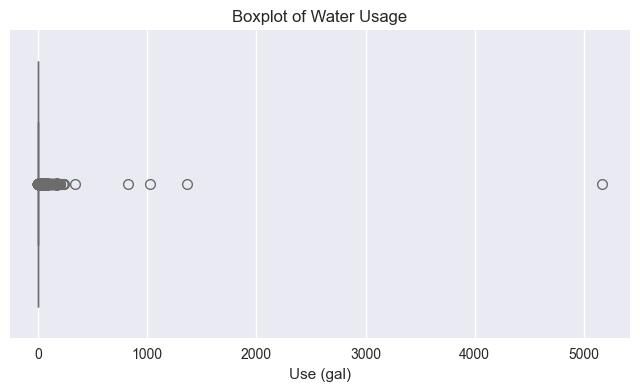

In [190]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df1['Use (gal)'])
plt.title("Boxplot of Water Usage")
plt.xlabel("Use (gal)")
plt.show()

In [191]:
Q1 = df1['Use (gal)'].quantile(0.25)
Q3 = df1['Use (gal)'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_cleaned = df1[(df1['Use (gal)'] >= lower_bound) & (df1['Use (gal)'] <= upper_bound)]

print(f"Original rows: {len(df1)}, After removing outliers: {len(df_cleaned)},outlier% = {(len(df1)-len(df_cleaned))/len(df1)*100}")


Original rows: 596178, After removing outliers: 510807,outlier% = 14.319716594708293


In [192]:
print(df1['Use (gal)'].value_counts().sort_index(ascending=False).head(20))

Use (gal)
5164.56     1
1365.77     1
1024.99     1
821.57      1
340.78      1
240.40      1
229.83      1
224.55      1
198.13      4
195.49      1
192.85      1
190.20      2
187.56      1
184.92      3
182.28      5
179.64      7
177.00      4
174.35     14
171.71     29
169.07     31
Name: count, dtype: int64


In [193]:
df1[df1['Use (gal)']>300]

Building Name    Unit           Meter # Time Adjusted by Property  \
48912    Building 01  1312.0  B83B8FFFFE000B21       2025-01-25 03:00:25   
72269    Building 01  1507.0  B83B8FFFFE00127D       2025-01-30 15:14:11   
201063   Building 01  2404.0  B83B8FFFFE0012D5       2025-01-13 08:10:23   
534013   Building 01  1802.0  01030000010395F8       2025-04-26 23:02:41   
566933   Building 01  2410.0  B83B8FFFFE000FA0       2025-04-23 12:52:44   

        Use (gal)  Accu Reading (gal)  Water Temp (gal)  Signal Strength  \
48912      821.57             2821.36              71.1              -40   
72269     1024.99             5500.06              72.8              -54   
201063    1365.77            11858.68              78.4             -129   
534013     340.78            18204.09              70.5              -95   
566933    5164.56             9914.38              78.9              -94   

        Battery(Volts)                                        Source_File  \
48912             3.00  2025-01 - Native Data for Models-January(Janua...   
72269             3.02  2025-01 - Native Data for Models-January(Janua...   
201063            3.02  2025-01 - Native Data for Models-January(Janua...   
534013            3.00      2025-04 - Native Data for Models-April(1).csv   
566933            3.00      2025-04 - Native Data for Models-April(1).csv   

        ... Unit Class  No. Bedrooms No. Full Baths No. Half Baths  Stories  \
48912   ...       Flat             2              2              0        1   
72269   ...       Flat             1              1              0        1   
201063  ...       Flat             2              2              0        1   
534013  ...       Flat             3              2              0        1   
566933  ...       Flat             2              2              0        1   

       Unit Size (Sf)        Date  Hour  DayOfWeek  Month  
48912            1165  2025-01-25     3          5      1  
72269             632  2025-01-30    15          3      1  
201063           1204  2025-01-13     8          0      1  
534013           1375  2025-04-26    23          5      4  
566933           1295  2025-04-23    12          2      4  

[5 rows x 26 columns]

# Removing very extreme val ie >300 (only 5)

In [194]:
df1=df1[df1['Use (gal)']<300]

df1.dtypes

Building Name                string[python]
Unit                                float64
Meter #                      string[python]
Time Adjusted by Property    datetime64[ns]
Use (gal)                           float64
Accu Reading (gal)                  float64
Water Temp (gal)                    float64
Signal Strength                       Int64
Battery(Volts)                      float64
Source_File                  string[python]
Location                     string[python]
Unit Number                         float64
Unit Type                    string[python]
Status                       string[python]
Unit Size (SM)                      float64
Unit Type Matrix             string[python]
Unit Class                   string[python]
No. Bedrooms                          Int64
No. Full Baths                        Int64
No. Half Baths                        Int64
Stories                               Int64
Unit Size (Sf)                        Int64
Date                            

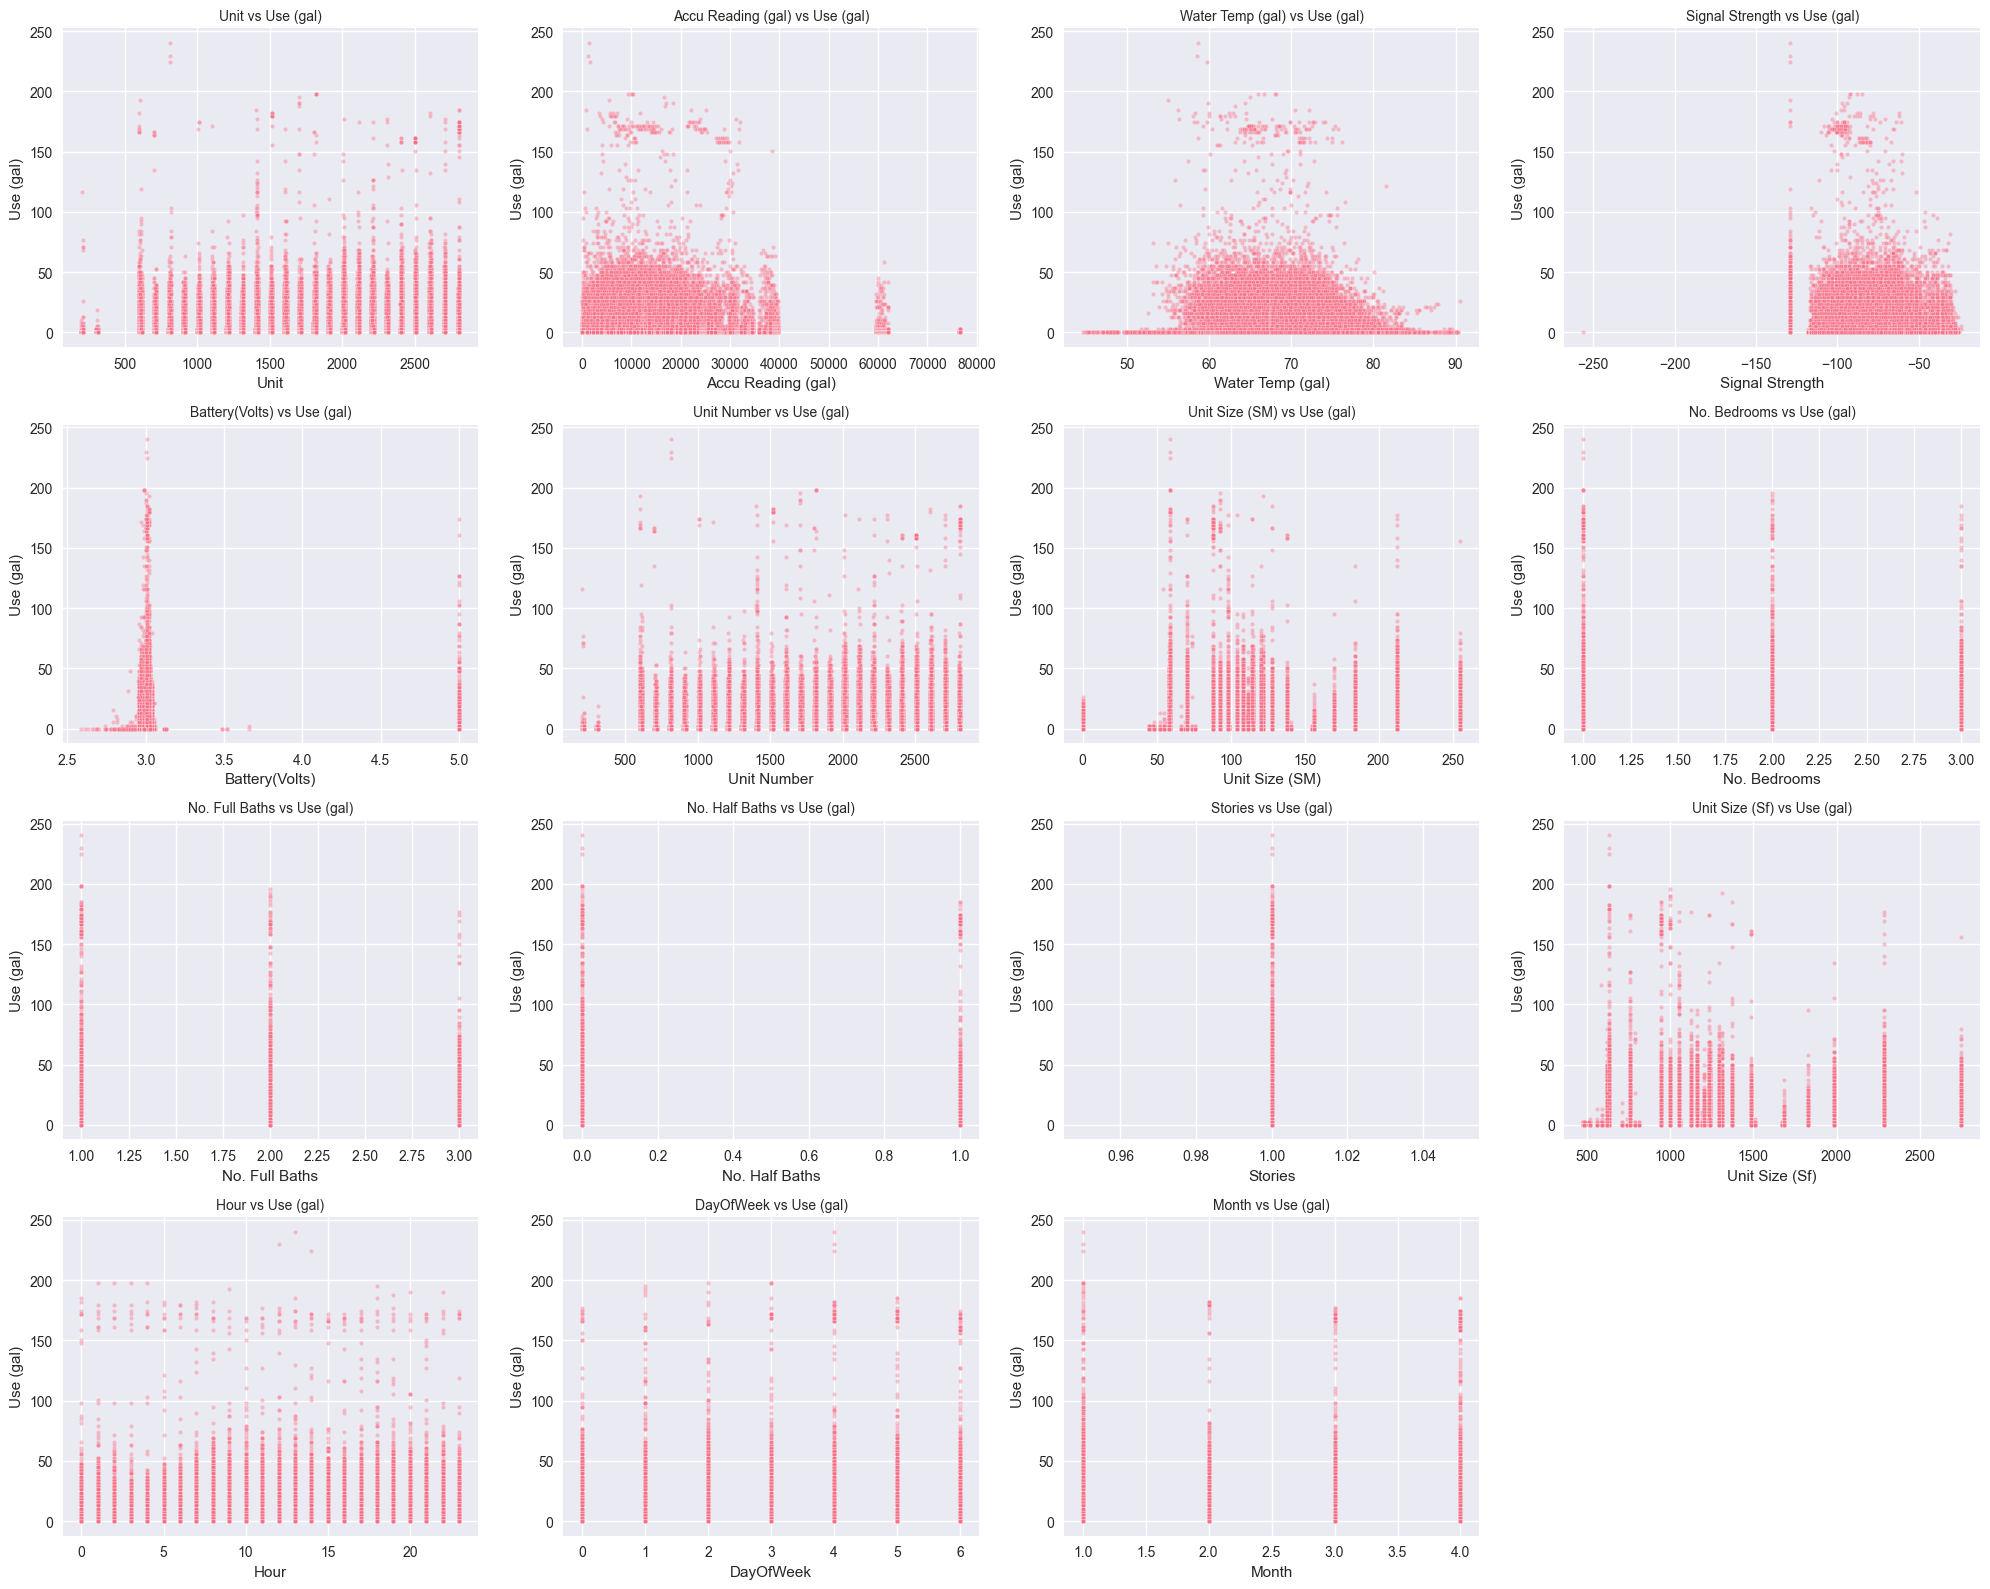

In [195]:

target = 'Use (gal)'

# Select all numeric columns excluding the target
numeric_cols = df1.select_dtypes(include=['float64', 'int64', 'Int64', 'float32', 'int32']).columns
numeric_cols = [col for col in numeric_cols if col != target]

# Set up the 4x4 plot grid
num_plots = len(numeric_cols)
cols = 4
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    sns.scatterplot(x=df1[col], y=df1[target], alpha=0.4, s=10)
    plt.title(f'{col} vs {target}', fontsize=10)
    plt.xlabel(col)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

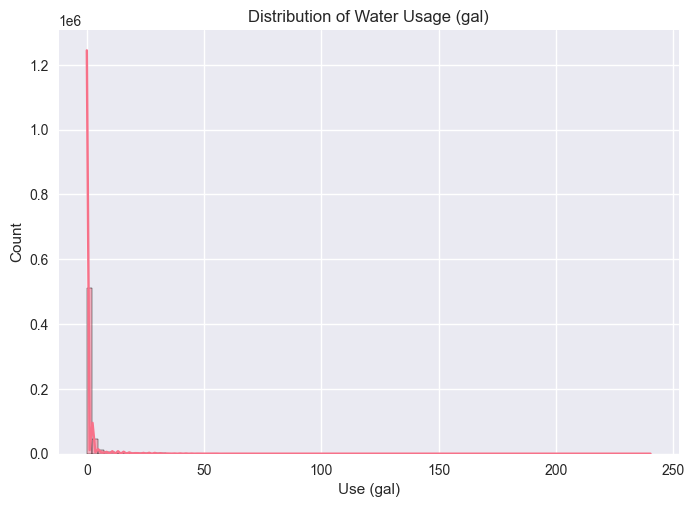

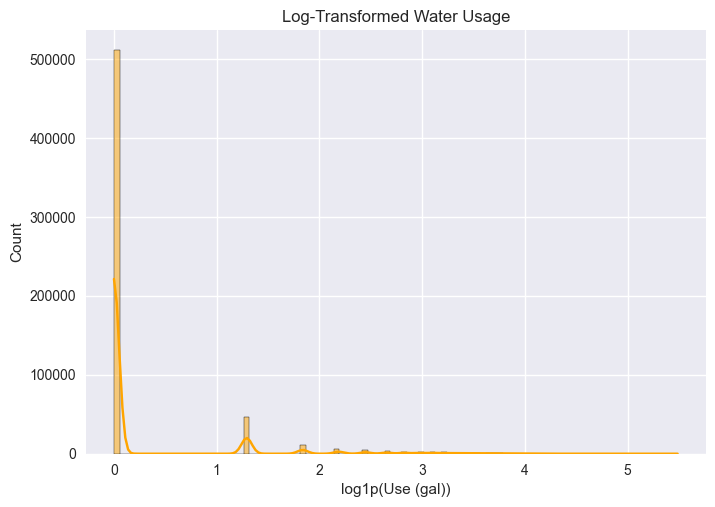

In [196]:
sns.histplot(df1['Use (gal)'], bins=100, kde=True)
plt.title('Distribution of Water Usage (gal)')
plt.xlabel('Use (gal)')
plt.show()

# Try log1p to see the transformed distribution
sns.histplot(np.log1p(df1['Use (gal)']), bins=100, kde=True, color='orange')
plt.title('Log-Transformed Water Usage')
plt.xlabel('log1p(Use (gal))')
plt.show()


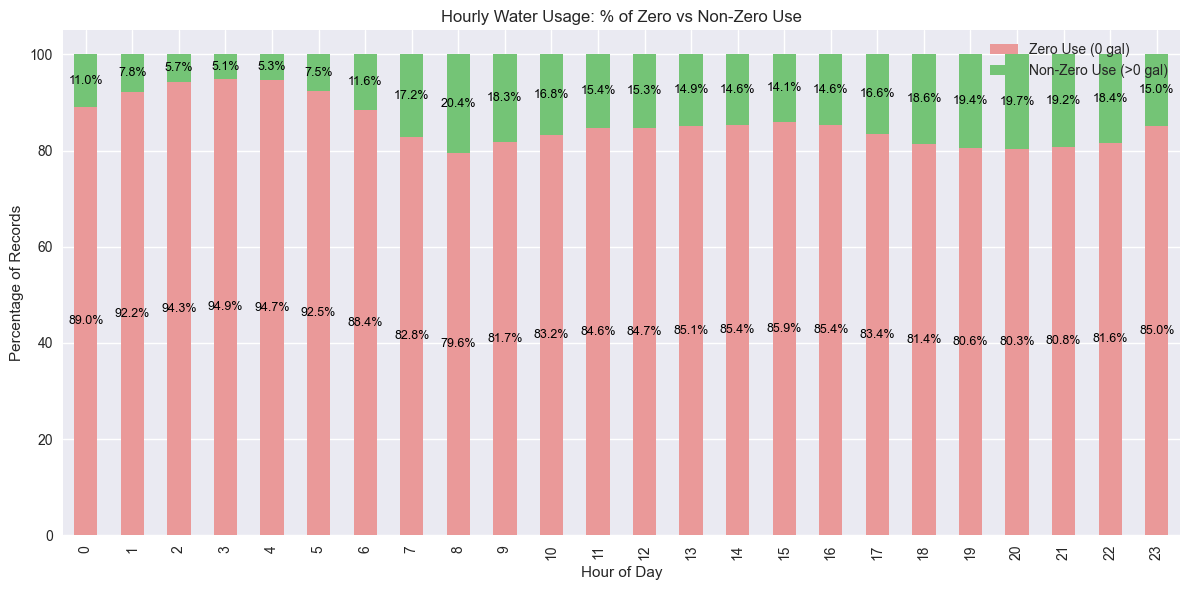

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a flag column for zero and non-zero usage
df1['Usage_Flag'] = df1['Use (gal)'].apply(lambda x: 1 if x > 0 else 0)

# 2. Group by Hour and flag to get counts
usage_counts = df1.groupby(['Hour', 'Usage_Flag']).size().unstack(fill_value=0)

# 3. Calculate percentages
usage_percent = usage_counts.div(usage_counts.sum(axis=1), axis=0) * 100

# 4. Plot stacked percentage bar chart
ax = usage_percent.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#ea9999', '#74c476'])

plt.title("Hourly Water Usage: % of Zero vs Non-Zero Use")
plt.xlabel("Hour of Day")
plt.ylabel("Percentage of Records")
plt.legend(['Zero Use (0 gal)', 'Non-Zero Use (>0 gal)'], loc='upper right')

# 5. Add percentage labels on each bar segment
for i, row in usage_percent.iterrows():
    zero_pct = row[0]
    non_zero_pct = row[1]
    ax.text(i, zero_pct / 2, f'{zero_pct:.1f}%', ha='center', va='center', color='black', fontsize=9)
    ax.text(i, zero_pct + non_zero_pct / 2, f'{non_zero_pct:.1f}%', ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()


In [198]:
df1.drop(columns='Usage_Flag', inplace=True)

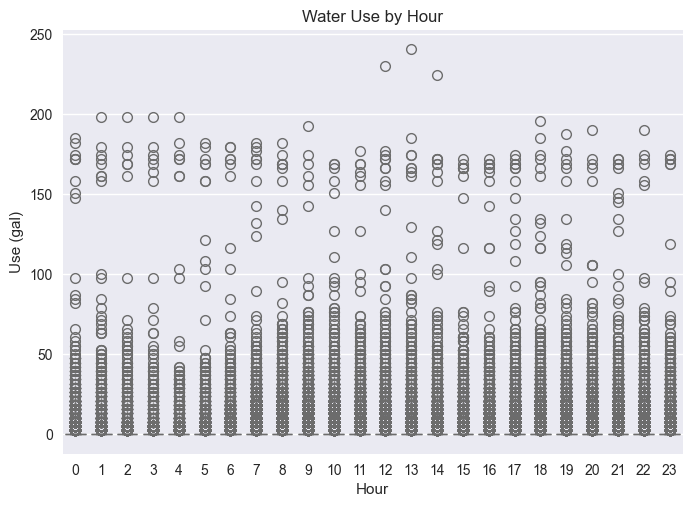

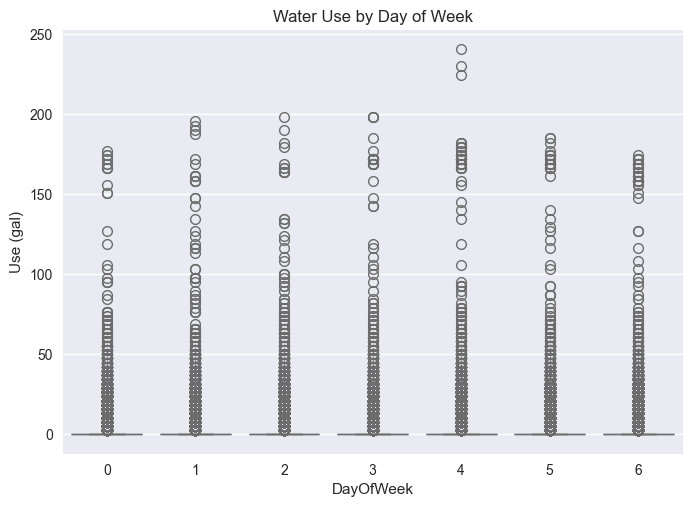

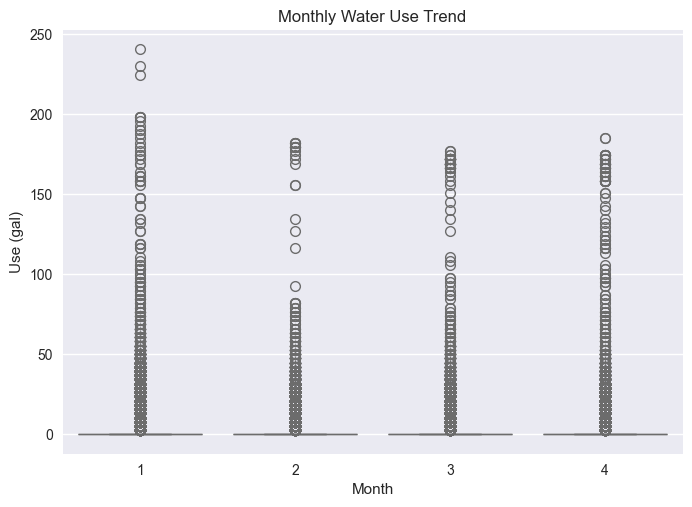

In [199]:
# Hourly usage
sns.boxplot(x='Hour', y='Use (gal)', data=df1)
plt.title("Water Use by Hour")
plt.show()

# Day of week
sns.boxplot(x='DayOfWeek', y='Use (gal)', data=df1)
plt.title("Water Use by Day of Week")
plt.show()

# Monthly trend
sns.boxplot(x='Month', y='Use (gal)', data=df1)
plt.title("Monthly Water Use Trend")
plt.show()


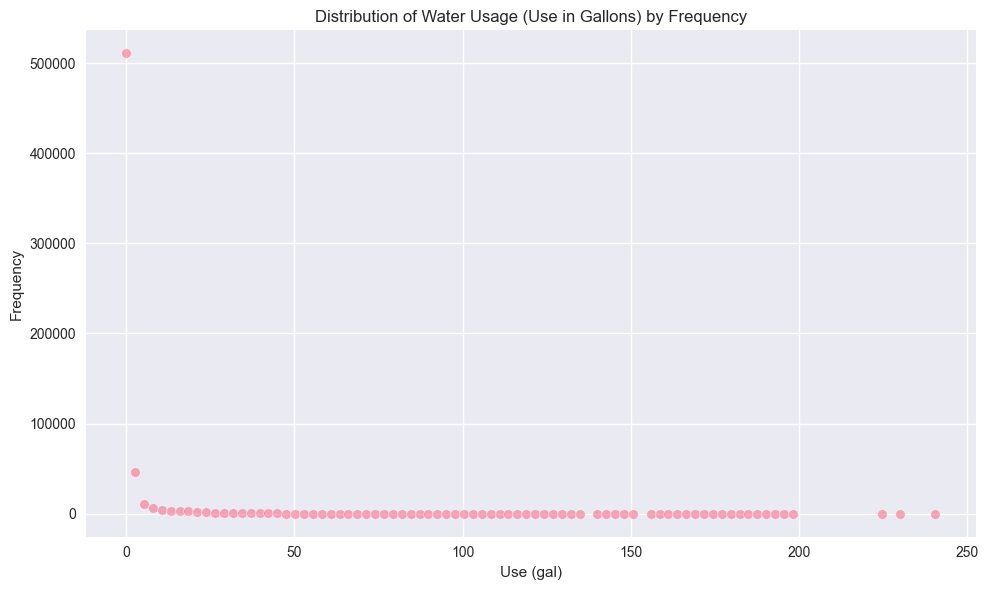

In [200]:
# Step 1: Group by 'Use (gal)' to get frequency
use_freq = df1['Use (gal)'].value_counts().reset_index()
use_freq.columns = ['Use (gal)', 'Frequency']

# Step 2: Sort by Use (gal) for better visual
use_freq = use_freq.sort_values('Use (gal)')

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=use_freq, x='Use (gal)', y='Frequency', alpha=0.6)
plt.title('Distribution of Water Usage (Use in Gallons) by Frequency')
plt.xlabel('Use (gal)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


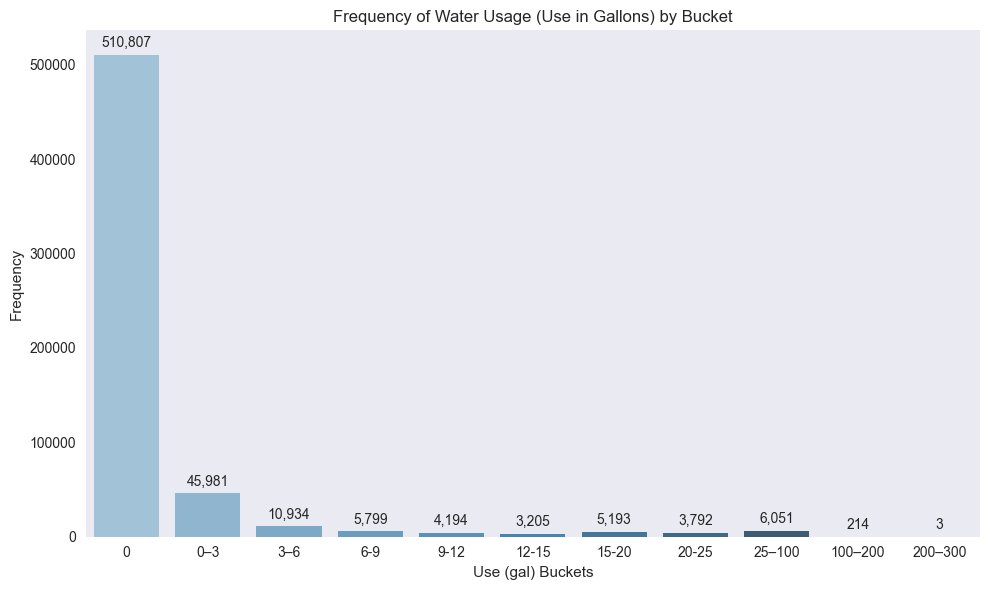

In [201]:
# Define bins and labels
bins = [-0.1, 0, 3, 6, 9,  12, 15, 20, 25, 100, 200, 300]
labels = ['0', '0–3', '3–6', '6-9','9-12', '12-15','15-20','20-25','25–100', '100–200', '200–300']

# Create bucket column
df1['use_bucket'] = pd.cut(df1['Use (gal)'], bins=bins, labels=labels)

# Count frequency in each bucket
bucket_counts = df1['use_bucket'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette='Blues_d')

# Add count labels on top of each bar
for i, value in enumerate(bucket_counts.values):
    ax.text(i, value + 0.01 * max(bucket_counts.values), f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.title('Frequency of Water Usage (Use in Gallons) by Bucket')
plt.xlabel('Use (gal) Buckets')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [202]:
def plot_bar_with_labels(df, group_col, value_col='Use (gal)', agg='mean', title=None, figsize=(10, 6)):
    """
    Creates a bar plot for the specified grouping column with value labels.

    Parameters:
    - df: DataFrame
    - group_col: Column to group by
    - value_col: Column to aggregate
    - agg: Aggregation method - 'sum' or 'mean' or 'count'
    - title: Optional plot title
    - figsize: Tuple for figure size
    """
    # Aggregate
    if agg == 'sum':
        grouped = df.groupby(group_col)[value_col].sum()
    elif agg == 'mean':
        grouped = df.groupby(group_col)[value_col].mean()
    elif agg == 'count':
        grouped = df[group_col].value_counts()
    else:
        raise ValueError("Aggregation must be 'sum', 'mean', or 'count'")

    grouped = grouped.sort_index()

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=grouped.index.astype(str), y=grouped.values, palette='coolwarm')
    plt.title(title or f'{agg.capitalize()} of {value_col} by {group_col}')
    plt.xlabel(group_col)
    plt.ylabel(f'{agg.capitalize()} of {value_col}')
    plt.xticks(rotation=45)

    # Add value labels
    for i, v in enumerate(grouped.values):
        ax.text(i, v + 0.01 * max(grouped.values), f'{v:,.2f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

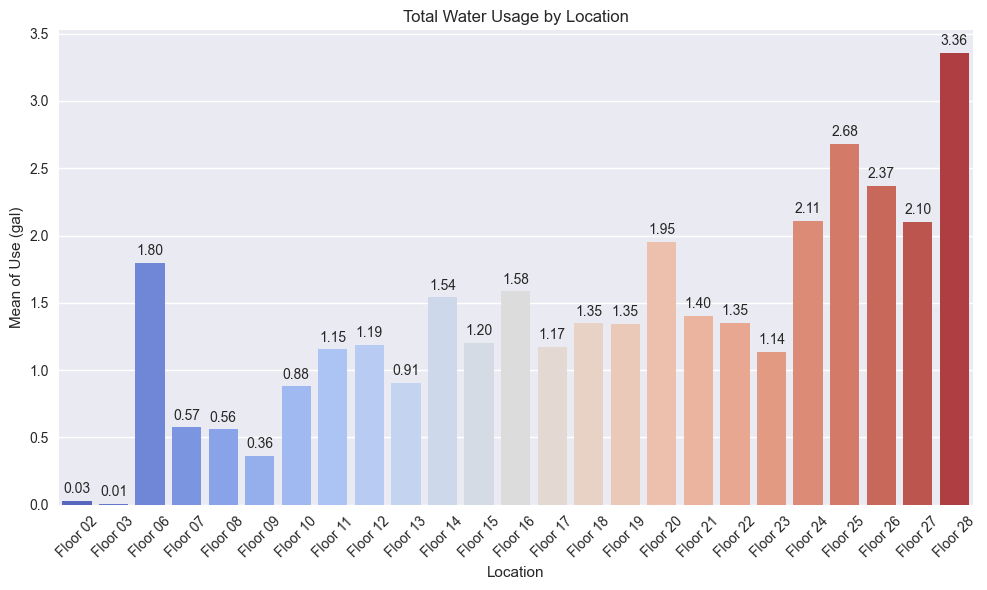

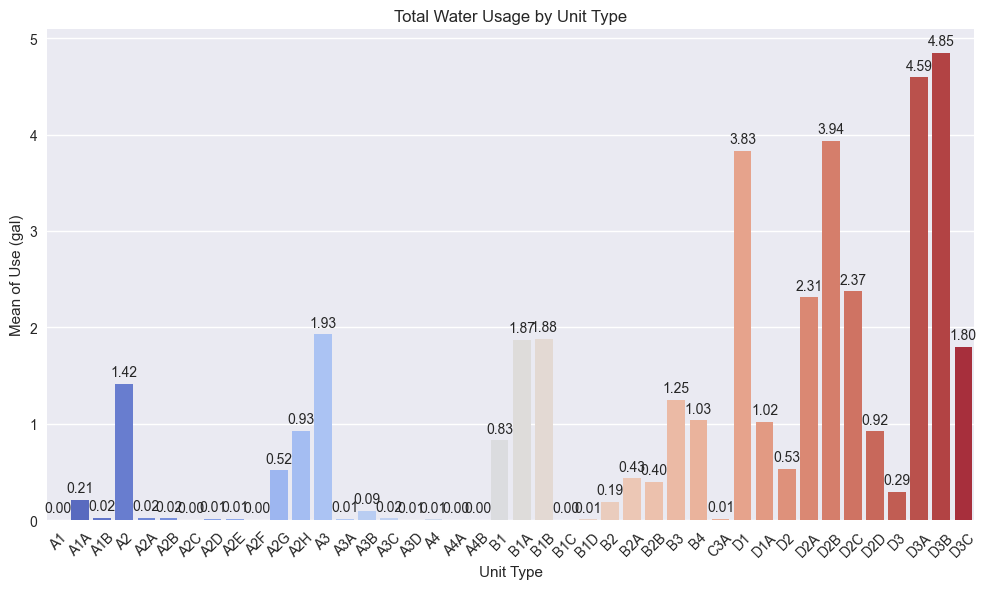

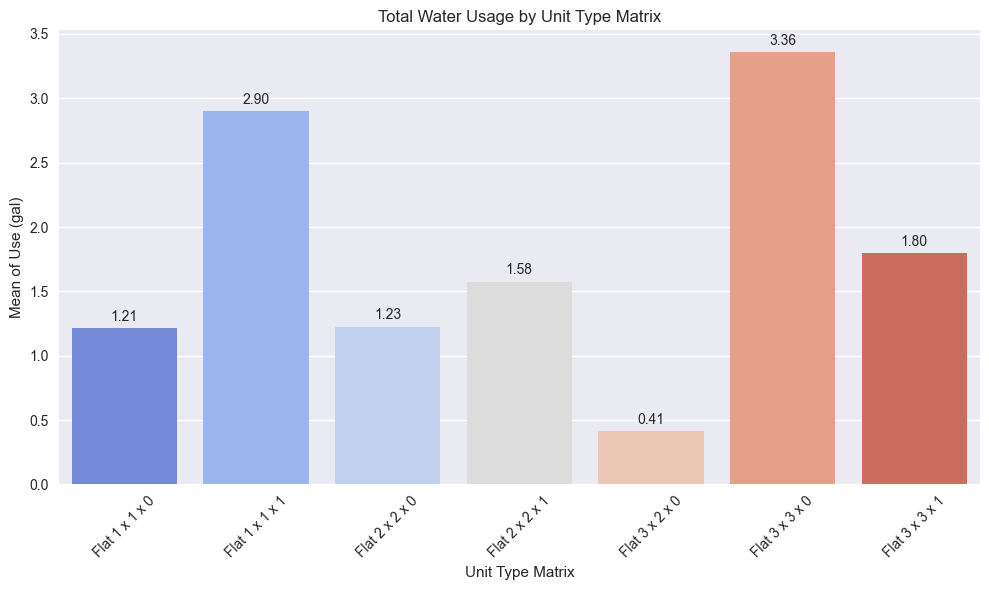

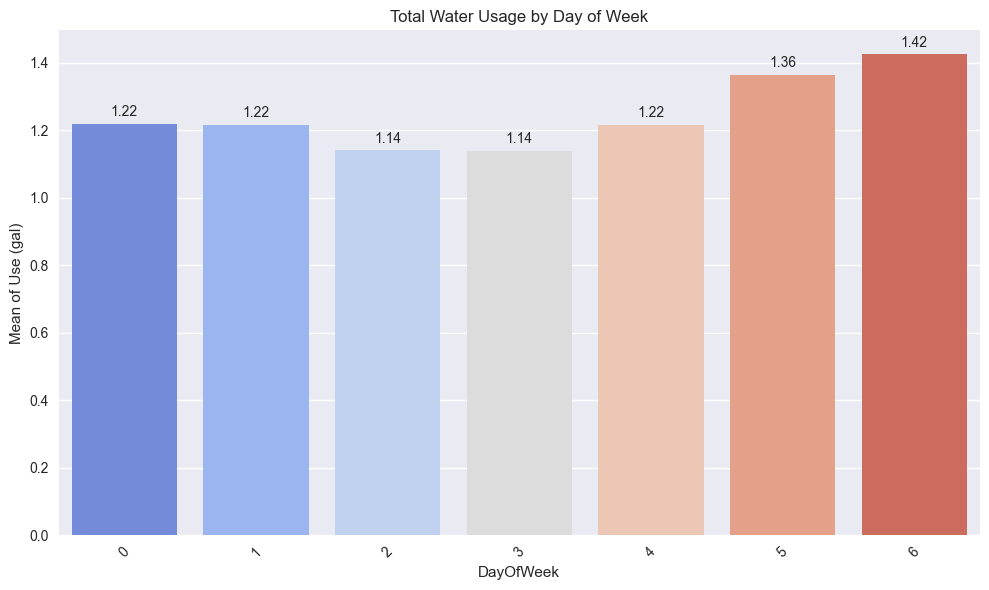

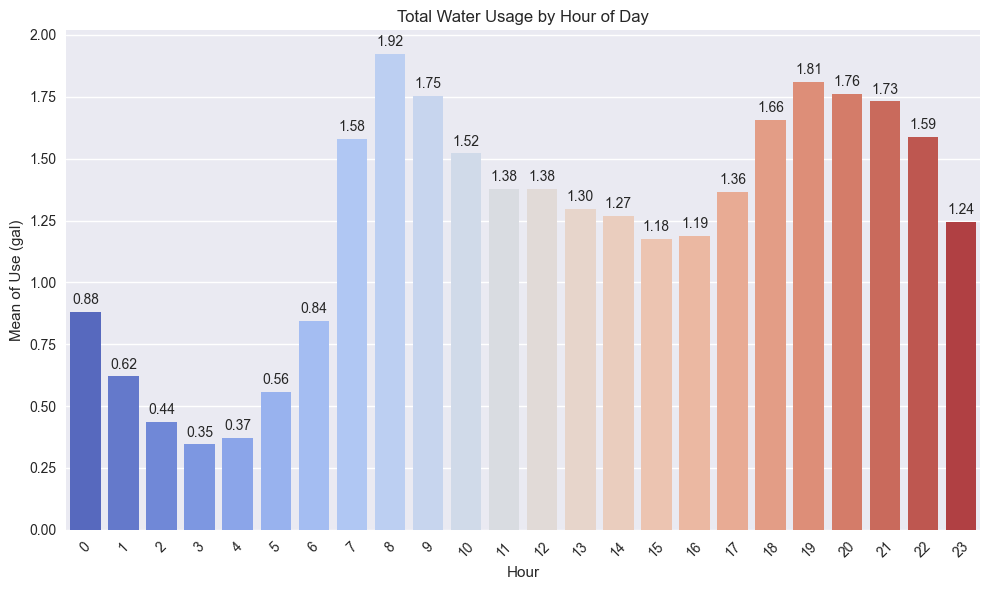

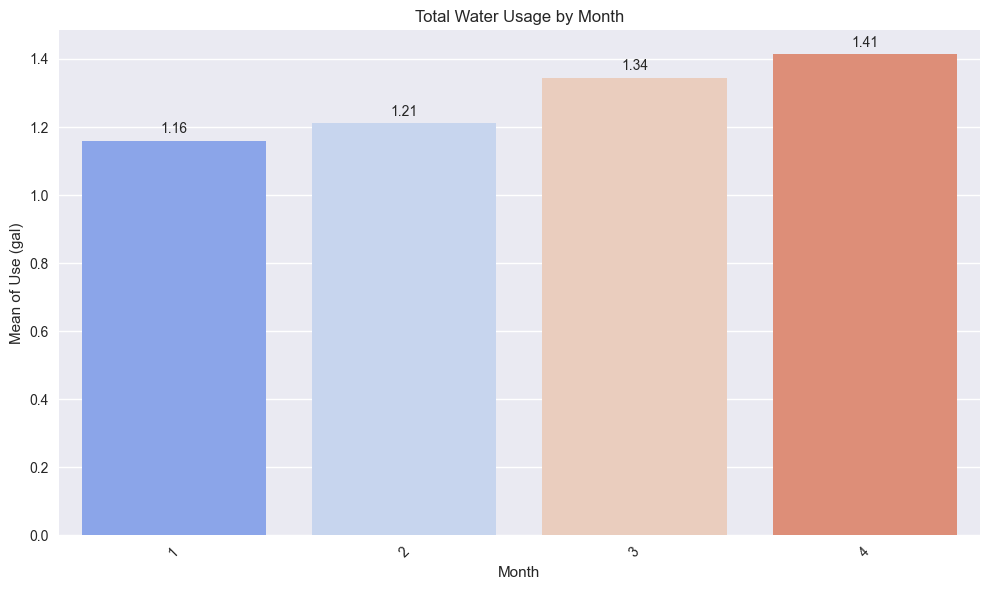

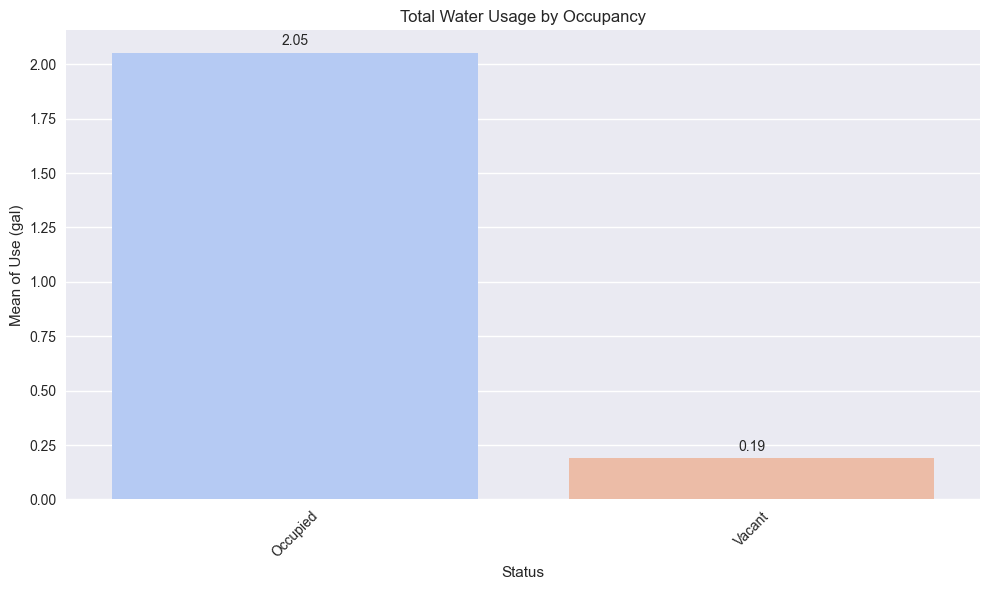

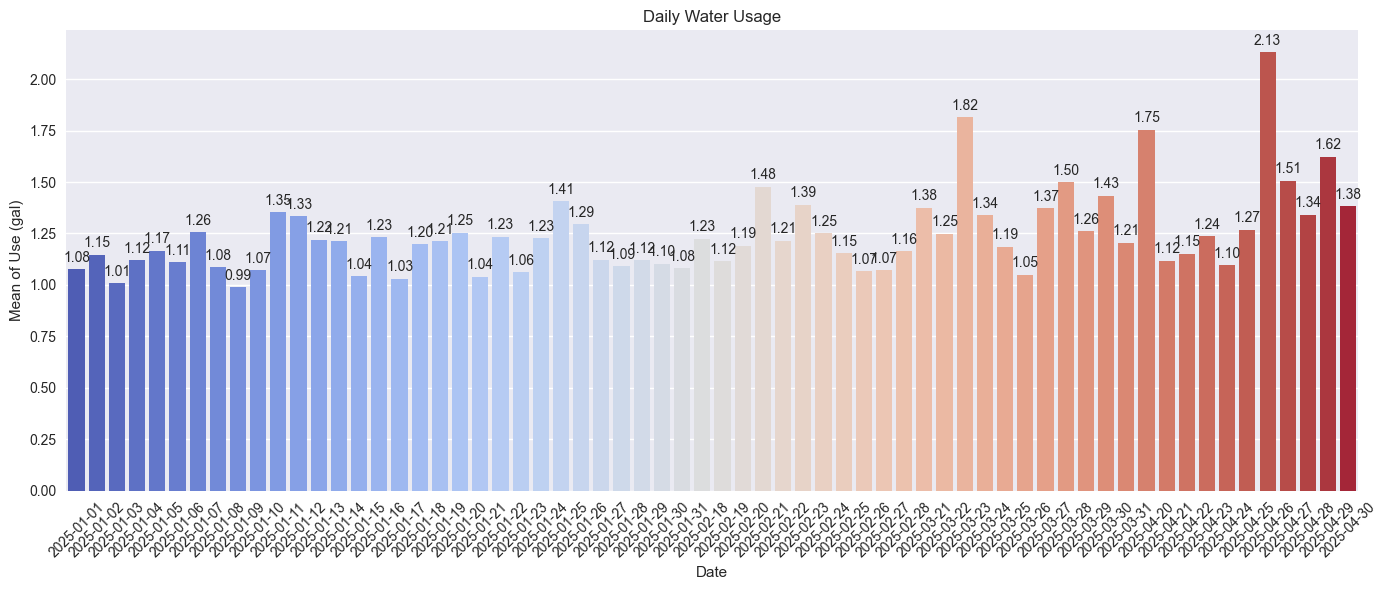

In [203]:
# Water usage by Location
plot_bar_with_labels(df1, 'Location', title='Total Water Usage by Location')

# Water usage by Unit Type
plot_bar_with_labels(df1, 'Unit Type', title='Total Water Usage by Unit Type')

# Water usage by Unit Type Matrix
plot_bar_with_labels(df1, 'Unit Type Matrix', title='Total Water Usage by Unit Type Matrix')

# Water usage by Day of Week
plot_bar_with_labels(df1, 'DayOfWeek', title='Total Water Usage by Day of Week')

# Water usage by Hour
plot_bar_with_labels(df1, 'Hour', title='Total Water Usage by Hour of Day')

# Water usage by Month
plot_bar_with_labels(df1, 'Month', title='Total Water Usage by Month')

plot_bar_with_labels(df1,'Status', title= 'Total Water Usage by Occupancy')

plot_bar_with_labels(df1, 'Date', title='Daily Water Usage', figsize=(14, 6))


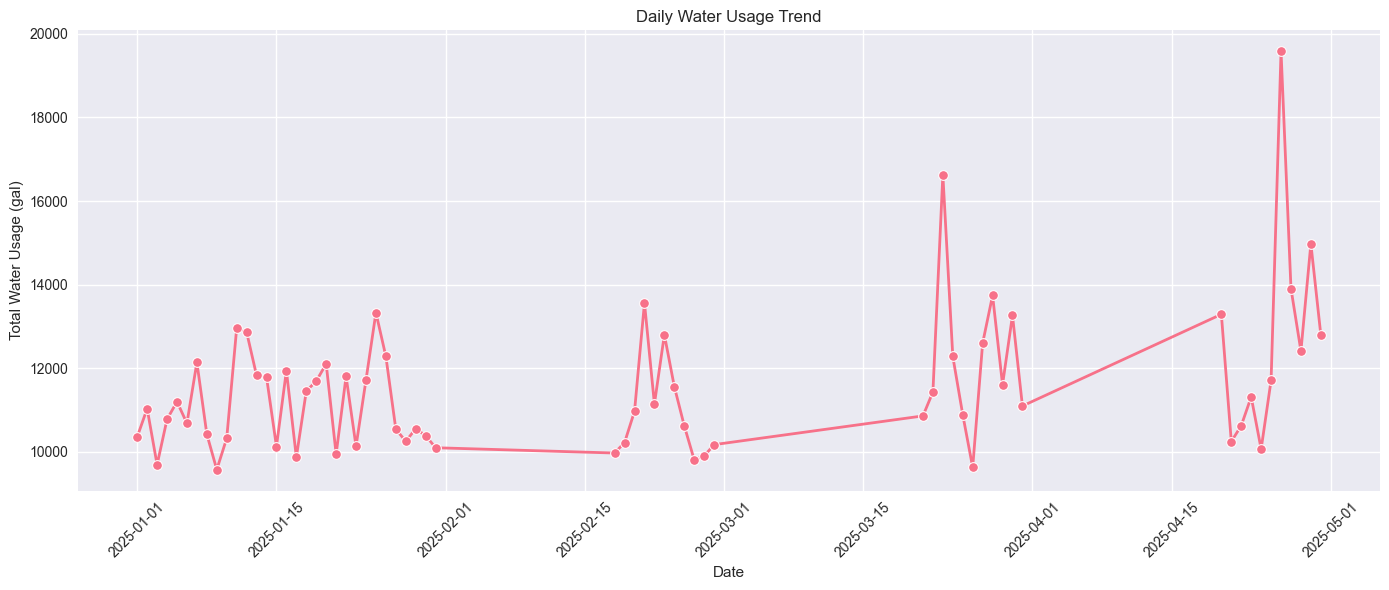

<Axes: xlabel='Date', ylabel='7d_avg'>

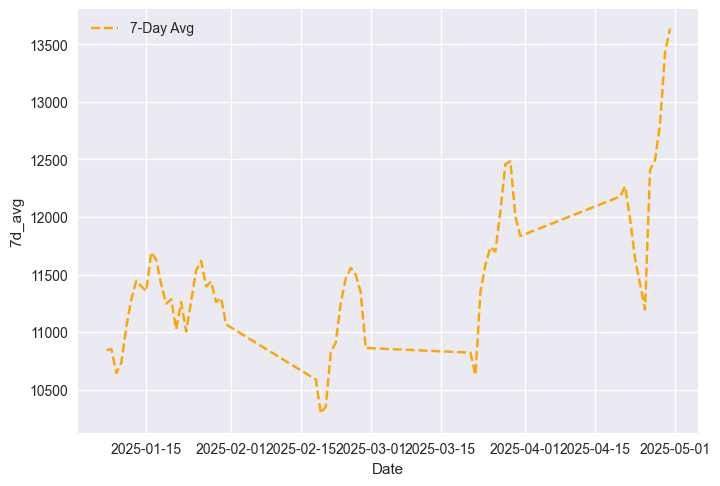

In [204]:
# Group by date to get daily total usage
daily_usage = df1.groupby('Date')['Use (gal)'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Use (gal)', data=daily_usage, marker='o', linewidth=2)

plt.title('Daily Water Usage Trend')
plt.xlabel('Date')
plt.ylabel('Total Water Usage (gal)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

daily_usage['7d_avg'] = daily_usage['Use (gal)'].rolling(window=7).mean()

sns.lineplot(x='Date', y='7d_avg', data=daily_usage, label='7-Day Avg', linestyle='--', color='orange')

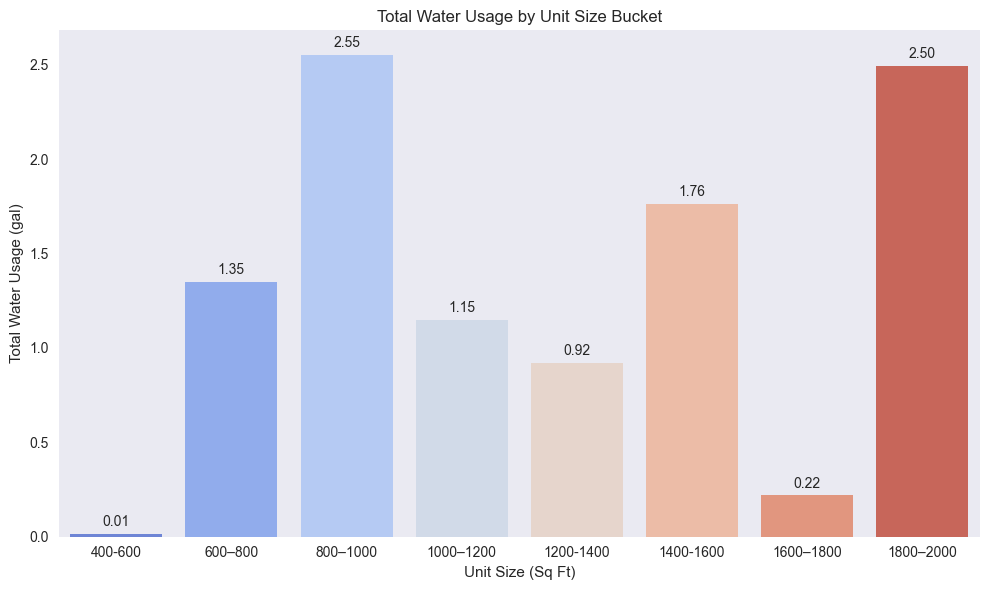

In [205]:
# Define bins and labels
bins = [400, 600, 800, 1000, 1200, 1400,  1600, 1800, 2000]
labels = ['400-600', '600–800', '800–1000','1000–1200', '1200-1400','1400-1600', '1600–1800', '1800–2000']

# Create bucket column
df1['unit_bucket'] = pd.cut(df1['Unit Size (Sf)'], bins=bins, labels=labels)

bucket_usage = df1.groupby('unit_bucket')['Use (gal)'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='unit_bucket', y='Use (gal)', data=bucket_usage, palette='coolwarm')

# Add labels on top of bars
for i, value in enumerate(bucket_usage['Use (gal)']):
    ax.text(i, value + 0.01 * bucket_usage['Use (gal)'].max(), f'{value:.2f}',
            ha='center', va='bottom', fontsize=10)

plt.title('Total Water Usage by Unit Size Bucket')
plt.xlabel('Unit Size (Sq Ft)')
plt.ylabel('Total Water Usage (gal)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

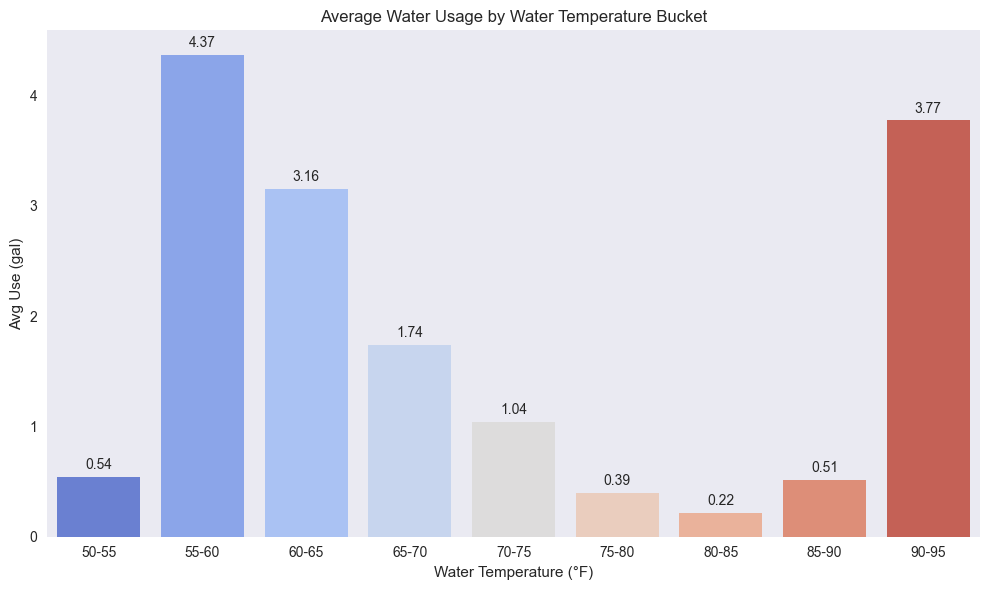

In [206]:
# Define bins and labels for Water Temp
bins = list(range(50, 100, 5))  # e.g., [50, 55, 60, ..., 90]
labels = [f'{i}-{i+5}' for i in bins[:-1]]

# Create temperature bucket column
df1['temp_bucket'] = pd.cut(df1['Water Temp (gal)'], bins=bins, labels=labels)

# Group by temperature bucket and calculate average water usage
temp_usage = df1.groupby('temp_bucket')['Use (gal)'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='temp_bucket', y='Use (gal)', data=temp_usage, palette='coolwarm')

# Add value labels on top of bars
for i, value in enumerate(temp_usage['Use (gal)']):
    ax.text(i, value + 0.01 * temp_usage['Use (gal)'].max(), f'{value:.2f}',
            ha='center', va='bottom', fontsize=10)

plt.title('Average Water Usage by Water Temperature Bucket')
plt.xlabel('Water Temperature (°F)')
plt.ylabel('Avg Use (gal)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

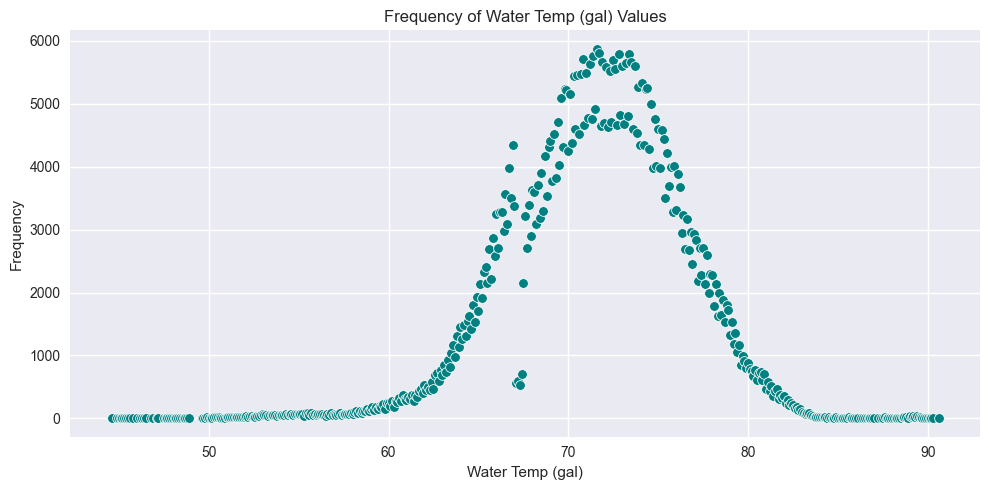

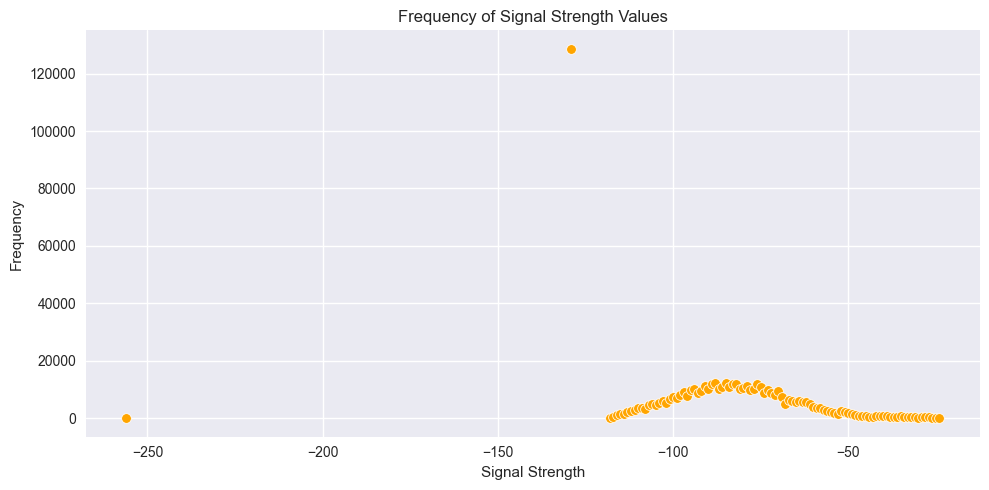

In [207]:
def plot_frequency_scatter(df, column, color='teal', figsize=(10, 5)):
    """
    Plots a scatter plot of unique values in a column vs their frequency.

    Parameters:
    - df: DataFrame
    - column: Column name (str) to analyze
    - color: Scatter color
    - figsize: Size of the plot
    """
    # Count frequency of each unique value
    freq_df = df[column].value_counts().reset_index()
    freq_df.columns = [column, 'Frequency']
    freq_df = freq_df.sort_values(column)

    # Plot
    plt.figure(figsize=figsize)
    sns.scatterplot(data=freq_df, x=column, y='Frequency', color=color)
    plt.title(f'Frequency of {column} Values')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Water Temp vs Frequency
plot_frequency_scatter(df1, 'Water Temp (gal)', color='teal')

# Signal Strength vs Frequency
plot_frequency_scatter(df1, 'Signal Strength', color='orange')



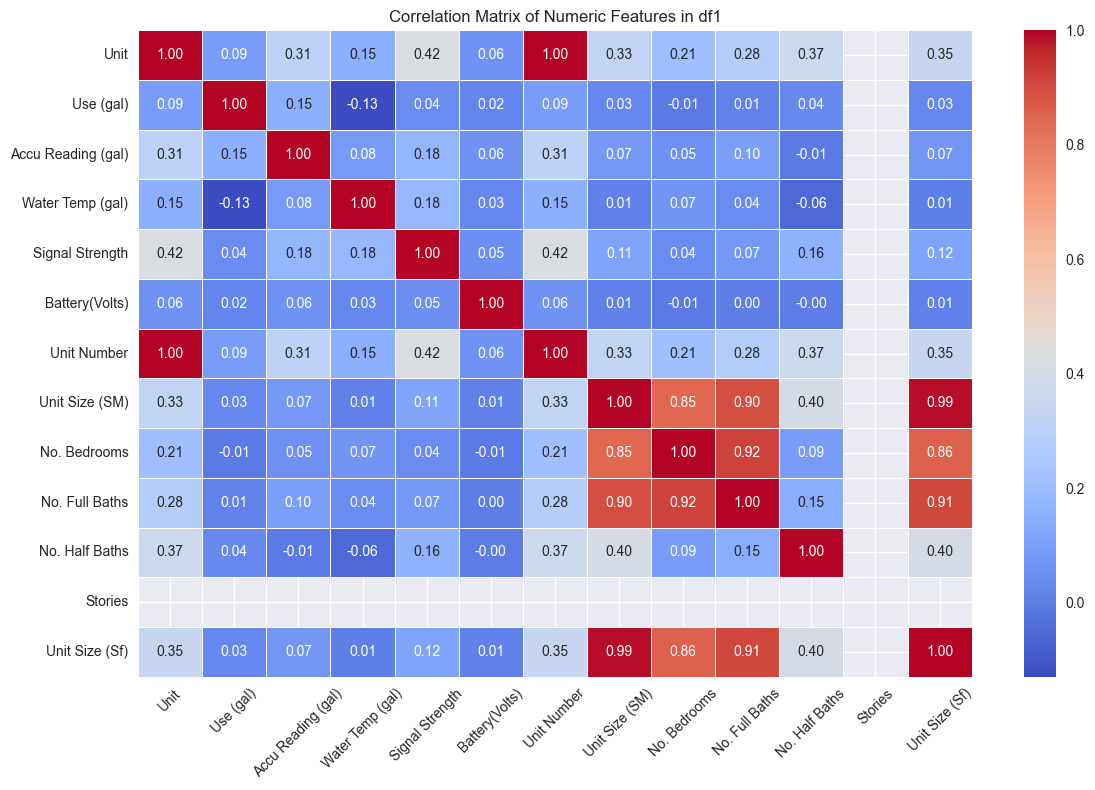

In [208]:
# Step 1: Select only numeric columns
numeric_df = df1.select_dtypes(include=['float64', 'int64'])

# Step 2: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Numeric Features in df1")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [209]:
df1.duplicated().sum()

0

In [210]:
print(df1['Unit Type'].nunique())
print(df1['Unit'].nunique())

42
401


# Missing Value Analysis

In [211]:
na_df = final_df[final_df.isna().any(axis=1)]
na_df.reset_index(inplace=True)
na_df.drop(columns=['index'], inplace=True)
na_df.shape

(1539, 22)

In [212]:
final_df.isna().sum()

Building Name                   0
Unit                            1
Meter #                         1
Time Adjusted by Property       1
Use (gal)                       1
Accu Reading (gal)              1
Water Temp (gal)                1
Signal Strength                 1
Battery(Volts)                  1
Source_File                     0
Location                     1539
Unit Number                  1539
Unit Type                    1539
Status                       1539
Unit Size (SM)               1539
Unit Type Matrix             1539
Unit Class                   1539
No. Bedrooms                 1539
No. Full Baths               1539
No. Half Baths               1539
Stories                      1539
Unit Size (Sf)               1539
dtype: int64

In [213]:
final_df[final_df['Meter #'].isna()]
na_df = na_df[~na_df['Meter #'].isna()]
na_df=date_time_conversion(na_df)

In [214]:
na_df = na_df.astype({
    'Building Name': 'string',
    'Meter #': 'string',
    'Source_File': 'string',
    'Location': 'string',
    'Unit Type': 'string',
    'Status': 'string',
    'Unit Type Matrix': 'string',
    'Unit Class': 'string'
})


# Step 4: Convert numeric columns safely
numeric_columns = {
    'Water Temp (gal)': 'float',
    'Battery(Volts)': 'float',
    'Signal Strength': 'Int64',  # nullable integer
    'Unit Size (SM)': 'float',
    'No. Bedrooms': 'Int64',
    'No. Full Baths': 'Int64',
    'No. Half Baths': 'Int64',
    'Stories': 'Int64',
    'Unit Size (Sf)': 'Int64'   # appears to be a duplicate or alternate spelling
}

for col, dtype in numeric_columns.items():
    na_df[col] = pd.to_numeric(na_df[col], errors='coerce').astype(dtype)

In [215]:
def safe_str_to_float(val):
    if pd.isna(val):
        return val  # keep NaNs as is
    try:
        # Remove commas if present, then convert to float
        return float(str(val).replace(',', ''))
    except ValueError:
        # If conversion fails, keep original value (or np.nan if you prefer)
        return val

na_df['Accu Reading (gal)'] = na_df['Accu Reading (gal)'].apply(safe_str_to_float)
na_df['Use (gal)'] = na_df['Use (gal)'].apply(safe_str_to_float)

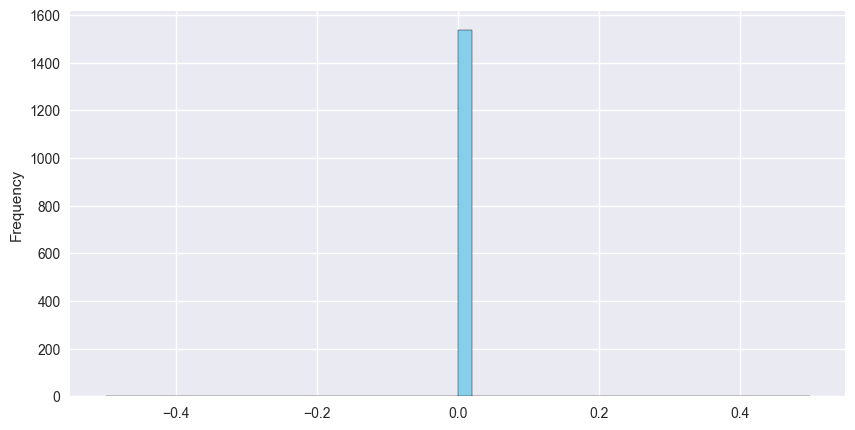

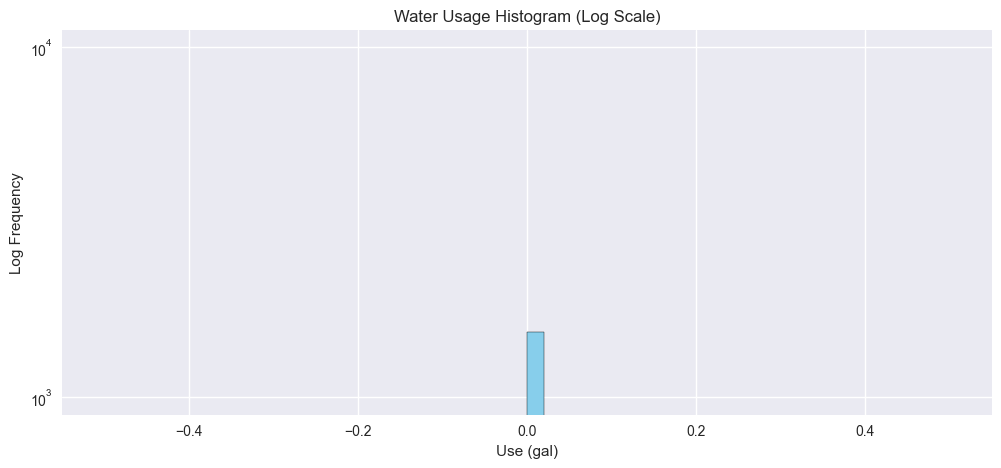

Use (gal)
0.0    1538
Name: count, dtype: int64

In [216]:
na_df['Use (gal)'].plot.hist(bins=50, figsize=(10,5), color='skyblue', edgecolor='black')
plt.show()
na_df['Use (gal)'].plot.hist(bins=50, log=True, figsize=(12, 5), color='skyblue', edgecolor='black')
plt.title("Water Usage Histogram (Log Scale)")
plt.xlabel("Use (gal)")
plt.ylabel("Log Frequency")
plt.show()


na_df['Use (gal)'].value_counts()

# Feature Engineering

In [217]:
df1['Status'].value_counts()

Status
Occupied    336504
Vacant      259669
Name: count, dtype: Int64

In [218]:
df1.drop(columns = ['Meter #', 'Battery(Volts)', 'Source_File', 'Unit Type Matrix', 'Stories', 'Unit Class', 'Building Name','use_bucket','unit_bucket','temp_bucket'], inplace=True)

In [219]:
df1.isna().sum()

Unit                         0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Unit Size (Sf)               0
Date                         0
Hour                         0
DayOfWeek                    0
Month                        0
dtype: int64

In [220]:
df1['Unit'] = df1['Unit'].astype('Int64')
df_sorted = df1.sort_values(by=['Unit', 'Time Adjusted by Property'], ascending=[True, True])

df_sorted.reset_index(inplace=True)
df_sorted.drop(columns=['index'], inplace=True)
print(df_sorted.columns)
df_sorted.isna().sum()


Index(['Unit', 'Time Adjusted by Property', 'Use (gal)', 'Accu Reading (gal)',
       'Water Temp (gal)', 'Signal Strength', 'Location', 'Unit Number',
       'Unit Type', 'Status', 'Unit Size (SM)', 'No. Bedrooms',
       'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'Date', 'Hour',
       'DayOfWeek', 'Month'],
      dtype='object')


Unit                         0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Unit Size (Sf)               0
Date                         0
Hour                         0
DayOfWeek                    0
Month                        0
dtype: int64

In [221]:
usage_counts_df = df_sorted['Use (gal)'].apply(lambda x: 'zero' if x == 0 else 'non_zero').value_counts()
print(usage_counts_df)

Use (gal)
zero        510807
non_zero     85366
Name: count, dtype: int64


In [222]:
df_sorted_1 = df_sorted[df_sorted['Hour'].between(7, 23)]

In [223]:
usage_counts_df = df_sorted_1['Use (gal)'].apply(lambda x: 'zero' if x == 0 else 'non_zero').value_counts()
print(usage_counts_df)

Use (gal)
zero        352884
non_zero     72155
Name: count, dtype: int64


In [224]:
df_sorted_2 = df_sorted[df_sorted['Hour'].between(8, 23)]
usage_counts_df = df_sorted_2['Use (gal)'].apply(lambda x: 'zero' if x == 0 else 'non_zero').value_counts()
print(usage_counts_df)

Use (gal)
zero        332202
non_zero     67844
Name: count, dtype: int64


In [225]:
df_sorted_3 = df_sorted[df_sorted['Hour'].between(9, 23)]
usage_counts_df = df_sorted_3['Use (gal)'].apply(lambda x: 'zero' if x == 0 else 'non_zero').value_counts()
print(usage_counts_df)

Use (gal)
zero        312294
non_zero     62734
Name: count, dtype: int64


In [226]:
df_new = df_sorted.copy()

df_new['hourly_time'] = df_new['Time Adjusted by Property'].dt.floor('H')
df_new = df_new.set_index('Time Adjusted by Property')
# Group by hour and key identifiers
df_new = df_new.groupby([
    pd.Grouper(freq='H'),  # Groups by each hour
    'Unit'
]).agg({
    'Use (gal)': 'sum',
    'Accu Reading (gal)': 'mean',
    'Water Temp (gal)': 'mean',
    'Signal Strength': 'mean',
    'Location': 'first',
    'Unit Number': 'first',
    'Unit Type': 'first',
    'Status': 'first',
    'Unit Size (SM)': 'first',
    'No. Bedrooms': 'first',
    'No. Full Baths': 'first',
    'No. Half Baths': 'first',
    'Unit Size (Sf)': 'first',
    'Date': 'first',
    'Hour': 'first',
    'DayOfWeek': 'first',
    'Month': 'first'
}).reset_index()

In [227]:
df_new = df_new.sort_values(by=['Unit', 'Date', 'Hour'], ascending=[True, True, True])

df_new.reset_index(inplace=True)
df_new.drop(columns=['index'], inplace=True)

duplicate_count = df_new.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

df_new[df_new['Use (gal)'] > 0]

Total duplicate rows: 0


Time Adjusted by Property  Unit  Use (gal)  Accu Reading (gal)  \
1505         2025-04-30 11:00:00   202       2.64              540.89   
1506         2025-04-30 12:00:00   202       7.93              549.48   
1507         2025-04-30 13:00:00   202      10.57              560.04   
1508         2025-04-30 14:00:00   202       5.28              565.33   
1581         2025-01-03 15:00:00   203       2.64              258.89   
...                          ...   ...        ...                 ...   
586705       2025-04-29 14:00:00  2806       7.93             1286.52   
586706       2025-04-29 15:00:00  2806       5.28             1291.80   
586708       2025-04-29 17:00:00  2806       2.64             1294.44   
586709       2025-04-29 18:00:00  2806       2.64             1297.08   
586728       2025-04-30 13:00:00  2806       2.64             1299.73   

        Water Temp (gal)  Signal Strength  Location  Unit Number Unit Type  \
1505               70.85           -64.75  Floor 02        202.0       C3A   
1506               70.00            -69.0  Floor 02        202.0       C3A   
1507               69.20            -68.0  Floor 02        202.0       C3A   
1508               69.60            -72.0  Floor 02        202.0       C3A   
1581               65.30            -80.0  Floor 02        203.0        A4   
...                  ...              ...       ...          ...       ...   
586705             80.70           -102.0  Floor 28       2806.0        D2   
586706             80.20           -102.0  Floor 28       2806.0        D2   
586708             79.90           -103.0  Floor 28       2806.0        D2   
586709             80.10           -103.0  Floor 28       2806.0        D2   
586728             78.20           -102.0  Floor 28       2806.0        D2   

        Status  Unit Size (SM)  No. Bedrooms  No. Full Baths  No. Half Baths  \
1505    Vacant          110.65             2               2               0   
1506    Vacant          110.65             2               2               0   
1507    Vacant          110.65             2               2               0   
1508    Vacant          110.65             2               2               0   
1581    Vacant           98.57             1               1               0   
...        ...             ...           ...             ...             ...   
586705  Vacant            0.00             2               2               0   
586706  Vacant            0.00             2               2               0   
586708  Vacant            0.00             2               2               0   
586709  Vacant            0.00             2               2               0   
586728  Vacant            0.00             2               2               0   

        Unit Size (Sf)        Date  Hour  DayOfWeek  Month  
1505              1191  2025-04-30    11          2      4  
1506              1191  2025-04-30    12          2      4  
1507              1191  2025-04-30    13          2      4  
1508              1191  2025-04-30    14          2      4  
1581              1061  2025-01-03    15          4      1  
...                ...         ...   ...        ...    ...  
586705            1204  2025-04-29    14          1      4  
586706            1204  2025-04-29    15          1      4  
586708            1204  2025-04-29    17          1      4  
586709            1204  2025-04-29    18          1      4  
586728            1204  2025-04-30    13          2      4  

[85362 rows x 19 columns]

In [228]:
# Function to find missing hours per group
def find_missing_hours(group):
    expected_hours = set(range(24))
    present_hours = set(group['Hour'])
    return sorted(expected_hours - present_hours)

# Group by Date and Unit and find missing hours
missing_detail = df_new.groupby(['Date', 'Unit']).apply(find_missing_hours).reset_index(name='Missing Hours')

# Filter only those with missing hours
missing_detail = missing_detail[missing_detail['Missing Hours'].apply(len) > 0]

print(missing_detail)

             Date  Unit Missing Hours
4      2025-01-01   207          [19]
8      2025-01-01   211           [2]
9      2025-01-01   212           [9]
20     2025-01-01   308          [20]
53     2025-01-01   708          [16]
...           ...   ...           ...
24731  2025-04-30  2210           [5]
24740  2025-04-30  2301       [7, 18]
24743  2025-04-30  2304          [17]
24755  2025-04-30  2318          [19]
24777  2025-04-30  2609          [20]

[3357 rows x 3 columns]


# Adding Missing Hours

In [229]:
all_hours = np.arange(24)

all_dates = df_new['Date'].unique()
all_units = df_new['Unit'].unique()


full_index = pd.DataFrame(
    list(product(all_dates, all_units, all_hours)),
    columns=['Date', 'Unit', 'Hour']
)



df_full = pd.merge(full_index, df_new, on=['Date', 'Unit', 'Hour'], how='left')



df_full = df_full.sort_values(by=['Date', 'Unit', 'Hour']).reset_index(drop=True)

df_full

Date  Unit  Hour Time Adjusted by Property  Use (gal)  \
0       2025-01-01   202     0       2025-01-01 00:00:00        0.0   
1       2025-01-01   202     1       2025-01-01 01:00:00        0.0   
2       2025-01-01   202     2       2025-01-01 02:00:00        0.0   
3       2025-01-01   202     3       2025-01-01 03:00:00        0.0   
4       2025-01-01   202     4       2025-01-01 04:00:00        0.0   
...            ...   ...   ...                       ...        ...   
615931  2025-04-30  2806    19       2025-04-30 19:00:00        0.0   
615932  2025-04-30  2806    20       2025-04-30 20:00:00        0.0   
615933  2025-04-30  2806    21       2025-04-30 21:00:00        0.0   
615934  2025-04-30  2806    22       2025-04-30 22:00:00        0.0   
615935  2025-04-30  2806    23       2025-04-30 23:00:00        0.0   

        Accu Reading (gal)  Water Temp (gal)  Signal Strength  Location  \
0                   538.91              66.0            -90.0  Floor 02   
1                   538.91              66.0            -94.0  Floor 02   
2                   538.91              65.9            -94.0  Floor 02   
3                   538.91              65.8            -87.0  Floor 02   
4                   538.91              65.7            -90.0  Floor 02   
...                    ...               ...              ...       ...   
615931             1299.73              78.8           -103.0  Floor 28   
615932             1299.73              78.8           -104.0  Floor 28   
615933             1299.73              78.8           -105.0  Floor 28   
615934             1299.73              78.8           -105.0  Floor 28   
615935             1299.73              78.7           -105.0  Floor 28   

        Unit Number Unit Type  Status  Unit Size (SM)  No. Bedrooms  \
0             202.0       C3A  Vacant          110.65             2   
1             202.0       C3A  Vacant          110.65             2   
2             202.0       C3A  Vacant          110.65             2   
3             202.0       C3A  Vacant          110.65             2   
4             202.0       C3A  Vacant          110.65             2   
...             ...       ...     ...             ...           ...   
615931       2806.0        D2  Vacant            0.00             2   
615932       2806.0        D2  Vacant            0.00             2   
615933       2806.0        D2  Vacant            0.00             2   
615934       2806.0        D2  Vacant            0.00             2   
615935       2806.0        D2  Vacant            0.00             2   

        No. Full Baths  No. Half Baths  Unit Size (Sf)  DayOfWeek  Month  
0                    2               0            1191        2.0    1.0  
1                    2               0            1191        2.0    1.0  
2                    2               0            1191        2.0    1.0  
3                    2               0            1191        2.0    1.0  
4                    2               0            1191        2.0    1.0  
...                ...             ...             ...        ...    ...  
615931               2               0            1204        2.0    4.0  
615932               2               0            1204        2.0    4.0  
615933               2               0            1204        2.0    4.0  
615934               2               0            1204        2.0    4.0  
615935               2               0            1204        2.0    4.0  

[615936 rows x 19 columns]

In [230]:
df_full.isna().sum()

# Fill Accu Reading (gal)
# Interpolate Accumulated Reading using time-based interpolation

df_full['Accu Reading (gal)'] = df_full['Accu Reading (gal)'].interpolate(method='linear')

# Fill Use (gal) by calculating actual hourly usage from Accumulated Reading

# Step 1: Calculate usage based on accumulated readings
calculated_use = df_full.groupby('Unit')['Accu Reading (gal)'].diff()

# Step 2: Replace NaN diffs (usually the first record per group) with 0
calculated_use = calculated_use.fillna(0)

# Step 3: Set negative usage to 0 (usage can't be negative)
calculated_use = calculated_use.clip(lower=0)

# Step 4: Cap outliers to 99.5th percentile of existing 'Use (gal)' values
upper_limit = df_full['Use (gal)'].quantile(0.995)
calculated_use = calculated_use.clip(upper=upper_limit)

# Step 5: Fill missing 'Use (gal)' values ONLY
mask_missing = df_full['Use (gal)'].isna()
df_full.loc[mask_missing, 'Use (gal)'] = calculated_use.loc[mask_missing]

# Fill Water Temp (gal)
# Interpolated - as they vary smoothly

mask_missing = df_full['Water Temp (gal)'].isna()

# Calculate interpolated values within each Unit
interp_values = (
    df_full.groupby('Unit')['Water Temp (gal)']
    .transform(lambda x: x.interpolate(method='linear').ffill().bfill())
)

# Fill only missing values
df_full.loc[mask_missing, 'Water Temp (gal)'] = interp_values.loc[mask_missing]



df_full['Signal Strength'] = df_full['Signal Strength'].interpolate(method='linear')


# Constant for other missing columns values

meta_cols = ['Location', 'Unit Type', 'Status', 'Unit Size (SM)',
             'No. Bedrooms', 'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'Unit Number', 'DayOfWeek', 'Month']

mask_missing = df_full[meta_cols].isna()

# Compute forward/backward fill per group
filled = df_full.groupby('Unit')[meta_cols].ffill().bfill()

# Only fill missing values per column
for col in meta_cols:
    df_full.loc[mask_missing[col], col] = filled.loc[mask_missing[col], col]


df_full.isna().sum()

Date                             0
Unit                             0
Hour                             0
Time Adjusted by Property    29197
Use (gal)                        0
Accu Reading (gal)               0
Water Temp (gal)                 0
Signal Strength                  0
Location                         0
Unit Number                      0
Unit Type                        0
Status                           0
Unit Size (SM)                   0
No. Bedrooms                     0
No. Full Baths                   0
No. Half Baths                   0
Unit Size (Sf)                   0
DayOfWeek                        0
Month                            0
dtype: int64

In [231]:
# Recreated 'Time Adjusted by Property' to handle missing values in time column

df_full['Time Adjusted by Property'] = pd.to_datetime(df_full['Date']) + pd.to_timedelta(df_full['Hour'], unit='h')


df_full.isna().sum()

Date                         0
Unit                         0
Hour                         0
Time Adjusted by Property    0
Use (gal)                    0
Accu Reading (gal)           0
Water Temp (gal)             0
Signal Strength              0
Location                     0
Unit Number                  0
Unit Type                    0
Status                       0
Unit Size (SM)               0
No. Bedrooms                 0
No. Full Baths               0
No. Half Baths               0
Unit Size (Sf)               0
DayOfWeek                    0
Month                        0
dtype: int64

In [232]:
duplicate_count = df_full.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
df_full

Total duplicate rows: 0


Date  Unit  Hour Time Adjusted by Property  Use (gal)  \
0       2025-01-01   202     0       2025-01-01 00:00:00        0.0   
1       2025-01-01   202     1       2025-01-01 01:00:00        0.0   
2       2025-01-01   202     2       2025-01-01 02:00:00        0.0   
3       2025-01-01   202     3       2025-01-01 03:00:00        0.0   
4       2025-01-01   202     4       2025-01-01 04:00:00        0.0   
...            ...   ...   ...                       ...        ...   
615931  2025-04-30  2806    19       2025-04-30 19:00:00        0.0   
615932  2025-04-30  2806    20       2025-04-30 20:00:00        0.0   
615933  2025-04-30  2806    21       2025-04-30 21:00:00        0.0   
615934  2025-04-30  2806    22       2025-04-30 22:00:00        0.0   
615935  2025-04-30  2806    23       2025-04-30 23:00:00        0.0   

        Accu Reading (gal)  Water Temp (gal)  Signal Strength  Location  \
0                   538.91              66.0            -90.0  Floor 02   
1                   538.91              66.0            -94.0  Floor 02   
2                   538.91              65.9            -94.0  Floor 02   
3                   538.91              65.8            -87.0  Floor 02   
4                   538.91              65.7            -90.0  Floor 02   
...                    ...               ...              ...       ...   
615931             1299.73              78.8           -103.0  Floor 28   
615932             1299.73              78.8           -104.0  Floor 28   
615933             1299.73              78.8           -105.0  Floor 28   
615934             1299.73              78.8           -105.0  Floor 28   
615935             1299.73              78.7           -105.0  Floor 28   

        Unit Number Unit Type  Status  Unit Size (SM)  No. Bedrooms  \
0             202.0       C3A  Vacant          110.65             2   
1             202.0       C3A  Vacant          110.65             2   
2             202.0       C3A  Vacant          110.65             2   
3             202.0       C3A  Vacant          110.65             2   
4             202.0       C3A  Vacant          110.65             2   
...             ...       ...     ...             ...           ...   
615931       2806.0        D2  Vacant            0.00             2   
615932       2806.0        D2  Vacant            0.00             2   
615933       2806.0        D2  Vacant            0.00             2   
615934       2806.0        D2  Vacant            0.00             2   
615935       2806.0        D2  Vacant            0.00             2   

        No. Full Baths  No. Half Baths  Unit Size (Sf)  DayOfWeek  Month  
0                    2               0            1191        2.0    1.0  
1                    2               0            1191        2.0    1.0  
2                    2               0            1191        2.0    1.0  
3                    2               0            1191        2.0    1.0  
4                    2               0            1191        2.0    1.0  
...                ...             ...             ...        ...    ...  
615931               2               0            1204        2.0    4.0  
615932               2               0            1204        2.0    4.0  
615933               2               0            1204        2.0    4.0  
615934               2               0            1204        2.0    4.0  
615935               2               0            1204        2.0    4.0  

[615936 rows x 19 columns]

# Adding Features

In [233]:
#df_full['water_use_ema_2h'] = df_full['Use (gal)'].ewm(span=2, adjust=False).mean()
df_full['water_use_ema_3h'] = df_full['Use (gal)'].ewm(span=3, adjust=False).mean()
df_full['water_use_ema_5h'] = df_full['Use (gal)'].ewm(span=5, adjust=False).mean()
#df_full['use_lag_1h'] = df_full['Use (gal)'].shift(1).fillna(0)
df_full['use_lag_24h'] = df_full['Use (gal)'].shift(24).fillna(0)  # same hour yesterday

# df_full['rolling_mean_6h'] = df_full['Use (gal)'].rolling(6).mean()
# df_full['rolling_std_6h'] = df_full['Use (gal)'].rolling(6).std()
# df_full['rolling_mean_24h'] = df_full['Use (gal)'].rolling(24).mean()
# df_full['rolling_std_24h'] = df_full['Use (gal)'].rolling(24).std()
# df_full['rolling_168h_mean'] = df_full.groupby('Unit')['Use (gal)'].transform(lambda x: x.rolling(168, min_periods=24).mean())

#df_full['spike_ratio'] = df_full['Use (gal)'] / (df_full['rolling_mean_24h'] + 1e-5)
df_full['temp_delta_1h'] = df_full.groupby('Unit')['Water Temp (gal)'].diff()


df_full['is_weekend'] = df_full['DayOfWeek'].isin([5, 6]).astype(int)
df_full['is_working_hour'] = df_full['Hour'].between(9, 17).astype(int)

df_full['is_night'] = df_full['Hour'].isin(range(0, 6)).astype(int)
df_full['is_morning'] = df_full['Hour'].isin(range(6, 10)).astype(int)
df_full['is_evening'] = df_full['Hour'].isin(range(17, 22)).astype(int)


print(df_full.columns)


for col in df_full.columns:
    unique_count = df_full[col].nunique()
    print(f"{col}: {unique_count} unique values")



Index(['Date', 'Unit', 'Hour', 'Time Adjusted by Property', 'Use (gal)',
       'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Location',
       'Unit Number', 'Unit Type', 'Status', 'Unit Size (SM)', 'No. Bedrooms',
       'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek',
       'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h',
       'temp_delta_1h', 'is_weekend', 'is_working_hour', 'is_night',
       'is_morning', 'is_evening'],
      dtype='object')
Date: 64 unique values
Unit: 401 unique values
Hour: 24 unique values
Time Adjusted by Property: 1536 unique values
Use (gal): 536 unique values
Accu Reading (gal): 35582 unique values
Water Temp (gal): 6044 unique values
Signal Strength: 6706 unique values
Location: 25 unique values
Unit Number: 401 unique values
Unit Type: 42 unique values
Status: 2 unique values
Unit Size (SM): 41 unique values
No. Bedrooms: 3 unique values
No. Full Baths: 3 unique values
No. Half Baths: 2 unique values
U

In [234]:
df_full['Date'] = pd.to_datetime(df_full['Date'])
# df['Location']-->25 unique values
# df['Unit Type']-->42 unique values
# df['Status']-->2 unique values
# df['Unit Type Matrix']-->7 unique values
df_full.dtypes

Date                         datetime64[ns]
Unit                                  int64
Hour                                  int64
Time Adjusted by Property    datetime64[ns]
Use (gal)                           float64
Accu Reading (gal)                  float64
Water Temp (gal)                    float64
Signal Strength                     Float64
Location                     string[python]
Unit Number                         float64
Unit Type                    string[python]
Status                       string[python]
Unit Size (SM)                      float64
No. Bedrooms                          Int64
No. Full Baths                        Int64
No. Half Baths                        Int64
Unit Size (Sf)                        Int64
DayOfWeek                           float64
Month                               float64
water_use_ema_3h                    float64
water_use_ema_5h                    float64
use_lag_24h                         float64
temp_delta_1h                   

# Encoding Categorical Variable

In [235]:
def preprocess_data(df):
    data = df.copy()
    label_encoders = {}
    embedding_dims = {}

    # Handle missing values
    print("Handling missing values...")
    data = data.fillna(method='ffill').fillna(method='bfill')

    # Convert datetime columns
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
    if 'Time Adjusted by Property' in data.columns:
        data['Time Adjusted by Property'] = pd.to_datetime(data['Time Adjusted by Property'])

    # Label encode low-cardinality categoricals
    categorical_le = [ 'Status']
    for col in categorical_le:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le
            print(f"Label encoded {col}: {len(le.classes_)} unique values")

    # Encode high-cardinality categoricals for embeddings
    embedding_cols = ['Location', 'Unit Type']
    for col in embedding_cols:
        if col in data.columns:
            le = LabelEncoder()
            data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le

            cardinality = len(le.classes_)
            embedding_dim = min(50, (cardinality + 1) // 2)
            embedding_dims[col] = {
                'vocab_size': cardinality,
                'embedding_dim': embedding_dim
            }
            print(f"Embedding for {col}: vocab_size={cardinality}, embedding_dim={embedding_dim}")

    return data, label_encoders, embedding_dims

df_processed, label_encoders, embedding_dims = preprocess_data(df_full)

# df_processed['water_used'] = (df_processed['Use (gal)'] > 0).astype(int)



Handling missing values...
Label encoded Status: 2 unique values
Embedding for Location: vocab_size=25, embedding_dim=13
Embedding for Unit Type: vocab_size=42, embedding_dim=21


In [256]:
def prepare_features(data, target='Use (gal)'):
    
    exclude_cols = ['Date', 'Time Adjusted by Property', 'Location', 'Unit Type', target]
    
    numerical_features = []
    for col in data.columns:
        if col not in exclude_cols and not col.endswith('_encoded'):
            if data[col].dtype in ['int64', 'float64', 'Int64', 'Float64']:
                numerical_features.append(col)
    
    print(f"Selected {len(numerical_features)} numerical features")
    print("Numerical features:", numerical_features)
    
    X_numerical = data[numerical_features].astype(float)
    X_embeddings = {}
    
    for col in ['Location', 'Unit Type']:
        if col + '_encoded' in data.columns:
            X_embeddings[col] = data[col + '_encoded'].values
    
    y = data[target].values
    
    return X_numerical, X_embeddings, y, numerical_features

X_numerical, X_embeddings, y, numerical_features = prepare_features(df_processed)
print(f"\nDataset Info:")
print(f"- Total samples: {len(y)}")
print(f"- Numerical features: {X_numerical.shape[1]}")
print(f"- Embedding features: {len(X_embeddings)}")
print(f"- Target statistics: mean={y.mean():.2f}, std={y.std():.2f}")


Selected 23 numerical features
Numerical features: ['Unit', 'Hour', 'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Unit Number', 'Status', 'Unit Size (SM)', 'No. Bedrooms', 'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek', 'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h', 'temp_delta_1h', 'is_weekend', 'is_working_hour', 'is_night', 'is_morning', 'is_evening']

Dataset Info:
- Total samples: 615936
- Numerical features: 23
- Embedding features: 2
- Target statistics: mean=1.73, std=6.82


In [257]:
import pandas as pd

# Convert y to pandas Series with a name
y_series = pd.Series(y, name='target')

# Combine with X_numerical (which should be a DataFrame)
df = pd.concat([X_numerical, y_series], axis=1)

# Compute correlations with target
correlations = df.corr()['target'].sort_values(ascending=False)

print(correlations)


target                1.000000
water_use_ema_3h      0.914210
water_use_ema_5h      0.838375
Accu Reading (gal)    0.144940
Unit Number           0.120471
Unit                  0.120460
use_lag_24h           0.080157
Unit Size (SM)        0.067916
Unit Size (Sf)        0.067192
No. Half Baths        0.053647
No. Full Baths        0.053606
Signal Strength       0.039034
is_evening            0.022214
Hour                  0.020385
No. Bedrooms          0.020260
DayOfWeek             0.016427
is_morning            0.010406
is_working_hour       0.000671
is_weekend           -0.012415
Month                -0.022261
is_night             -0.027718
Water Temp (gal)     -0.084099
Status               -0.164236
temp_delta_1h        -0.207182
Name: target, dtype: float64


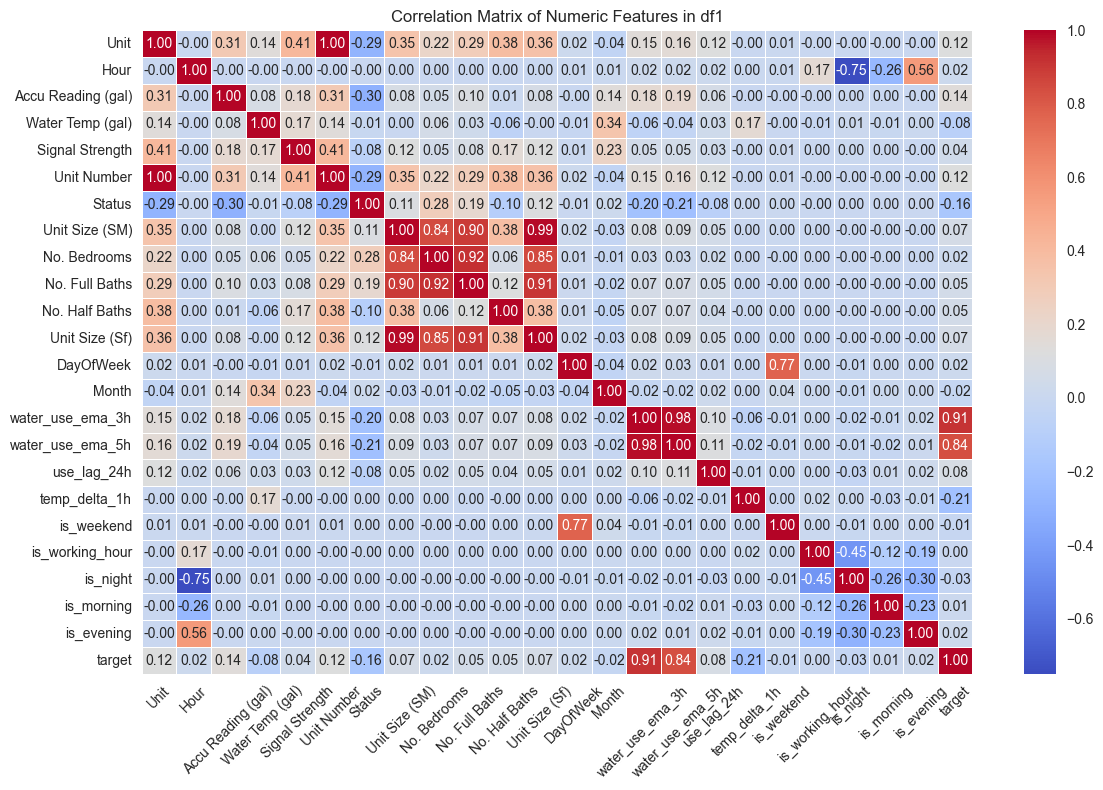

In [258]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Numeric Features in df1")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [259]:
X_numerical.drop(columns=['Unit Size (SM)','No. Bedrooms'], inplace=True)

In [260]:
import pandas as pd

# Convert y to pandas Series with a name
y_series = pd.Series(y, name='target')

# Combine with X_numerical (which should be a DataFrame)
df = pd.concat([X_numerical, y_series], axis=1)

# Compute correlations with target
correlations = df.corr()['target'].sort_values(ascending=False)

print(correlations)


target                1.000000
water_use_ema_3h      0.914210
water_use_ema_5h      0.838375
Accu Reading (gal)    0.144940
Unit Number           0.120471
Unit                  0.120460
use_lag_24h           0.080157
Unit Size (Sf)        0.067192
No. Half Baths        0.053647
No. Full Baths        0.053606
Signal Strength       0.039034
is_evening            0.022214
Hour                  0.020385
DayOfWeek             0.016427
is_morning            0.010406
is_working_hour       0.000671
is_weekend           -0.012415
Month                -0.022261
is_night             -0.027718
Water Temp (gal)     -0.084099
Status               -0.164236
temp_delta_1h        -0.207182
Name: target, dtype: float64


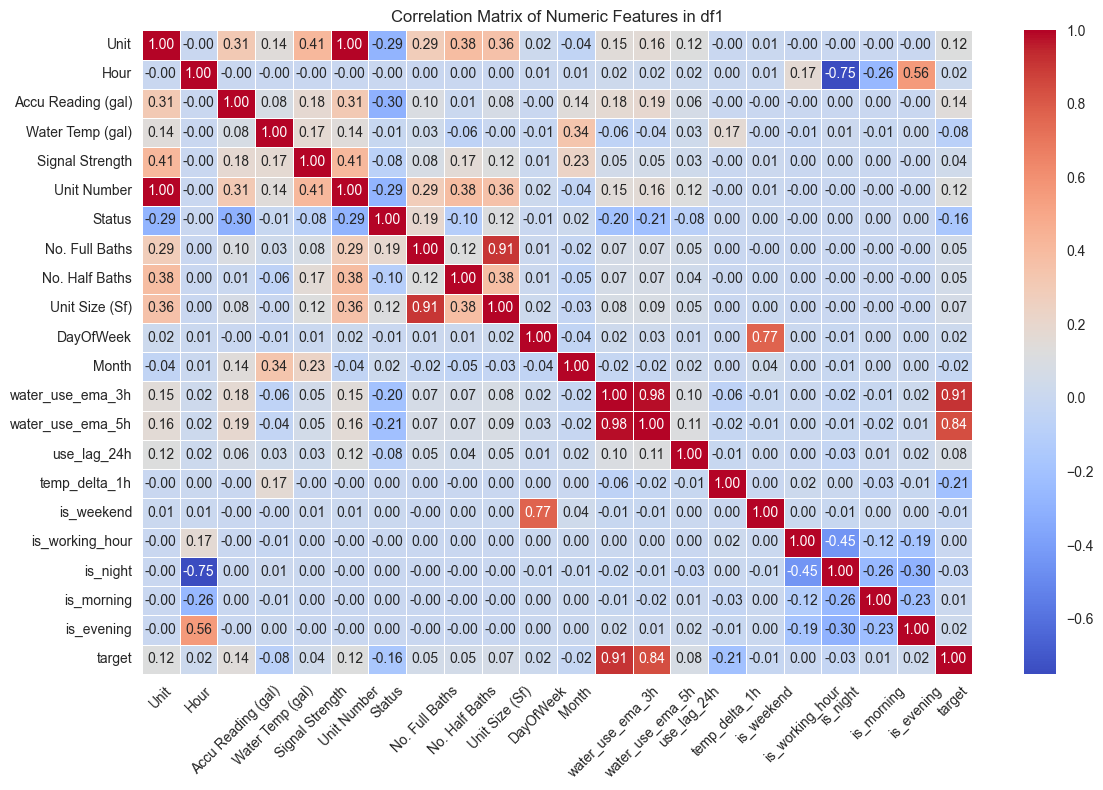

In [261]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Numeric Features in df1")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Level 1 Modelling 

# All ML models w/o log transformation

In [262]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

def evaluate_regressors_with_mape(X_numerical, X_embeddings, y, test_size=0.2, random_state=42):
    # Combine numerical and embedding features
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=test_size, random_state=random_state)

    regressors = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state),
        # "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=random_state),
        "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=random_state),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=random_state),
        "XGBoost": xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state
        )
    }

    results = {}

    for name, model in regressors.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # MAPE (ignore zero targets to avoid division by zero)
        nonzero_mask = y_test != 0
        if np.any(nonzero_mask):
            mape = mean_absolute_percentage_error(y_test[nonzero_mask], y_pred[nonzero_mask]) * 100
        else:
            mape = float('nan')

        results[name] = {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        }

        print(f"\n📊 {name} Performance:")
        print(f"- RMSE: {rmse:.3f}")
        print(f"- MAE:  {mae:.3f}")
        print(f"- R²:   {r2:.3f}")
        print(f"- MAPE: {mape:.2f}%")

    return results


In [263]:
results = evaluate_regressors_with_mape(X_numerical, X_embeddings, y)


📊 Linear Regression Performance:
- RMSE: 2.961
- MAE:  0.772
- R²:   0.935
- MAPE: 31.35%

📊 Random Forest Performance:
- RMSE: 1.161
- MAE:  0.209
- R²:   0.975
- MAPE: 15.29%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 492748, number of used features: 23
[LightGBM] [Info] Start training from score 1.735931

📊 LightGBM Performance:
- RMSE: 2.408
- MAE:  0.335
- R²:   0.947
- MAPE: 22.70%

📊 CatBoost Performance:
- RMSE: 2.258
- MAE:  0.314
- R²:   0.951
- MAPE: 20.28%

📊 XGBoost Performance:
- RMSE: 2.371
- MAE:  0.335
- R²:   0.948
- MAPE: 21.91%


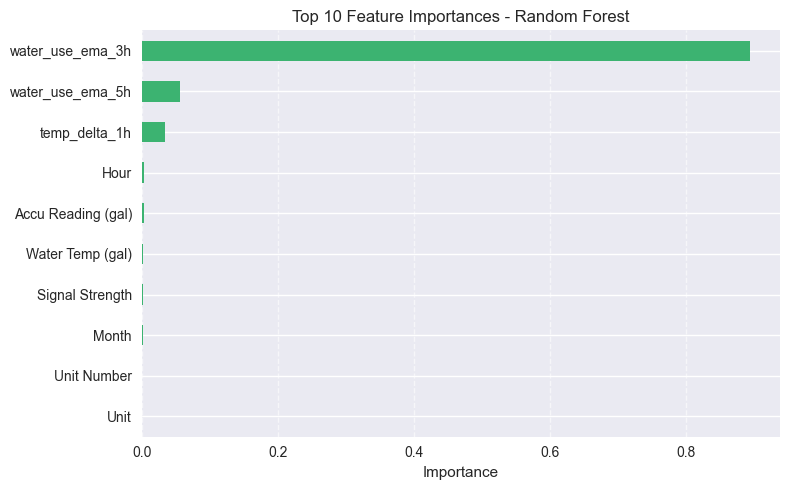

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 492748, number of used features: 23
[LightGBM] [Info] Start training from score 1.735931


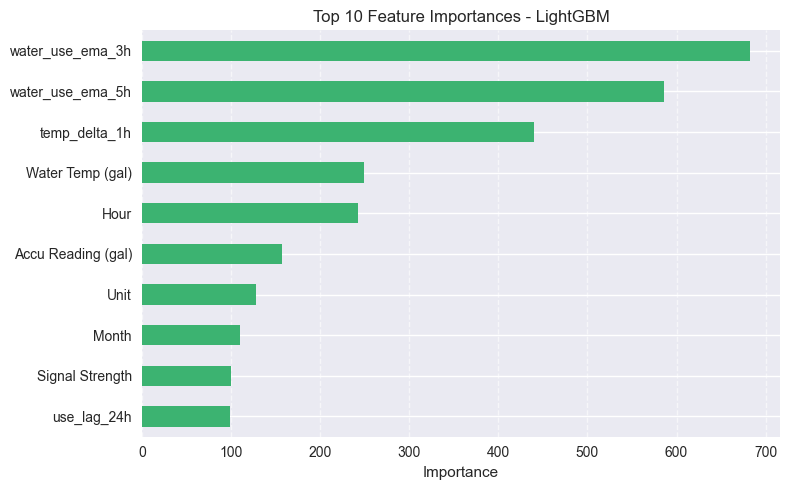

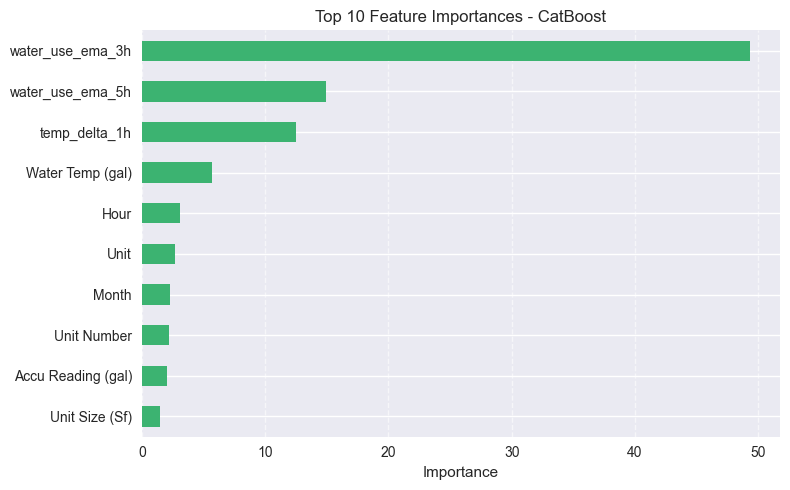

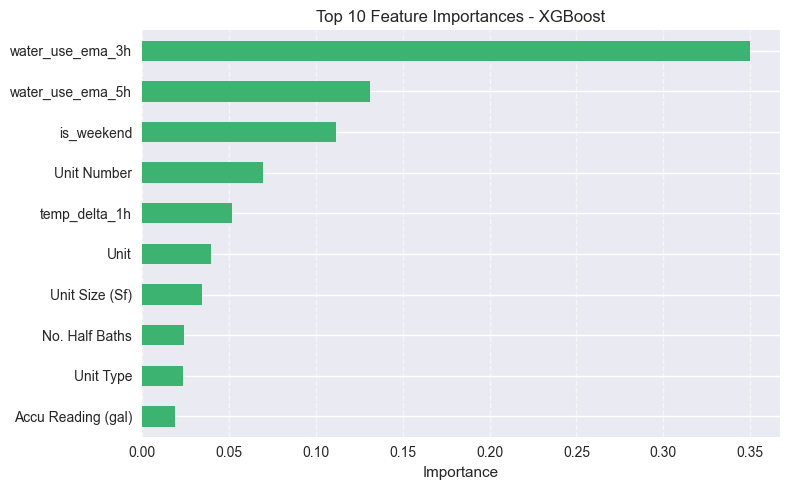

In [264]:

# Combine feature names from numerical and embedding inputs
if X_embeddings:
    embedding_features = list(X_embeddings.keys())
    feature_names = list(X_numerical.columns) + embedding_features
    X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
    X_full = np.hstack([X_numerical.values, X_embed])
else:
    feature_names = list(X_numerical.columns)
    X_full = X_numerical.values

# Refit models to get feature importance (same as earlier, excluding LR)
regressors = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "XGBoost": xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Loop through and plot importances
for name, model in regressors.items():
    model.fit(X_train, y_train)

    # Check and get feature importance
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_series = pd.Series(importances, index=feature_names)
        top_features = importance_series.sort_values(ascending=False).head(10)

        # Plot top 10
        plt.figure(figsize=(8, 5))
        top_features.plot(kind='barh', color='mediumseagreen')
        plt.title(f"Top 10 Feature Importances - {name}")
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


# With log Transformation to handle high frequency of 0

In [132]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def build_xgboost_model(X_numerical, X_embeddings, y, test_size=0.2, random_state=42):
    # Combine numerical and embedding features
    import numpy as np

    # Flatten embedding features and concatenate to numerical
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=test_size, random_state=random_state
    )

    # Define the XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    # rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    y_train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    mask_non_zero = y_test > 0
    mae_non_zero = mean_absolute_error(y_test[mask_non_zero], y_pred[mask_non_zero])
    print(f"MAE on non-zero usage: {mae_non_zero:.2f}")

    
    print(f"\n✅ XGBoost Model Trained")
    print(f"RMSE on Test Set: {rmse:.2f}")
    print(f"RMSE on Train Set: {rmse_train:.2f}")
    print(f"MAE on Test Set: {mae_test:.2f}")
    print(f"MAE on Train Set: {mae_train:.2f}")    
    return model, X_test, y_test, y_pred


In [133]:
results = evaluate_regressors_with_mape(X_numerical, X_embeddings, y)


📊 Linear Regression Performance:
- RMSE: 2.962
- MAE:  0.772
- R²:   0.935
- MAPE: 31.35%

📊 Random Forest Performance:
- RMSE: 1.153
- MAE:  0.209
- R²:   0.975
- MAPE: 15.30%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 492748, number of used features: 22
[LightGBM] [Info] Start training from score 1.735931

📊 LightGBM Performance:
- RMSE: 2.411
- MAE:  0.334
- R²:   0.947
- MAPE: 22.82%

📊 CatBoost Performance:
- RMSE: 2.294
- MAE:  0.314
- R²:   0.950
- MAPE: 20.10%

📊 XGBoost Performance:
- RMSE: 2.517
- MAE:  0.356
- R²:   0.945
- MAPE: 22.23%


In [266]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def build_xgboost_model(X_numerical, X_embeddings, y, test_size=0.2, random_state=42):
    # Combine numerical and embedding features
    import numpy as np

    # Flatten embedding features and concatenate to numerical
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y, test_size=test_size, random_state=random_state
    )

    # Define the XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    # rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    y_train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    r2_test = r2_score(y_test, y_pred)

    mask_non_zero = y_test > 0
    mae_non_zero = mean_absolute_error(y_test[mask_non_zero], y_pred[mask_non_zero])
    print(f"MAE on non-zero usage: {mae_non_zero:.2f}")

    if np.any(mask_non_zero):
        mape_test = mean_absolute_percentage_error(y_test[mask_non_zero], y_pred[mask_non_zero]) * 100
    else:
        mape_test = float('nan')

    
    print(f"\n✅ XGBoost Model Trained")
    print(f"RMSE on Test Set: {rmse:.2f}")
    print(f"RMSE on Train Set: {rmse_train:.2f}")
    print(f"MAE on Test Set: {mae_test:.2f}")
    print(f"MAE on Train Set: {mae_train:.2f}")
    print(f"MAPE on Test Set: {mape_test:.2f}%")
    print(f"R2 on Test Set: {r2_test:.2f}")
    
    

    return model, X_test, y_test, y_pred


In [267]:
model, X_test, y_test, y_pred = build_xgboost_model(X_numerical, X_embeddings, y)

MAE on non-zero usage: 1.48

✅ XGBoost Model Trained
RMSE on Test Set: 1.54
RMSE on Train Set: 1.31
MAE on Test Set: 0.33
MAE on Train Set: 0.32
MAPE on Test Set: 21.91%
R2 on Test Set: 0.95


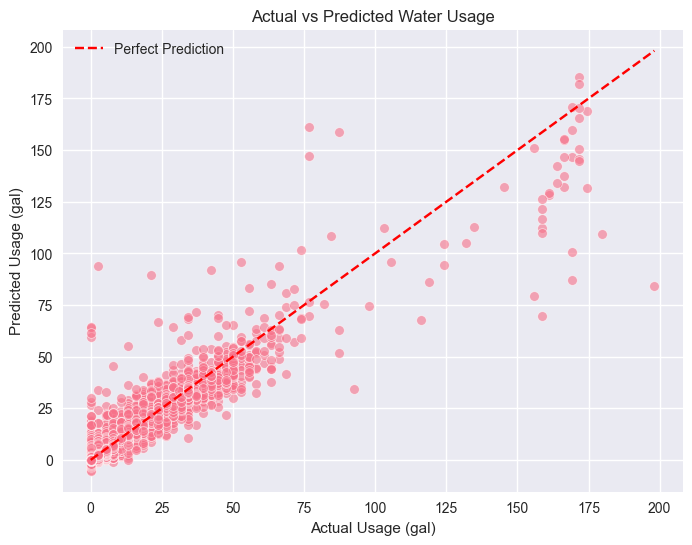

In [268]:
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
    plt.xlabel("Actual Usage (gal)")
    plt.ylabel("Predicted Usage (gal)")
    plt.title("Actual vs Predicted Water Usage")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_predictions(y_test, y_pred)

In [270]:
def plot_feature_importance(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:top_n]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances, y=sorted_features, color='midnightblue')
    plt.title("Top Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


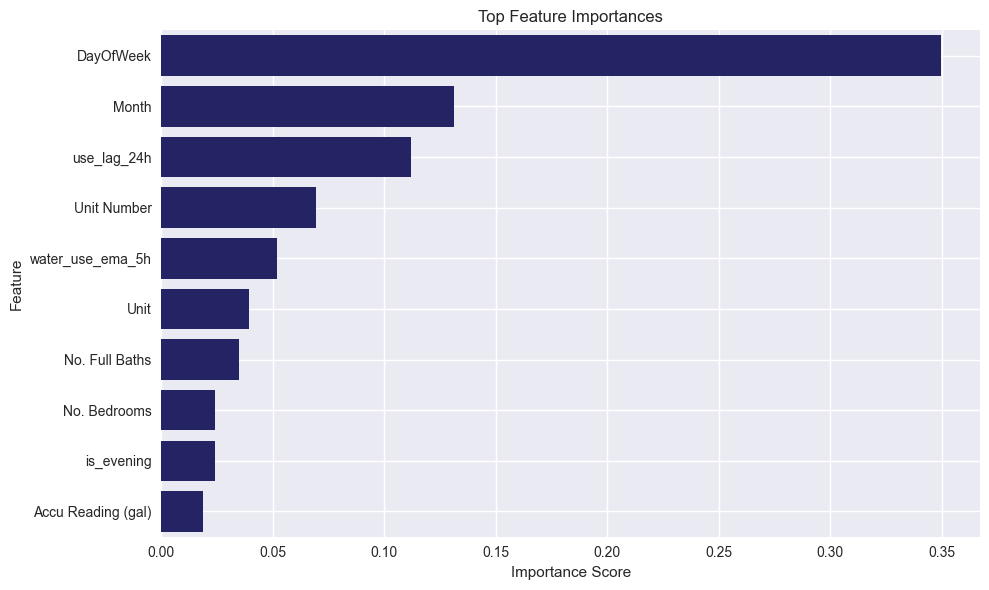

In [271]:
# Combine numerical feature names with embedding names
embed_feature_names = list(X_embeddings.keys())
full_feature_names = numerical_features + embed_feature_names

plot_feature_importance(model, full_feature_names)


In [139]:
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def run_cross_validation_tweedie_with_grid_search(X_numerical, X_embeddings, y, cv=5, random_state=42):
    # Combine features
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    # Define custom RMSE scorer (lower is better)
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error)
    r2_scorer = make_scorer(r2_score)

    # Define parameter grid
    param_grid = {
        'power': [1.1, 1.3, 1.5, 1.7, 1.9],  # Controls zero-inflated behavior
        'alpha': [0.01, 0.1, 0.5, 1.0]       # Regularization strength
    }

    model = TweedieRegressor(link='auto', max_iter=1000)

    # Set up cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # Grid SearchCV
    grid = GridSearchCV(
        model,
        param_grid,
        cv=kf,
        scoring=rmse_scorer,
        n_jobs=-1
    )
    
    grid.fit(X_full, y)

    # Get best model
    best_model = grid.best_estimator_

    # Cross-validate best model for final metrics
    rmse_scores = -cross_val_score(best_model, X_full, y, cv=kf, scoring=rmse_scorer)
    mae_scores = cross_val_score(best_model, X_full, y, cv=kf, scoring=mae_scorer)
    r2_scores = cross_val_score(best_model, X_full, y, cv=kf, scoring=r2_scorer)

    # Print results
    print("✅ Tweedie Regressor with Grid Search:")
    print(f"Best Params: {grid.best_params_}")
    print(f"- RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"- MAE:  {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")
    print(f"- R²:   {r2_scores.mean():.2f} ± {r2_scores.std():.2f}")


In [140]:
run_cross_validation_tweedie_with_grid_search(X_numerical, X_embeddings, y, cv=5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pac

✅ Tweedie Regressor with Grid Search:
Best Params: {'alpha': 0.01, 'power': 1.1}
- RMSE: 6.82 ± 0.07
- MAE:  2.92 ± 0.01
- R²:   -0.00 ± 0.00


In [141]:
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def run_cross_validation_tweedie_with_grid_search_nonzero(X_numerical, X_embeddings, y, cv=5, random_state=42):
    # Combine features
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    # Define param grid
    param_grid = {
        'power': [1.1, 1.3, 1.5, 1.7, 1.9],  # Tweedie power (1 = Poisson, 2 = Gamma)
        'alpha': [0.01, 0.1, 0.5, 1.0]      # Regularization strength
    }

    model = TweedieRegressor(link='auto', max_iter=1000)

    # RMSE scorer (negated for GridSearchCV)
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_scorer = make_scorer(rmse, greater_is_better=False)

    # Grid search
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid = GridSearchCV(model, param_grid, cv=kf, scoring=rmse_scorer, n_jobs=-1)
    grid.fit(X_full, y)
    best_model = grid.best_estimator_

    # Metrics containers
    rmse_all, mae_all, r2_all = [], [], []
    rmse_nonzero, mae_nonzero, r2_nonzero = [], [], []

    # Manual CV evaluation for non-zero tracking
    for train_idx, test_idx in kf.split(X_full):
        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        # All samples
        rmse_all.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        mae_all.append(mean_absolute_error(y_test, y_pred))
        r2_all.append(r2_score(y_test, y_pred))

        # Non-zero samples
        mask_nz = y_test > 0
        if np.any(mask_nz):
            y_test_nz = y_test[mask_nz]
            y_pred_nz = y_pred[mask_nz]
            rmse_nonzero.append(np.sqrt(mean_squared_error(y_test_nz, y_pred_nz)))
            mae_nonzero.append(mean_absolute_error(y_test_nz, y_pred_nz))
            r2_nonzero.append(r2_score(y_test_nz, y_pred_nz))
        else:
            rmse_nonzero.append(np.nan)
            mae_nonzero.append(np.nan)
            r2_nonzero.append(np.nan)

    # Summary stats
    def stats(arr): return np.nanmean(arr), np.nanstd(arr)

    print("✅ Tweedie Regressor with Grid Search & Non-Zero Evaluation:")
    print(f"Best Params: {grid.best_params_}\n")

    # All data
    mean_rmse, std_rmse = stats(rmse_all)
    mean_mae, std_mae = stats(mae_all)
    mean_r2, std_r2 = stats(r2_all)

    print("📉 All Test Samples:")
    print(f"- RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
    print(f"- MAE:  {mean_mae:.3f} ± {std_mae:.3f}")
    print(f"- R²:   {mean_r2:.3f} ± {std_r2:.3f}\n")

    # Non-zero data
    mean_rmse_nz, std_rmse_nz = stats(rmse_nonzero)
    mean_mae_nz, std_mae_nz = stats(mae_nonzero)
    mean_r2_nz, std_r2_nz = stats(r2_nonzero)

    print("💧 Non-Zero Test Samples:")
    print(f"- RMSE: {mean_rmse_nz:.3f} ± {std_rmse_nz:.3f}")
    print(f"- MAE:  {mean_mae_nz:.3f} ± {std_mae_nz:.3f}")
    print(f"- R²:   {mean_r2_nz:.3f} ± {std_r2_nz:.3f}")


In [142]:
run_cross_validation_tweedie_with_grid_search_nonzero(X_numerical, X_embeddings, y, cv=5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pac

✅ Tweedie Regressor with Grid Search & Non-Zero Evaluation:
Best Params: {'alpha': 0.01, 'power': 1.1}

📉 All Test Samples:
- RMSE: 6.824 ± 0.069
- MAE:  2.918 ± 0.012
- R²:   -0.000 ± 0.000

💧 Non-Zero Test Samples:
- RMSE: 16.688 ± 0.188
- MAE:  9.230 ± 0.075
- R²:   -0.440 ± 0.008


In [143]:
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

def run_log_transformed_tweedie(X_numerical, X_embeddings, y, cv=5, random_state=42, test_size=0.2):
    # Combine features
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    # Apply log1p transform to y
    y_log = np.log1p(y)

    # Train/test split
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_full, y_log, test_size=test_size, random_state=random_state
    )

    # Define scoring metrics
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error)
    r2_scorer = make_scorer(r2_score)

    # Grid search params
    param_grid = {
        'power': [1.1, 1.3, 1.5],
        'alpha': [0.01, 0.1, 0.5]
    }

    model = TweedieRegressor(link='auto', max_iter=1000)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    grid = GridSearchCV(model, param_grid, cv=kf, scoring=rmse_scorer, n_jobs=-1)
    grid.fit(X_train, y_train_log)
    best_model = grid.best_estimator_

    # Predict log(y) and inverse-transform
    y_pred_log = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(y_test_log)

    # Metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # Results
    print("✅ Log-Transformed Tweedie Regressor with Grid Search")
    print(f"Best Params: {grid.best_params_}")
    print("📊 Evaluation on Inverse-Transformed Test Set:")
    print(f"- RMSE: {test_rmse:.2f}")
    print(f"- MAE:  {test_mae:.2f}")
    print(f"- R²:   {test_r2:.2f}")

    # Plot predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
    plt.xlabel("Actual Water Usage")
    plt.ylabel("Predicted Water Usage")
    plt.title("Predictions vs Actual (Log-Transformed Model)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Save model (fitted on log(y))
    # joblib.dump(best_model, "tweedie_log_model.pkl")

    return best_model


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/

✅ Log-Transformed Tweedie Regressor with Grid Search
Best Params: {'alpha': 0.01, 'power': 1.1}
📊 Evaluation on Inverse-Transformed Test Set:
- RMSE: 6.89
- MAE:  1.98
- R²:   -0.04


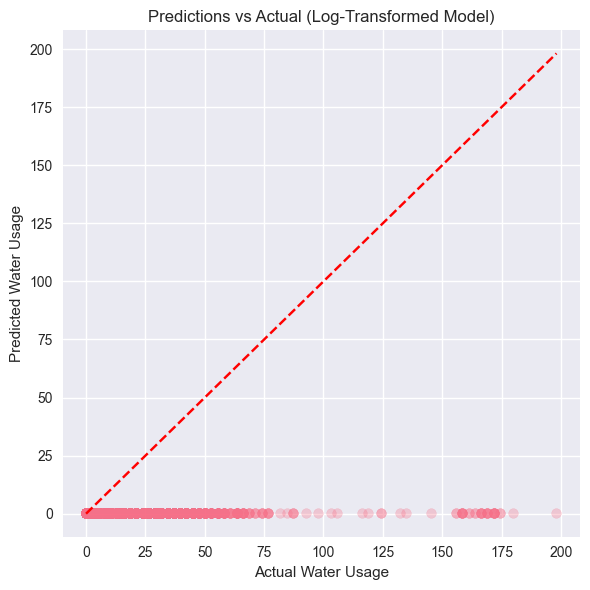

In [144]:
model = run_log_transformed_tweedie(X_numerical, X_embeddings, y)


In [145]:
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

def run_log_transformed_tweedie_with_nonzero_eval(X_numerical, X_embeddings, y, cv=5, random_state=42, test_size=0.2):
    # Combine features
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    # Apply log1p transform to y
    y_log = np.log1p(y)

    # Train/test split
    X_train, X_test, y_train_log, y_test_log = train_test_split(
        X_full, y_log, test_size=test_size, random_state=random_state
    )

    # Define scoring metrics
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    rmse_scorer = make_scorer(rmse, greater_is_better=False)
    param_grid = {
        'power': [1.1, 1.3, 1.5],
        'alpha': [0.01, 0.1, 0.5]
    }

    model = TweedieRegressor(link='auto', max_iter=1000)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid = GridSearchCV(model, param_grid, cv=kf, scoring=rmse_scorer, n_jobs=-1)
    grid.fit(X_train, y_train_log)
    best_model = grid.best_estimator_

    # Predict and inverse transform
    y_pred_log = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(y_test_log)

    # ----- ALL TEST SAMPLES -----
    test_rmse = rmse(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # ----- NON-ZERO TEST SAMPLES -----
    mask_nonzero = y_test > 0
    if np.any(mask_nonzero):
        y_test_nz = y_test[mask_nonzero]
        y_pred_nz = y_pred[mask_nonzero]
        test_rmse_nz = rmse(y_test_nz, y_pred_nz)
        test_mae_nz = mean_absolute_error(y_test_nz, y_pred_nz)
        test_r2_nz = r2_score(y_test_nz, y_pred_nz)
    else:
        test_rmse_nz = test_mae_nz = test_r2_nz = np.nan

    # Results
    print("✅ Log-Transformed Tweedie Regressor with Grid Search")
    print(f"Best Params: {grid.best_params_}\n")

    print("📊 Evaluation on ALL Test Samples:")
    print(f"- RMSE: {test_rmse:.2f}")
    print(f"- MAE:  {test_mae:.2f}")
    print(f"- R²:   {test_r2:.2f}\n")

    print("💧 Evaluation on NON-ZERO Test Samples:")
    print(f"- RMSE: {test_rmse_nz:.2f}")
    print(f"- MAE:  {test_mae_nz:.2f}")
    print(f"- R²:   {test_r2_nz:.2f}")

    # Plot predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
    plt.xlabel("Actual Water Usage")
    plt.ylabel("Predicted Water Usage")
    plt.title("Predictions vs Actual (Log-Transformed Model)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Save the trained model
    # joblib.dump(best_model, "tweedie_log_model.pkl")

    return best_model


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/

✅ Log-Transformed Tweedie Regressor with Grid Search
Best Params: {'alpha': 0.01, 'power': 1.1}

📊 Evaluation on ALL Test Samples:
- RMSE: 6.89
- MAE:  1.98
- R²:   -0.04

💧 Evaluation on NON-ZERO Test Samples:
- RMSE: 17.34
- MAE:  10.54
- R²:   -0.59


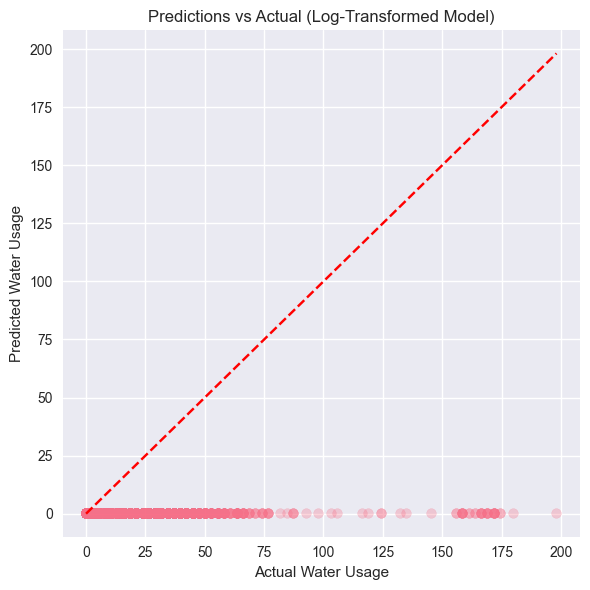

In [146]:
model = run_log_transformed_tweedie_with_nonzero_eval(X_numerical, X_embeddings, y)


# Level 2: Two stage Model with NearMiss to handle class imbalance

# Random Forest for Classification with different ML models for regression

In [272]:
from imblearn.under_sampling import NearMiss
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    mean_squared_error, mean_absolute_error,
    r2_score, mean_absolute_percentage_error
)
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

def two_stage_cv_with_nearmiss_multiple_regressors(X_numerical, X_embeddings, y, cv=5, random_state=42):
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    y_binary = (y > 0).astype(int)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    regressors = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=random_state),
        "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=random_state),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=random_state),
        "XGBoost": xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state
        )
    }

    all_metrics = {name: {
        'rmse': [], 'mae': [], 'r2': [], 'mape': [], 'mae_nonzero': []
    } for name in regressors}

    acc_scores = []
    fold = 1

    for train_idx, test_idx in kf.split(X_full):
        print(f"\n📂 Fold {fold}")

        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        y_train_bin, y_test_bin = y_binary[train_idx], y_binary[test_idx]

        # Classifier with NearMiss
        nm = NearMiss(version=1)
        X_train_clf, y_train_bin_clf = nm.fit_resample(X_train, y_train_bin)
        clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        clf.fit(X_train_clf, y_train_bin_clf)
        y_test_bin_pred = clf.predict(X_test)

        acc = accuracy_score(y_test_bin, y_test_bin_pred)
        acc_scores.append(acc)
        print(f"Stage 1 - Classifier Accuracy: {acc:.3f}")

        # Plot confusion matrix
        cm = confusion_matrix(y_test_bin, y_test_bin_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Fold {fold} - Confusion Matrix')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Regression stage for each model
        train_mask = y_train > 0
        X_train_reg = X_train[train_mask]
        y_train_reg = y_train[train_mask]

        reg_indices = np.where(y_test_bin_pred == 1)[0]
        X_test_reg = X_test[reg_indices] if len(reg_indices) > 0 else None

        for name, reg_model in regressors.items():
            if len(reg_indices) == 0:
                print(f"⚠️  {name} skipped (no predicted positives in test set)")
                continue

            reg_model.fit(X_train_reg, y_train_reg)
            y_test_pred = np.zeros_like(y_test, dtype=float)
            y_test_pred[reg_indices] = reg_model.predict(X_test_reg)

            y_test_pred = np.clip(y_test_pred, 0, None)

            rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            mae = mean_absolute_error(y_test, y_test_pred)
            r2 = r2_score(y_test, y_test_pred)

            nonzero_mask = y_test > 0
            if np.any(nonzero_mask):
                mape = mean_absolute_percentage_error(y_test[nonzero_mask], y_test_pred[nonzero_mask]) * 100
                mae_nonzero = mean_absolute_error(y_test[nonzero_mask], y_test_pred[nonzero_mask])
            else:
                mape = float('nan')
                mae_nonzero = float('nan')

            all_metrics[name]['rmse'].append(rmse)
            all_metrics[name]['mae'].append(mae)
            all_metrics[name]['r2'].append(r2)
            all_metrics[name]['mape'].append(mape)
            all_metrics[name]['mae_nonzero'].append(mae_nonzero)

            print(f"Stage 2 - {name} Performance:")
            print(f"- RMSE: {rmse:.3f}")
            print(f"- MAE:  {mae:.3f}")
            print(f"- R²:   {r2:.3f}")
            print(f"- MAPE: {mape:.2f}%")

        fold += 1

    # Summary
    print("\n✅ Cross-Validation Summary with NearMiss & Multiple Regressors:")
    print(f"Classifier Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")

    for name, metrics in all_metrics.items():
        print(f"\n📈 {name} Summary:")
        for metric in ['rmse', 'mae', 'r2', 'mape', 'mae_nonzero']:
            values = np.array(metrics[metric])
            if len(values) > 0:
                print(f"- {metric.upper()}: {np.nanmean(values):.3f} ± {np.nanstd(values):.3f}")

    return acc_scores, all_metrics



📂 Fold 1
Stage 1 - Classifier Accuracy: 0.933


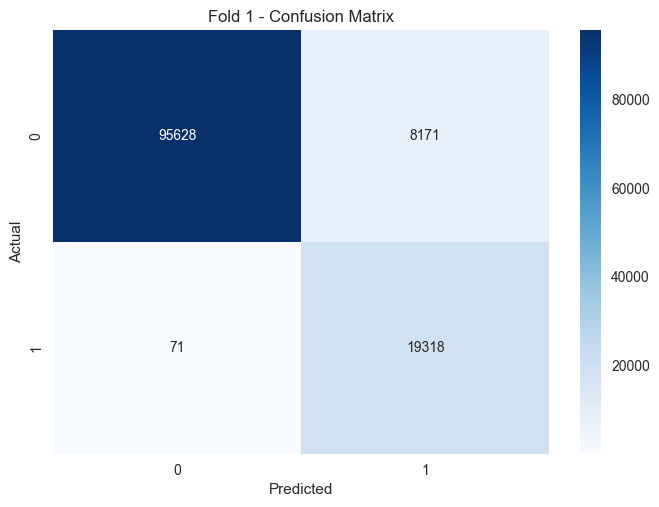

Stage 2 - Linear Regression Performance:
- RMSE: 1.561
- MAE:  0.442
- R²:   0.947
- MAPE: 31.65%
Stage 2 - Random Forest Performance:
- RMSE: 1.356
- MAE:  0.353
- R²:   0.960
- MAPE: 11.99%
Stage 2 - Gradient Boosting Performance:
- RMSE: 1.675
- MAE:  0.485
- R²:   0.939
- MAPE: 22.63%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 78026, number of used features: 23
[LightGBM] [Info] Start training from score 10.962710
Stage 2 - LightGBM Performance:
- RMSE: 1.660
- MAE:  0.404
- R²:   0.940
- MAPE: 16.41%
Stage 2 - CatBoost Performance:
- RMSE: 1.563
- MAE:  0.369
- R²:   0.947
- MAPE: 14.85%
Stage 2 - XGBoost Performance:
- RMSE: 1.620
- MAE:  0.403
- R²:   0.943
- MAPE: 16.32%

📂 Fold 2
Stage 1 - Classifier Accura

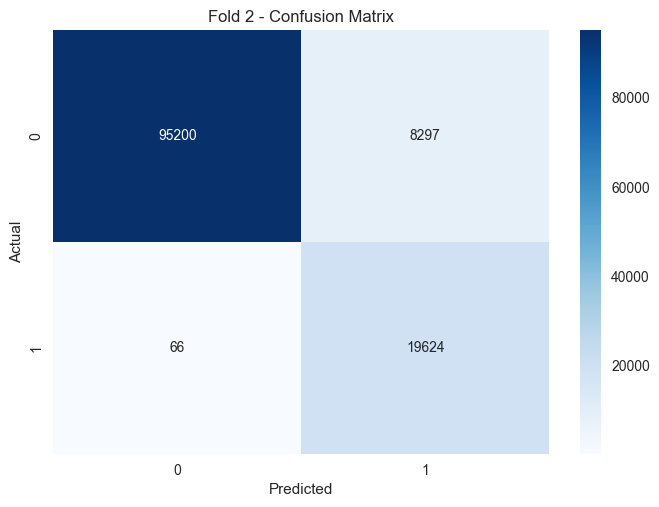

Stage 2 - Linear Regression Performance:
- RMSE: 1.576
- MAE:  0.450
- R²:   0.947
- MAPE: 31.17%
Stage 2 - Random Forest Performance:
- RMSE: 1.339
- MAE:  0.361
- R²:   0.962
- MAPE: 11.77%
Stage 2 - Gradient Boosting Performance:
- RMSE: 1.720
- MAE:  0.497
- R²:   0.937
- MAPE: 22.17%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 77725, number of used features: 23
[LightGBM] [Info] Start training from score 10.943193
Stage 2 - LightGBM Performance:
- RMSE: 1.801
- MAE:  0.416
- R²:   0.931
- MAPE: 16.14%
Stage 2 - CatBoost Performance:
- RMSE: 1.691
- MAE:  0.384
- R²:   0.939
- MAPE: 15.16%
Stage 2 - XGBoost Performance:
- RMSE: 1.731
- MAE:  0.415
- R²:   0.936
- MAPE: 16.26%

📂 Fold 3
Stage 1 - Classifier Accura

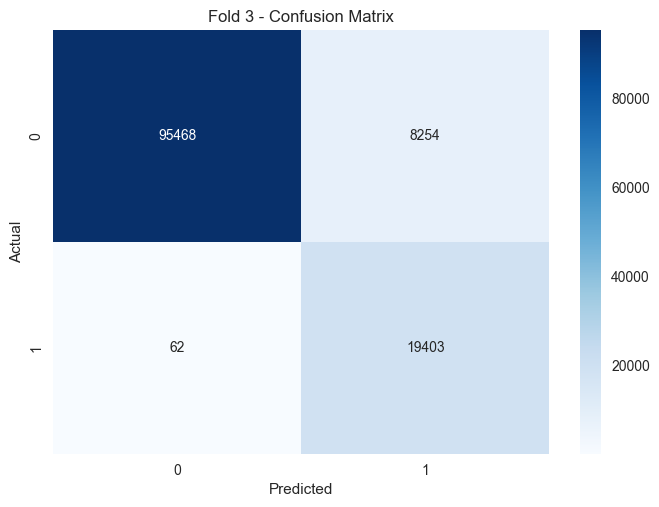

Stage 2 - Linear Regression Performance:
- RMSE: 1.576
- MAE:  0.443
- R²:   0.948
- MAPE: 31.17%
Stage 2 - Random Forest Performance:
- RMSE: 1.353
- MAE:  0.356
- R²:   0.962
- MAPE: 11.90%
Stage 2 - Gradient Boosting Performance:
- RMSE: 1.718
- MAE:  0.498
- R²:   0.939
- MAPE: 22.97%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2320
[LightGBM] [Info] Number of data points in the train set: 77950, number of used features: 23
[LightGBM] [Info] Start training from score 10.927606
Stage 2 - LightGBM Performance:
- RMSE: 1.836
- MAE:  0.414
- R²:   0.930
- MAPE: 16.43%
Stage 2 - CatBoost Performance:
- RMSE: 1.727
- MAE:  0.380
- R²:   0.938
- MAPE: 15.10%
Stage 2 - XGBoost Performance:
- RMSE: 1.793
- MAE:  0.416
- R²:   0.933
- MAPE: 16.91%

📂 Fold 4
Stage 1 - Classifier Accura

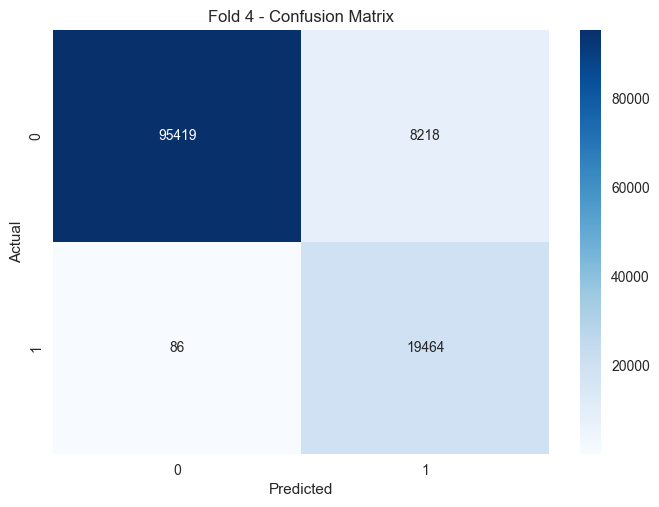

Stage 2 - Linear Regression Performance:
- RMSE: 1.573
- MAE:  0.444
- R²:   0.945
- MAPE: 31.20%
Stage 2 - Random Forest Performance:
- RMSE: 1.479
- MAE:  0.362
- R²:   0.952
- MAPE: 12.17%
Stage 2 - Gradient Boosting Performance:
- RMSE: 1.785
- MAE:  0.495
- R²:   0.930
- MAPE: 22.61%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2326
[LightGBM] [Info] Number of data points in the train set: 77865, number of used features: 23
[LightGBM] [Info] Start training from score 10.982024
Stage 2 - LightGBM Performance:
- RMSE: 1.804
- MAE:  0.411
- R²:   0.928
- MAPE: 16.27%
Stage 2 - CatBoost Performance:
- RMSE: 1.737
- MAE:  0.380
- R²:   0.934
- MAPE: 15.14%
Stage 2 - XGBoost Performance:
- RMSE: 1.842
- MAE:  0.412
- R²:   0.925
- MAPE: 16.48%

📂 Fold 5
Stage 1 - Classifier Accura

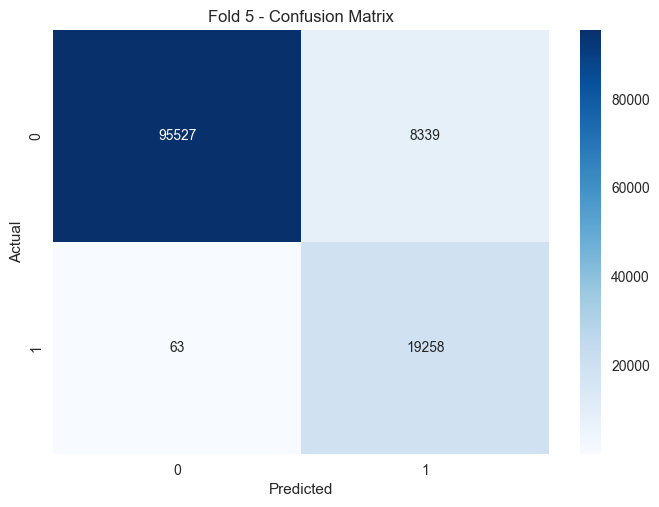

Stage 2 - Linear Regression Performance:
- RMSE: 1.525
- MAE:  0.439
- R²:   0.950
- MAPE: 31.51%
Stage 2 - Random Forest Performance:
- RMSE: 1.292
- MAE:  0.353
- R²:   0.964
- MAPE: 11.87%
Stage 2 - Gradient Boosting Performance:
- RMSE: 1.656
- MAE:  0.486
- R²:   0.942
- MAPE: 22.09%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 78094, number of used features: 23
[LightGBM] [Info] Start training from score 10.957245
Stage 2 - LightGBM Performance:
- RMSE: 1.688
- MAE:  0.409
- R²:   0.939
- MAPE: 16.58%
Stage 2 - CatBoost Performance:
- RMSE: 1.693
- MAE:  0.378
- R²:   0.939
- MAPE: 15.35%
Stage 2 - XGBoost Performance:
- RMSE: 1.748
- MAE:  0.412
- R²:   0.935
- MAPE: 16.63%

✅ Cross-Validation Summary with Near

In [273]:
acc_scores, all_metrics = two_stage_cv_with_nearmiss_multiple_regressors(X_numerical, X_embeddings, y)


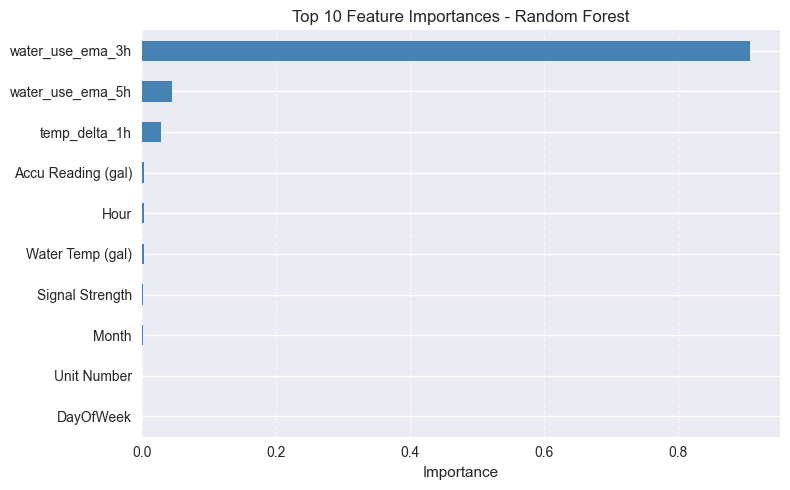

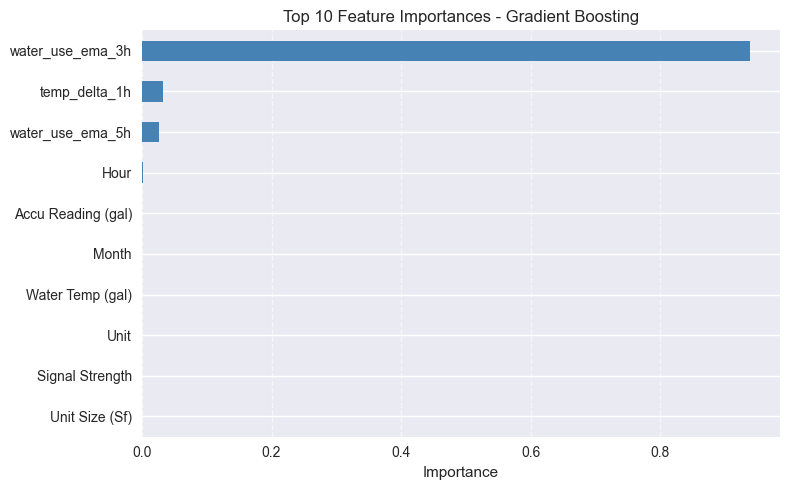

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 97415, number of used features: 23
[LightGBM] [Info] Start training from score 10.954559


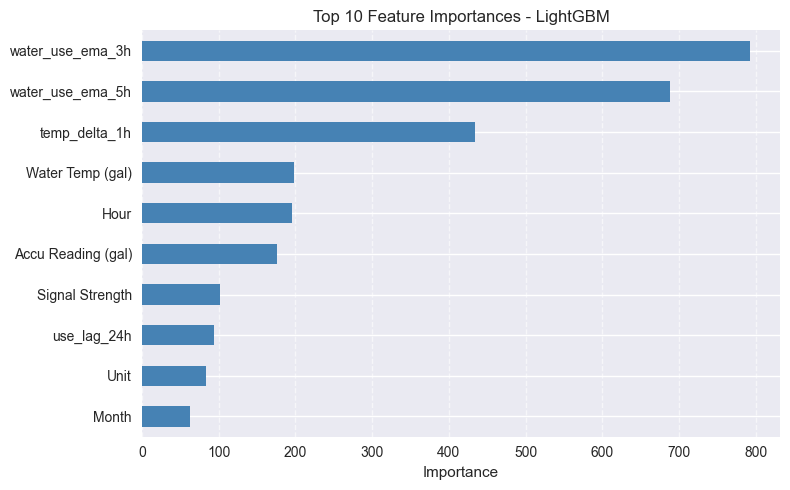

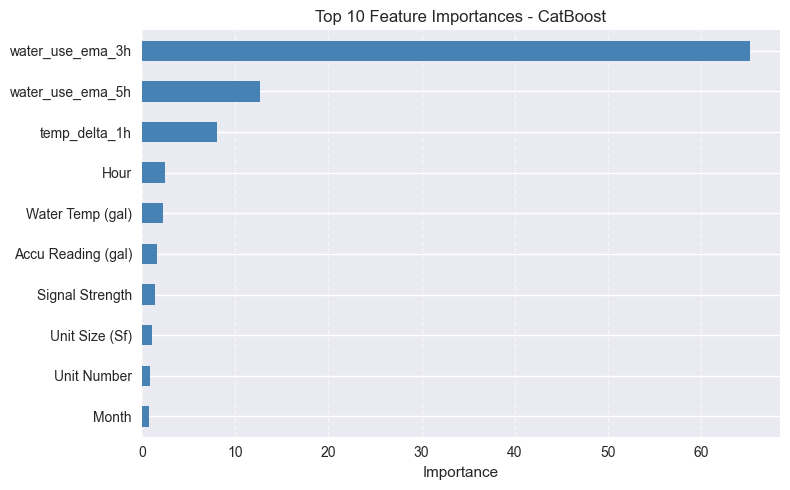

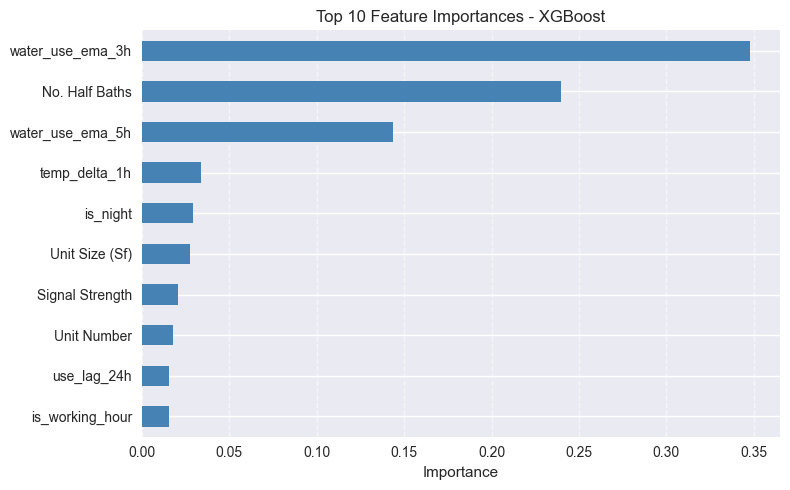

In [277]:
# Combine feature names from numerical and embedding inputs
if X_embeddings:
    X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
    feature_names = list(X_numerical.columns) + list(X_embeddings.keys())
    X_full = np.hstack([X_numerical.values, X_embed])
else:
    feature_names = list(X_numerical.columns)
    X_full = X_numerical.values

# Create the same regression models again (except Linear Regression)
regressors = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "XGBoost": xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# Prepare regression data for training (non-zero targets)
y_binary = (y > 0).astype(int)
X_train_reg = X_full[y_binary == 1]
y_train_reg = y[y_binary == 1]

# Fit models and plot feature importances
import pandas as pd
import matplotlib.pyplot as plt

for name, model in regressors.items():
    model.fit(X_train_reg, y_train_reg)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

        # Plot
        plt.figure(figsize=(8, 5))
        top_features.plot(kind='barh', color='steelblue')
        plt.title(f"Top 10 Feature Importances - {name}")
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


In [278]:
from imblearn.under_sampling import NearMiss
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import xgboost as xgb

# 🔍 Tune RandomForestClassifier on balanced (undersampled) data
def tune_classifier(X_clf, y_clf, random_state=42):
    param_dist = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    clf = RandomForestClassifier(random_state=random_state)
    search = RandomizedSearchCV(
        clf, param_distributions=param_dist,
        n_iter=10, scoring='accuracy', cv=3, n_jobs=-1,
        random_state=random_state, verbose=0
    )
    search.fit(X_clf, y_clf)
    print("✅ Best RandomForestClassifier params:", search.best_params_)
    return search.best_params_

# 🔍 Tune XGBRegressor on non-zero data
def tune_regressor(X_reg, y_reg, random_state=42):
    param_dist = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)
    search = RandomizedSearchCV(
        reg, param_distributions=param_dist,
        n_iter=10, scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, random_state=random_state, verbose=0
    )
    search.fit(X_reg, y_reg)
    print("✅ Best XGBRegressor params:", search.best_params_)
    return search.best_params_

# 📦 Main function with hyperparameter tuning + CV
def two_stage_cv_with_nearmiss_ht(X_numerical, X_embeddings, y, cv=5, random_state=42):
    if X_embeddings:
        X_embed = np.column_stack([X_embeddings[col] for col in X_embeddings])
        X_full = np.hstack([X_numerical.values, X_embed])
    else:
        X_full = X_numerical.values

    y_binary = (y > 0).astype(int)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    acc_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    mae_nonzero_scores = []

    # 🧪 Prepare samples for tuning (balanced and non-zero subsets)
    # → Classifier: NearMiss on binary y
    nm = NearMiss(version=1)
    X_clf_sample, y_clf_sample = nm.fit_resample(X_full, y_binary)

    # → Regressor: non-zero samples
    mask_reg = y > 0
    X_reg_sample, y_reg_sample = X_full[mask_reg], y[mask_reg]

    # Optional downsample for speed:
    X_reg_sample, _, y_reg_sample, _ = train_test_split(
        X_reg_sample, y_reg_sample, train_size=0.5, random_state=random_state
    )

    # 🔧 Tune both models
    best_clf_params = tune_classifier(X_clf_sample, y_clf_sample, random_state)
    best_reg_params = tune_regressor(X_reg_sample, y_reg_sample, random_state)

    fold = 1
    for train_idx, test_idx in kf.split(X_full):
        print(f"\n📂 Fold {fold}")

        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        y_train_bin, y_test_bin = y_binary[train_idx], y_binary[test_idx]

        # ⚖️ NearMiss for classifier
        nm = NearMiss(version=1)
        X_train_clf, y_train_bin_clf = nm.fit_resample(X_train, y_train_bin)

        print(f"Class balance before NearMiss: {Counter(y_train_bin)}")
        print(f"Class balance after NearMiss:  {Counter(y_train_bin_clf)}")

        # 🔁 Stage 1: Classification
        clf = RandomForestClassifier(random_state=random_state, **best_clf_params)
        clf.fit(X_train_clf, y_train_bin_clf)
        y_test_bin_pred = clf.predict(X_test)

        acc = accuracy_score(y_test_bin, y_test_bin_pred)
        acc_scores.append(acc)
        print(f"Stage 1 - Classifier Accuracy: {acc:.3f}")

        # Confusion Matrix
        cm = confusion_matrix(y_test_bin, y_test_bin_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Fold {fold} - Confusion Matrix')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # 🔁 Stage 2: Regression on non-zero
        train_mask = y_train > 0
        X_train_reg = X_train[train_mask]
        y_train_reg = y_train[train_mask]

        reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state, **best_reg_params)
        reg.fit(X_train_reg, y_train_reg)

        y_test_pred = np.zeros_like(y_test, dtype=float)
        reg_indices = np.where(y_test_bin_pred == 1)[0]
        if len(reg_indices) > 0:
            X_test_reg = X_test[reg_indices]
            y_test_pred[reg_indices] = reg.predict(X_test_reg)

        y_test_pred = np.clip(y_test_pred, 0, None)

        # 📊 Regression Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae = mean_absolute_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        print(f"Stage 2 - Regression Metrics:")
        print(f"- RMSE: {rmse:.3f}")
        print(f"- MAE:  {mae:.3f}")
        print(f"- R²:   {r2:.3f}")

        nonzero_mask = y_test > 0
        if np.any(nonzero_mask):
            mae_nonzero = mean_absolute_error(y_test[nonzero_mask], y_test_pred[nonzero_mask])
        else:
            mae_nonzero = np.nan
        mae_nonzero_scores.append(mae_nonzero)

        fold += 1

    # 📈 Final Summary
    print("\n✅ Cross-Validation Summary with Full Hyperparameter Tuning:")
    print(f"- Classifier Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
    print(f"- RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}")
    print(f"- MAE:  {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")
    print(f"- R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
    print(f"- MAE (non-zero): {np.mean(mae_nonzero_scores):.3f} ± {np.std(mae_nonzero_scores):.3f}")


✅ Best RandomForestClassifier params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': False}
✅ Best XGBRegressor params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

📂 Fold 1
Class balance before NearMiss: Counter({0: 414722, 1: 78026})
Class balance after NearMiss:  Counter({0: 78026, 1: 78026})
Stage 1 - Classifier Accuracy: 0.924


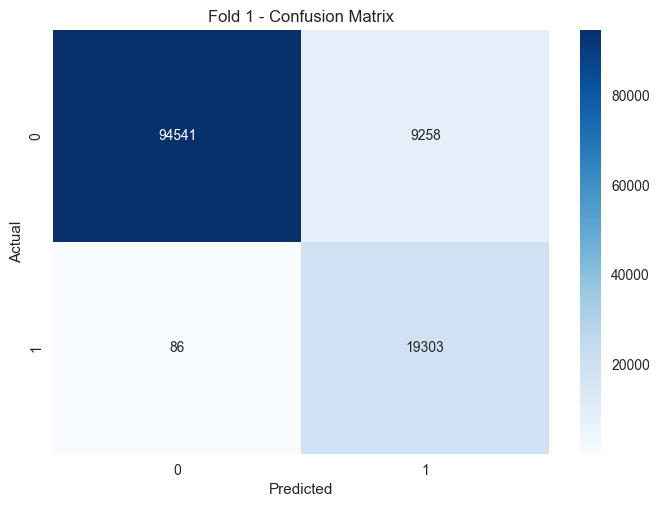

Stage 2 - Regression Metrics:
- RMSE: 1.628
- MAE:  0.402
- R²:   0.942

📂 Fold 2
Class balance before NearMiss: Counter({0: 415024, 1: 77725})
Class balance after NearMiss:  Counter({0: 77725, 1: 77725})
Stage 1 - Classifier Accuracy: 0.923


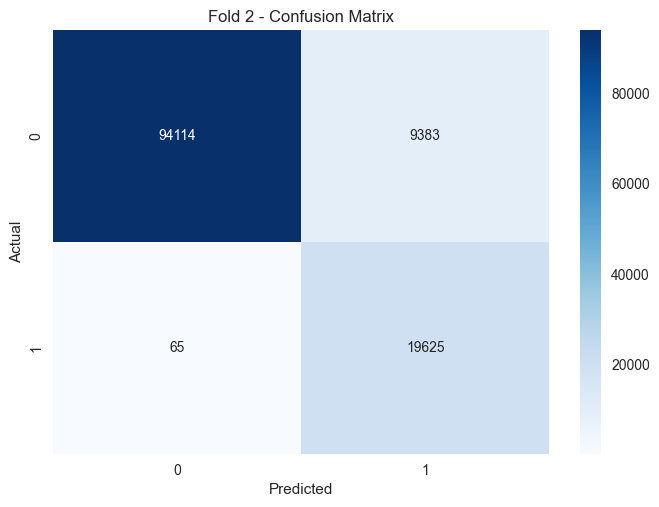

Stage 2 - Regression Metrics:
- RMSE: 1.697
- MAE:  0.412
- R²:   0.939

📂 Fold 3
Class balance before NearMiss: Counter({0: 414799, 1: 77950})
Class balance after NearMiss:  Counter({0: 77950, 1: 77950})
Stage 1 - Classifier Accuracy: 0.924


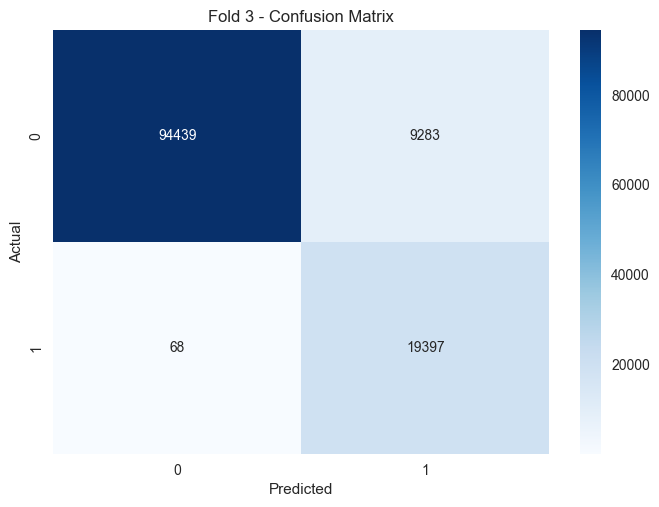

Stage 2 - Regression Metrics:
- RMSE: 1.766
- MAE:  0.410
- R²:   0.935

📂 Fold 4
Class balance before NearMiss: Counter({0: 414884, 1: 77865})
Class balance after NearMiss:  Counter({0: 77865, 1: 77865})
Stage 1 - Classifier Accuracy: 0.923


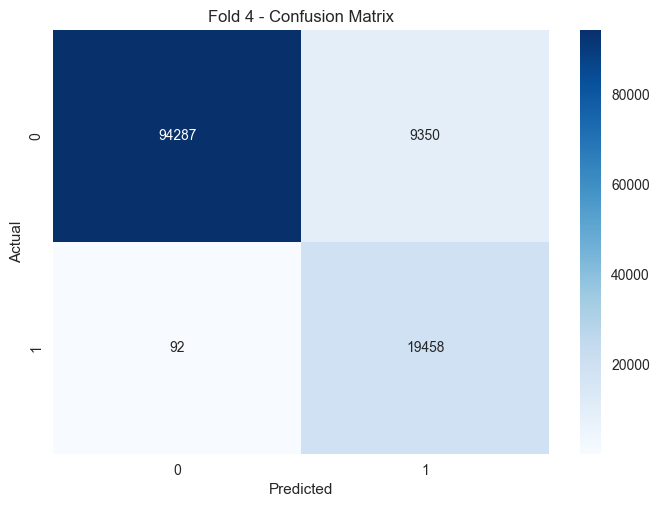

Stage 2 - Regression Metrics:
- RMSE: 1.818
- MAE:  0.414
- R²:   0.927

📂 Fold 5
Class balance before NearMiss: Counter({0: 414655, 1: 78094})
Class balance after NearMiss:  Counter({0: 78094, 1: 78094})
Stage 1 - Classifier Accuracy: 0.924


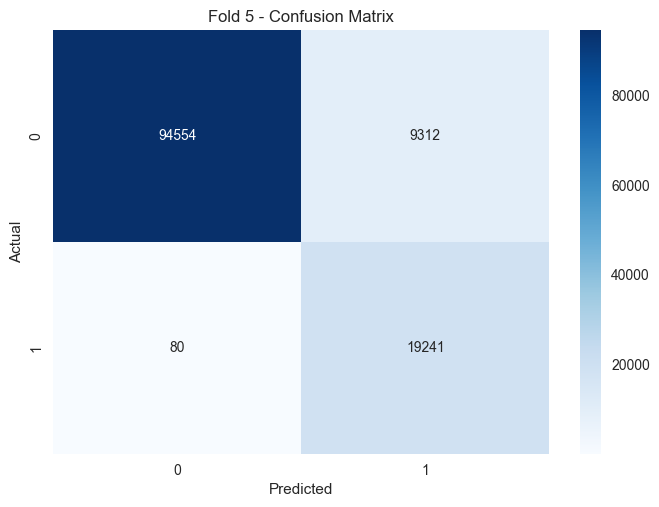

Stage 2 - Regression Metrics:
- RMSE: 1.739
- MAE:  0.408
- R²:   0.936

✅ Cross-Validation Summary with Full Hyperparameter Tuning:
- Classifier Accuracy: 0.924 ± 0.000
- RMSE: 1.730 ± 0.064
- MAE:  0.409 ± 0.004
- R²:   0.936 ± 0.005
- MAE (non-zero): 1.016 ± 0.016


In [279]:
two_stage_cv_with_nearmiss_ht(X_numerical, X_embeddings, y)

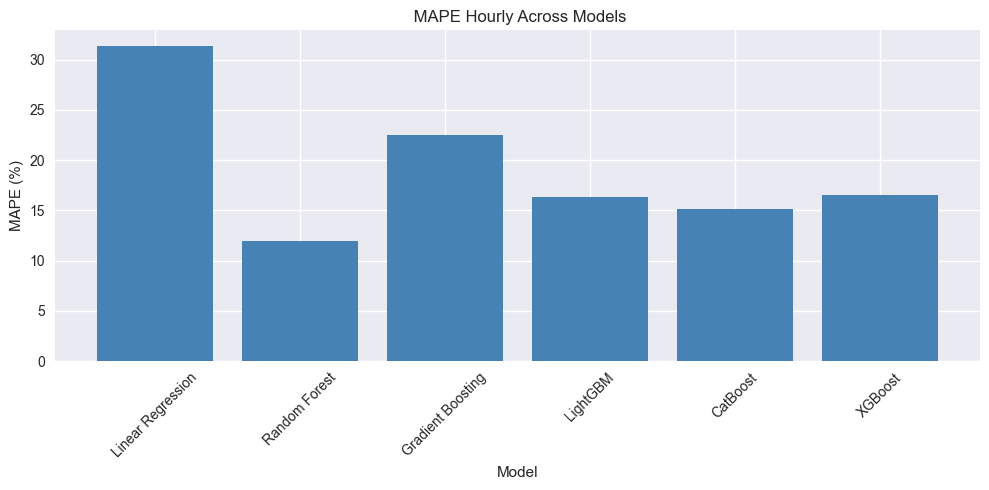

In [280]:
import matplotlib.pyplot as plt

# Choose which metric to plot
metric_to_plot = 'mape'  # or 'mae', 'r2', 'rmse', 'mae_nonzero'

# Prepare data
model_names = []
metric_means = []

for model, metrics in all_metrics.items():
    values = metrics[metric_to_plot]
    if len(values) > 0:
        model_names.append(model)
        metric_means.append(np.nanmean(values))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(model_names, metric_means, color='steelblue')
plt.title(f' {metric_to_plot.upper()} Hourly Across Models')
plt.xlabel('Model')
plt.ylabel(metric_to_plot.upper() + (' (%)'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


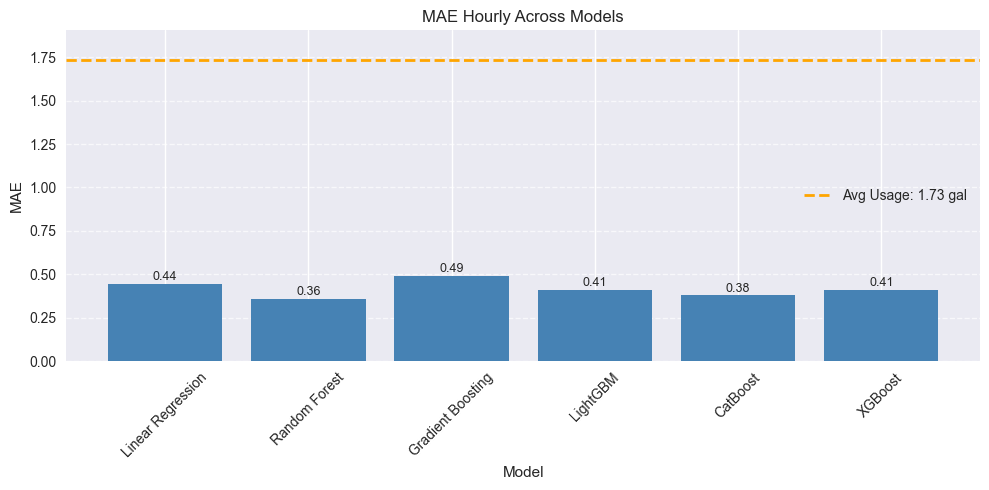

In [281]:
import matplotlib.pyplot as plt
import numpy as np

# Choose which metric to plot
metric_to_plot = 'mae'  # or 'mae', 'r2', 'rmse', 'mae_nonzero'

# Prepare data
model_names = []
metric_means = []

for model, metrics in all_metrics.items():
    values = metrics[metric_to_plot]
    if len(values) > 0:
        model_names.append(model)
        metric_means.append(np.nanmean(values))

# Calculate average water usage
avg_usage = df_processed['Use (gal)'].mean()

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, metric_means, color='steelblue')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}',
             ha='center', va='bottom', fontsize=9)

# Add horizontal line for average usage
plt.axhline(avg_usage, color='orange', linestyle='--', linewidth=2,
            label=f'Avg Usage: {avg_usage:.2f} gal')

# Plot aesthetics
plt.title(f'{metric_to_plot.upper()} Hourly Across Models')
plt.xlabel('Model')
plt.ylabel(metric_to_plot.upper())
plt.xticks(rotation=45)
plt.ylim(0, max(metric_means + [avg_usage]) + 0.1 * max(metric_means + [avg_usage]))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


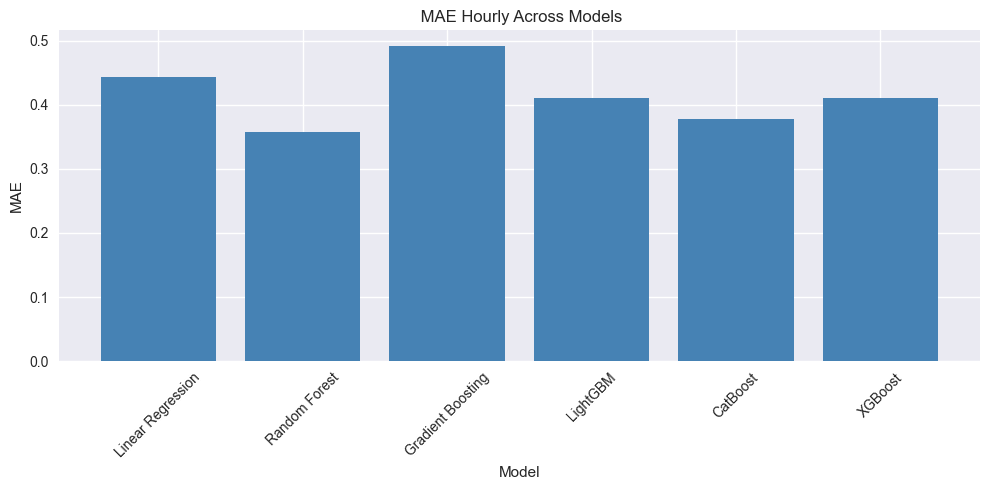

In [282]:
import matplotlib.pyplot as plt

# Choose which metric to plot
metric_to_plot = 'mae'  # or 'mae', 'r2', 'rmse', 'mae_nonzero'

# Prepare data
model_names = []
metric_means = []

for model, metrics in all_metrics.items():
    values = metrics[metric_to_plot]
    if len(values) > 0:
        model_names.append(model)
        metric_means.append(np.nanmean(values))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(model_names, metric_means, color='steelblue')
plt.title(f' {metric_to_plot.upper()} Hourly Across Models')
plt.xlabel('Model')
plt.ylabel(metric_to_plot.upper())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Deep Learning Model DNN

# DNN with 2 level Modelling

In [283]:
# Classification set: all rows
df_processed['water_used'] = (df_processed['Use (gal)'] > 0).astype(int) #creating binary values for water usage and no water usage
X_num_cls, X_emb_cls, y_cls, _ = prepare_features(df_processed.drop(columns=['Use (gal)']), target='water_used')


# Regression set: only where water was used
non_zero_mask = df_processed['Use (gal)'] > 0
df_reg = df_processed[non_zero_mask]
df_reg.drop(columns=['water_used'], inplace=True)
X_num_reg, X_emb_reg, y_reg, _ = prepare_features(df_reg, target='Use (gal)')

Selected 23 numerical features
Numerical features: ['Unit', 'Hour', 'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Unit Number', 'Status', 'Unit Size (SM)', 'No. Bedrooms', 'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek', 'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h', 'temp_delta_1h', 'is_weekend', 'is_working_hour', 'is_night', 'is_morning', 'is_evening']
Selected 23 numerical features
Numerical features: ['Unit', 'Hour', 'Accu Reading (gal)', 'Water Temp (gal)', 'Signal Strength', 'Unit Number', 'Status', 'Unit Size (SM)', 'No. Bedrooms', 'No. Full Baths', 'No. Half Baths', 'Unit Size (Sf)', 'DayOfWeek', 'Month', 'water_use_ema_3h', 'water_use_ema_5h', 'use_lag_24h', 'temp_delta_1h', 'is_weekend', 'is_working_hour', 'is_night', 'is_morning', 'is_evening']


In [284]:
# X_num_cls.drop(columns=['Unit Size (Sf)','Unit Size (SM)','No. Bedrooms'], inplace=True)
# X_num_reg.drop(columns=['Unit Size (Sf)','Unit Size (SM)','No. Bedrooms'], inplace=True)
X_num_cls.drop(columns=['Unit Size (SM)','No. Bedrooms'], inplace=True)
X_num_reg.drop(columns=['Unit Size (SM)','No. Bedrooms'], inplace=True)

In [285]:
def build_model(X_numerical, X_embeddings, task='regression'):
    numerical_input = Input(shape=(X_numerical.shape[1],), name='numerical_input')
    numerical_dense = Dense(128, activation='relu')(numerical_input)
    numerical_dense = BatchNormalization()(numerical_dense)
    numerical_dense = Dropout(0.3)(numerical_dense)
    numerical_dense = Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01))(numerical_dense)
    
    embedding_layers = []
    for col_name, col_data in X_embeddings.items():
        if col_name in embedding_dims:
            vocab_size = embedding_dims[col_name]['vocab_size']
            embedding_dim = embedding_dims[col_name]['embedding_dim']
            
            embedding_input = Input(shape=(1,), name=f'{col_name}_input')
            embedding_layer = Embedding(vocab_size, embedding_dim, input_length=1, name=f'{col_name.replace(" ", "_")}_embedding')(embedding_input)
            embedding_layer = Flatten()(embedding_layer)
            embedding_layers.append((embedding_input, embedding_layer))
    
    if embedding_layers:
        all_inputs = [numerical_input] + [emb[0] for emb in embedding_layers]
        combined = concatenate([numerical_dense] + [emb[1] for emb in embedding_layers])
    else:
        all_inputs = [numerical_input]
        combined = numerical_dense
    
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01))(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(0.01, 0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(32, activation='relu')(x)
    
    
    
    # return model
    if task == 'classification':
        output = Dense(1, activation='sigmoid', name='water_used_output')(x)
        loss = 'binary_crossentropy'
        metrics = ['accuracy', 'AUC']
    else:
        output = Dense(1, activation='linear', name='water_usage_output')(x)
        loss = 'mse'
        metrics = ['mae', 'mse']

    model = Model(inputs=all_inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=metrics)
    return model


#model= build_model(X_numerical, X_embeddings)




In [286]:
import os
import numpy as np
import tensorflow as tf
import random

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # For reproducibility in TensorFlow operations
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter


# With NearMiss

In [287]:
def train_model(X_numerical, X_embeddings, y, task='classification', validation_split=0.2, epochs=100, batch_size=256):
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X_numerical)
    #X_numerical_scaled = StandardScaler().fit_transform(X_numerical)
    
    if X_embeddings:
        X_train = [X_numerical_scaled] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings.keys()]
    else:
        X_train = [X_numerical_scaled]
    

    model = build_model(X_numerical, X_embeddings, task)
    
    print("Model Architecture:")
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]
    
    print("\nTraining model...")
    history = model.fit(
        X_train, y,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model, scaler





# Split classifier training and test sets
idx_cls = np.arange(len(y_cls))
train_idx_cls, test_idx_cls = train_test_split(idx_cls, test_size=0.2, random_state=42)

X_num_train_cls = X_num_cls.iloc[train_idx_cls]
X_num_test_cls = X_num_cls.iloc[test_idx_cls]
X_emb_train_cls = {col: X_emb_cls[col][train_idx_cls] for col in X_emb_cls}
X_emb_test_cls = {col: X_emb_cls[col][test_idx_cls] for col in X_emb_cls}
y_train_cls = y_cls[train_idx_cls]
y_test_cls = y_cls[test_idx_cls]


from collections import Counter

# Pre-undersampling class distribution
print("Class distribution before NearMiss (y_train_cls):", dict(Counter(y_train_cls)))


#For NearMiss
# Flatten numerical features for resampling
X_num_train_flat = X_num_train_cls.values

# Apply NearMiss
nm = NearMiss(version=1)
X_resampled, y_resampled = nm.fit_resample(X_num_train_flat, y_train_cls)

# Get integer indices used in the resampling
resampled_indices = nm.sample_indices_

# Filter original data using integer indexing
X_num_train_cls = X_num_train_cls.iloc[resampled_indices]
X_emb_train_cls = {col: X_emb_train_cls[col][resampled_indices] for col in X_emb_train_cls}
y_train_cls = y_train_cls[resampled_indices]

# Post-undersampling class distribution
print("Class distribution after NearMiss (y_train_cls):", dict(Counter(y_train_cls)))
print("Applied NearMiss. Resampled training size:", len(y_train_cls))


print("Training classifier (predict if water is used)...")
history_cls, model_cls, scaler_cls = train_model(X_num_train_cls, X_emb_train_cls, y_train_cls, task='classification', epochs=100)

# Regression train-test split
idx_reg = np.arange(len(y_reg))
train_idx_reg, test_idx_reg = train_test_split(idx_reg, test_size=0.2, random_state=42)

X_num_train_reg = X_num_reg.iloc[train_idx_reg]
X_num_test_reg = X_num_reg.iloc[test_idx_reg]
X_emb_train_reg = {col: X_emb_reg[col][train_idx_reg] for col in X_emb_reg}
X_emb_test_reg = {col: X_emb_reg[col][test_idx_reg] for col in X_emb_reg}
# y_train_reg = y_reg[train_idx_reg]
# y_test_reg = y_reg[test_idx_reg]
y_train_reg = np.log1p(y_reg[train_idx_reg])
y_test_reg = np.log1p(y_reg[test_idx_reg])  # keep it log-transformed for eval


print("Training regression model (amount of water used)...")
history_reg, model_reg, scaler_reg = train_model(X_num_train_reg, X_emb_train_reg, y_train_reg, task='regression', epochs=100)



Class distribution before NearMiss (y_train_cls): {0: 414722, 1: 78026}
Class distribution after NearMiss (y_train_cls): {0: 78026, 1: 78026}
Applied NearMiss. Resampled training size: 156052
Training classifier (predict if water is used)...
Model Architecture:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │      2,816 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      8,256 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 98)        │          0 │ dense_37[0][0],   │
│ (Concatenate)       │                   │            │ flatten_12[0][0], │
│                     │                   │            │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 256)       │     25,344 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_38[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 128)       │     32,896 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_39[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 82,936 (323.97 KB)

 Trainable params: 81,912 (319.97 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8387 - accuracy: 0.7825 - loss: 15.1719 - val_AUC: 0.0000e+00 - val_accuracy: 0.3830 - val_loss: 0.9392 - learning_rate: 0.0010
Epoch 2/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9784 - accuracy: 0.9267 - loss: 0.3037 - val_AUC: 0.0000e+00 - val_accuracy: 0.9963 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 3/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9872 - accuracy: 0.9545 - loss: 0.2576 - val_AUC: 0.0000e+00 - val_accuracy: 0.9194 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 4/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9902 - accuracy: 0.9623 - loss: 0.2349 - val_AUC: 0.0000e+00 - val_accuracy: 0.9929 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 5/100
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9914 - accuracy: 0.9647 - loss: 0.2233 - val_AUC: 0.0000e+00 - val_accuracy: 0.9923 - val_loss: 0.1818 - learning_rate: 0.0010
Epoch 6/100
488/488 ━━━━━━━━━━━━━━━

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 128)       │      2,816 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_42[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      8,256 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 98)        │          0 │ dense_43[0][0],   │
│ (Concatenate)       │                   │            │ flatten_14[0][0], │
│                     │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 256)       │     25,344 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_44[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 128)       │     32,896 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_45[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 82,936 (323.97 KB)

 Trainable params: 81,912 (319.97 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 32.1669 - mae: 0.7493 - mse: 1.0071 - val_loss: 4.7550 - val_mae: 0.7147 - val_mse: 1.1854 - learning_rate: 0.0010
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2587 - mae: 0.3997 - mse: 0.2861 - val_loss: 1.1740 - val_mae: 0.9008 - val_mse: 1.0000 - learning_rate: 0.0010
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3265 - mae: 0.3160 - mse: 0.1873 - val_loss: 0.5515 - val_mae: 0.5996 - val_mse: 0.4450 - learning_rate: 0.0010
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2712 - mae: 0.2941 - mse: 0.1643 - val_loss: 0.2308 - val_mae: 0.2964 - val_mse: 0.1312 - learning_rate: 0.0010
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2238 - mae: 0.2553 - mse: 0.1254 - val_loss: 0.2090 - val_mae: 0.2508 - val_mse: 0.1109 - learning_rate: 0.0010
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2051 - mae: 0.2300 - mse: 0.1064 - val_los

In [288]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Step 1: Predict probabilities and class labels for the test set ---
X_scaled_cls_test = scaler_cls.transform(X_num_test_cls)
X_input_cls_test = [X_scaled_cls_test] + [X_emb_test_cls[col].reshape(-1, 1) for col in X_emb_test_cls]

y_prob_test = model_cls.predict(X_input_cls_test).flatten()
y_pred_test = (y_prob_test > 0.5).astype(int)  # Apply threshold
y_true_test = y_test_cls  # Ground truth

# --- Step 2: Print classification metrics ---
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test, digits=3))
print("Class distribution y_true_test:", dict(Counter(y_test_cls)))
# --- Step 3: Display confusion matrix ---
cm_near = confusion_matrix(y_true_test, y_pred_test)
print(cm_near)


3850/3850 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step

Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.924     0.960    103799
           1      0.710     0.994     0.828     19389

    accuracy                          0.935    123188
   macro avg      0.854     0.959     0.894    123188
weighted avg      0.953     0.935     0.939    123188

Class distribution y_true_test: {0: 103799, 1: 19389}
[[95916  7883]
 [  111 19278]]


In [289]:

def predict_combined(X_numerical, X_embeddings, model_cls, model_reg, scaler_cls, scaler_reg, threshold=0.5):
    # Scale input
    X_scaled_cls = scaler_cls.transform(X_numerical)
    X_scaled_reg = scaler_reg.transform(X_numerical)

    # Prepare model inputs
    X_input_cls = [X_scaled_cls] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings]
    X_input_reg = [X_scaled_reg] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings]

    # Stage 1: Classify water usage
    prob = model_cls.predict(X_input_cls).flatten()

    # Stage 2: Predict water amount
    reg_pred_log = model_reg.predict(X_input_reg).flatten()
    reg_pred = np.expm1(reg_pred_log)  # inverse log1p transform

    # Combine
    final_pred = np.where(prob > threshold, reg_pred, 0.0)
    return final_pred, prob


In [290]:
combined_preds, prob = predict_combined(X_num_test_reg, X_emb_test_reg, model_cls, model_reg, scaler_cls, scaler_reg)

# True target (original scale)
y_true = np.expm1(y_test_reg)  # inverse log-transform

mse_near = mean_squared_error(y_true, combined_preds)
rmse_near = np.sqrt(mse_near)
mae_near = mean_absolute_error(y_true, combined_preds)
r2_near = r2_score(y_true, combined_preds)

print("\nFinal Combined Model Performance:")
print(f"MSE: {mse_near:.4f}")
print(f"RMSE: {rmse_near:.4f}")
print(f"MAE: {mae_near:.4f}")
print(f"R²: {r2_near:.4f}")


609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step

Final Combined Model Performance:
MSE: 7.4093
RMSE: 2.7220
MAE: 1.2648
R²: 0.9637


# With Smote

In [291]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from collections import Counter
import numpy as np
import pandas as pd

# -------------------------
# CLASSIFICATION SPLIT
# -------------------------
idx_cls = np.arange(len(y_cls))
train_idx_cls, test_idx_cls = train_test_split(idx_cls, test_size=0.2, random_state=42)

X_num_train_cls = X_num_cls.iloc[train_idx_cls]
X_num_test_cls = X_num_cls.iloc[test_idx_cls]
X_emb_train_cls = {col: X_emb_cls[col][train_idx_cls] for col in X_emb_cls}
X_emb_test_cls = {col: X_emb_cls[col][test_idx_cls] for col in X_emb_cls}
y_train_cls = y_cls[train_idx_cls]
y_test_cls = y_cls[test_idx_cls]

# Pre-SMOTE class distribution
print("Class distribution before SMOTE (y_train_cls):", dict(Counter(y_train_cls)))

# -------------------------
# APPLY SMOTE ON NUMERICAL FEATURES
# -------------------------
X_num_train_flat = X_num_train_cls.values
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_num_train_flat, y_train_cls)

# Resample embeddings to match SMOTE output
new_length = len(y_resampled)
X_emb_resampled = {}
for col in X_emb_train_cls:
    X_emb_resampled[col] = resample(
        X_emb_train_cls[col], n_samples=new_length, replace=True, random_state=42
    )

# Update training data
X_num_train_cls = pd.DataFrame(X_resampled, columns=X_num_train_cls.columns)
X_emb_train_cls = X_emb_resampled
y_train_cls = y_resampled

# Post-SMOTE class distribution
print("Class distribution after SMOTE (y_train_cls):", dict(Counter(y_train_cls)))
print("Applied SMOTE. Resampled training size:", len(y_train_cls))

# -------------------------
# TRAIN CLASSIFIER
# -------------------------
print("Training classifier (predict if water is used)...")
history_cls, model_cls, scaler_cls = train_model(
    X_num_train_cls, X_emb_train_cls, y_train_cls, task='classification', epochs=100
)

# -------------------------
# REGRESSION SPLIT
# -------------------------
idx_reg = np.arange(len(y_reg))
train_idx_reg, test_idx_reg = train_test_split(idx_reg, test_size=0.2, random_state=42)

X_num_train_reg = X_num_reg.iloc[train_idx_reg]
X_num_test_reg = X_num_reg.iloc[test_idx_reg]
X_emb_train_reg = {col: X_emb_reg[col][train_idx_reg] for col in X_emb_reg}
X_emb_test_reg = {col: X_emb_reg[col][test_idx_reg] for col in X_emb_reg}

y_train_reg = np.log1p(y_reg[train_idx_reg])
y_test_reg = np.log1p(y_reg[test_idx_reg])  # log-transform for evaluation

# -------------------------
# TRAIN REGRESSOR
# -------------------------
print("Training regression model (amount of water used)...")
history_reg, model_reg, scaler_reg = train_model(
    X_num_train_reg, X_emb_train_reg, y_train_reg, task='regression', epochs=100
)


Class distribution before SMOTE (y_train_cls): {0: 414722, 1: 78026}
Class distribution after SMOTE (y_train_cls): {0: 414722, 1: 414722}
Applied SMOTE. Resampled training size: 829444
Training classifier (predict if water is used)...
Model Architecture:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │      2,816 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_48[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 64)        │      8,256 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 98)        │          0 │ dense_49[0][0],   │
│ (Concatenate)       │                   │            │ flatten_16[0][0], │
│                     │                   │            │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 256)       │     25,344 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_50[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 128)       │     32,896 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_51[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 82,936 (323.97 KB)

 Trainable params: 81,912 (319.97 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.9396 - accuracy: 0.8778 - loss: 4.7554 - val_AUC: 0.0000e+00 - val_accuracy: 0.9923 - val_loss: 0.1802 - learning_rate: 0.0010
Epoch 2/100
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.9913 - accuracy: 0.9603 - loss: 0.2467 - val_AUC: 0.0000e+00 - val_accuracy: 0.9725 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 3/100
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.9930 - accuracy: 0.9636 - loss: 0.2129 - val_AUC: 0.0000e+00 - val_accuracy: 0.9828 - val_loss: 0.1615 - learning_rate: 0.0010
Epoch 4/100
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.9933 - accuracy: 0.9636 - loss: 0.2081 - val_AUC: 0.0000e+00 - val_accuracy: 0.9785 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 5/100
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - AUC: 0.9931 - accuracy: 0.9638 - loss: 0.2331 - val_AUC: 0.0000e+00 - val_accuracy: 0.9846 - val_loss: 0.1907 - learning_rate: 0.0010
Epoch 6/100
2593/2593

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 128)       │      2,816 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_54[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 64)        │      8,256 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 98)        │          0 │ dense_55[0][0],   │
│ (Concatenate)       │                   │            │ flatten_18[0][0], │
│                     │                   │            │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 256)       │     25,344 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_56[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 128)       │     32,896 │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_57[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 82,936 (323.97 KB)

 Trainable params: 81,912 (319.97 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 32.9382 - mae: 0.7646 - mse: 1.0515 - val_loss: 5.2614 - val_mae: 0.7033 - val_mse: 1.0149 - learning_rate: 0.0010
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7153 - mae: 0.4034 - mse: 0.2897 - val_loss: 1.2514 - val_mae: 0.9182 - val_mse: 1.0453 - learning_rate: 0.0010
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3470 - mae: 0.3192 - mse: 0.1922 - val_loss: 0.3922 - val_mae: 0.4689 - val_mse: 0.2906 - learning_rate: 0.0010
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2583 - mae: 0.2875 - mse: 0.1607 - val_loss: 0.2480 - val_mae: 0.2884 - val_mse: 0.1525 - learning_rate: 0.0010
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2364 - mae: 0.2669 - mse: 0.1414 - val_loss: 0.1926 - val_mae: 0.2001 - val_mse: 0.0958 - learning_rate: 0.0010
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2161 - mae: 0.2420 - mse: 0.1178 - val_los

In [162]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Step 1: Predict probabilities and class labels for the test set ---
X_scaled_cls_test = scaler_cls.transform(X_num_test_cls)
X_input_cls_test = [X_scaled_cls_test] + [X_emb_test_cls[col].reshape(-1, 1) for col in X_emb_test_cls]

y_prob_test = model_cls.predict(X_input_cls_test).flatten()
y_pred_test = (y_prob_test > 0.5).astype(int)  # Apply threshold
y_true_test = y_test_cls  # Ground truth

# --- Step 2: Print classification metrics ---
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test, digits=3))
print("Class distribution y_true_test:", dict(Counter(y_test_cls)))
# --- Step 3: Display confusion matrix ---
cm_smote = confusion_matrix(y_true_test, y_pred_test)
print(cm_smote)


3850/3850 ━━━━━━━━━━━━━━━━━━━━ 2s 444us/step

Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.881     0.936    103799
           1      0.610     0.993     0.755     19389

    accuracy                          0.899    123188
   macro avg      0.804     0.937     0.846    123188
weighted avg      0.937     0.899     0.908    123188

Class distribution y_true_test: {0: 103799, 1: 19389}
[[91465 12334]
 [  135 19254]]


In [163]:
combined_preds, prob = predict_combined(X_num_test_reg, X_emb_test_reg, model_cls, model_reg, scaler_cls, scaler_reg)

# True target (original scale)
y_true = np.expm1(y_test_reg)  # inverse log-transform

mse_smote = mean_squared_error(y_true, combined_preds)
rmse_smote = np.sqrt(mse_smote)
mae_smote = mean_absolute_error(y_true, combined_preds)
r2_smote = r2_score(y_true, combined_preds)

print("\nFinal Combined Model Performance (Log-Transformed Regression):")
print(f"MSE: {mse_smote:.4f}")
print(f"RMSE: {rmse_smote:.4f}")
print(f"MAE: {mae_smote:.4f}")
print(f"R²: {r2_smote:.4f}")

609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step

Final Combined Model Performance (Log-Transformed Regression):
MSE: 8.3981
RMSE: 2.8980
MAE: 1.3467
R²: 0.9588


# W/O Class Imbalance Handling

In [164]:
# -------------------------
# CLASSIFICATION SPLIT
# -------------------------
idx_cls = np.arange(len(y_cls))
train_idx_cls, test_idx_cls = train_test_split(idx_cls, test_size=0.2, random_state=42)

X_num_train_cls = X_num_cls.iloc[train_idx_cls]
X_num_test_cls = X_num_cls.iloc[test_idx_cls]
X_emb_train_cls = {col: X_emb_cls[col][train_idx_cls] for col in X_emb_cls}
X_emb_test_cls = {col: X_emb_cls[col][test_idx_cls] for col in X_emb_cls}
y_train_cls = y_cls[train_idx_cls]
y_test_cls = y_cls[test_idx_cls]

print("Class distribution in training set (y_train_cls):", dict(Counter(y_train_cls)))

# -------------------------
# TRAIN CLASSIFIER
# -------------------------
print("Training classifier (predict if water is used)...")
history_cls, model_cls, scaler_cls = train_model(
    X_num_train_cls, X_emb_train_cls, y_train_cls, task='classification', epochs=100
)

# -------------------------
# REGRESSION SPLIT
# -------------------------
idx_reg = np.arange(len(y_reg))
train_idx_reg, test_idx_reg = train_test_split(idx_reg, test_size=0.2, random_state=42)

X_num_train_reg = X_num_reg.iloc[train_idx_reg]
X_num_test_reg = X_num_reg.iloc[test_idx_reg]
X_emb_train_reg = {col: X_emb_reg[col][train_idx_reg] for col in X_emb_reg}
X_emb_test_reg = {col: X_emb_reg[col][test_idx_reg] for col in X_emb_reg}

y_train_reg = np.log1p(y_reg[train_idx_reg])
y_test_reg = np.log1p(y_reg[test_idx_reg])  # log-transform for evaluation

# -------------------------
# TRAIN REGRESSOR
# -------------------------
print("Training regression model (amount of water used)...")
history_reg, model_reg, scaler_reg = train_model(
    X_num_train_reg, X_emb_train_reg, y_train_reg, task='regression', epochs=100
)


Class distribution in training set (y_train_cls): {0: 414722, 1: 78026}
Training classifier (predict if water is used)...
Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │      2,688 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 13)        │          0 │ Location_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 21)        │          0 │ Unit_Type_embedd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 98)        │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ flatten_8[0][0],  │
│                     │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │     25,344 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     32,896 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 82,808 (323.47 KB)

 Trainable params: 81,784 (319.47 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.9076 - accuracy: 0.8998 - loss: 6.7572 - val_AUC: 0.9915 - val_accuracy: 0.9560 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 2/100
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9872 - accuracy: 0.9576 - loss: 0.2242 - val_AUC: 0.9926 - val_accuracy: 0.9708 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 3/100
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9902 - accuracy: 0.9629 - loss: 0.2069 - val_AUC: 0.9932 - val_accuracy: 0.9729 - val_loss: 0.1846 - learning_rate: 0.0010
Epoch 4/100
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9908 - accuracy: 0.9651 - loss: 0.2007 - val_AUC: 0.9931 - val_accuracy: 0.9632 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 5/100
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.9912 - accuracy: 0.9660 - loss: 0.1960 - val_AUC: 0.9934 - val_accuracy: 0.9709 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 6/100
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 7s 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      2,688 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 98)        │          0 │ dense_31[0][0],   │
│ (Concatenate)       │                   │            │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     25,344 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │     32,896 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_33[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 82,808 (323.47 KB)

 Trainable params: 81,784 (319.47 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 32.1948 - mae: 0.7828 - mse: 1.1500 - val_loss: 4.6310 - val_mae: 0.7503 - val_mse: 1.2621 - learning_rate: 0.0010
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0849 - mae: 0.3958 - mse: 0.2807 - val_loss: 0.8158 - val_mae: 0.7197 - val_mse: 0.6556 - learning_rate: 0.0010
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3290 - mae: 0.3218 - mse: 0.1911 - val_loss: 0.4757 - val_mae: 0.5417 - val_mse: 0.3676 - learning_rate: 0.0010
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2445 - mae: 0.2744 - mse: 0.1402 - val_loss: 0.1817 - val_mae: 0.1847 - val_mse: 0.0764 - learning_rate: 0.0010
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2294 - mae: 0.2598 - mse: 0.1290 - val_loss: 0.2065 - val_mae: 0.2272 - val_mse: 0.1060 - learning_rate: 0.0010
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2163 - mae: 0.2458 - mse: 0.1178 - val_los

In [165]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Step 1: Predict probabilities and class labels for the test set ---
X_scaled_cls_test = scaler_cls.transform(X_num_test_cls)
X_input_cls_test = [X_scaled_cls_test] + [X_emb_test_cls[col].reshape(-1, 1) for col in X_emb_test_cls]

y_prob_test = model_cls.predict(X_input_cls_test).flatten()
y_pred_test = (y_prob_test > 0.5).astype(int)  # Apply threshold
y_true_test = y_test_cls  # Ground truth

# --- Step 2: Print classification metrics ---
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test, digits=3))
print("Class distribution y_true_test:", dict(Counter(y_test_cls)))
# --- Step 3: Display confusion matrix ---
cm_wo = confusion_matrix(y_true_test, y_pred_test)
print(cm_wo)


3850/3850 ━━━━━━━━━━━━━━━━━━━━ 2s 454us/step

Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.989     0.986    103799
           1      0.938     0.911     0.925     19389

    accuracy                          0.977    123188
   macro avg      0.961     0.950     0.955    123188
weighted avg      0.976     0.977     0.976    123188

Class distribution y_true_test: {0: 103799, 1: 19389}
[[102641   1158]
 [  1725  17664]]


In [166]:
combined_preds, prob = predict_combined(X_num_test_reg, X_emb_test_reg, model_cls, model_reg, scaler_cls, scaler_reg)

# True target (original scale)
y_true = np.expm1(y_test_reg)  # inverse log-transform

mse_wo = mean_squared_error(y_true, combined_preds)
rmse_wo = np.sqrt(mse_wo)
mae_wo = mean_absolute_error(y_true, combined_preds)
r2_wo = r2_score(y_true, combined_preds)

print("\nFinal Combined Model Performance (Log-Transformed Regression):")
print(f"MSE: {mse_wo:.4f}")
print(f"RMSE: {rmse_wo:.4f}")
print(f"MAE: {mae_wo:.4f}")
print(f"R²: {r2_wo:.4f}")

609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step

Final Combined Model Performance (Log-Transformed Regression):
MSE: 9.4991
RMSE: 3.0821
MAE: 1.6321
R²: 0.9535


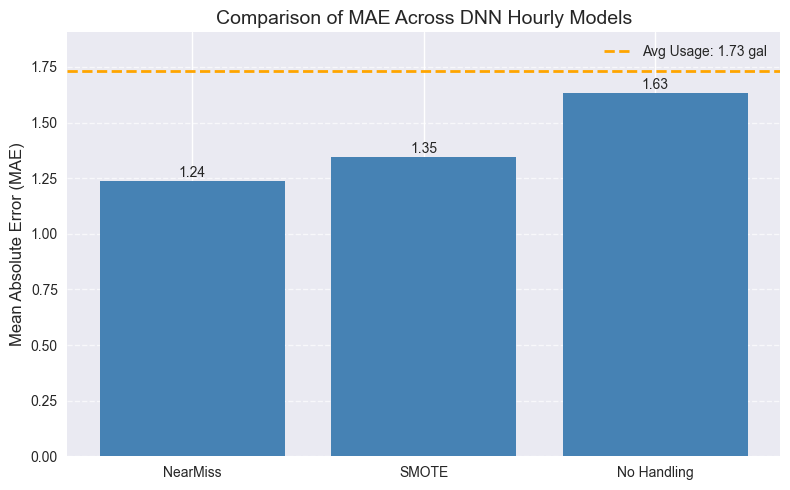

In [167]:
import matplotlib.pyplot as plt

# Your three MAE values
mae_values = [mae_near, mae_smote, mae_wo]
labels = ['NearMiss', 'SMOTE', 'No Handling']

# Compute average water usage
avg_usage = df_processed['Use (gal)'].mean()

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, mae_values, color='steelblue')

# Annotate the bars with MAE values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

# Add horizontal line for average usage
plt.axhline(avg_usage, color='orange', linestyle='--', linewidth=2, label=f'Avg Usage: {avg_usage:.2f} gal')

# Plot aesthetics
plt.title('Comparison of MAE Across DNN Hourly Models', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.ylim(0, max(mae_values + [avg_usage]) + 0.1 * max(mae_values + [avg_usage]))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

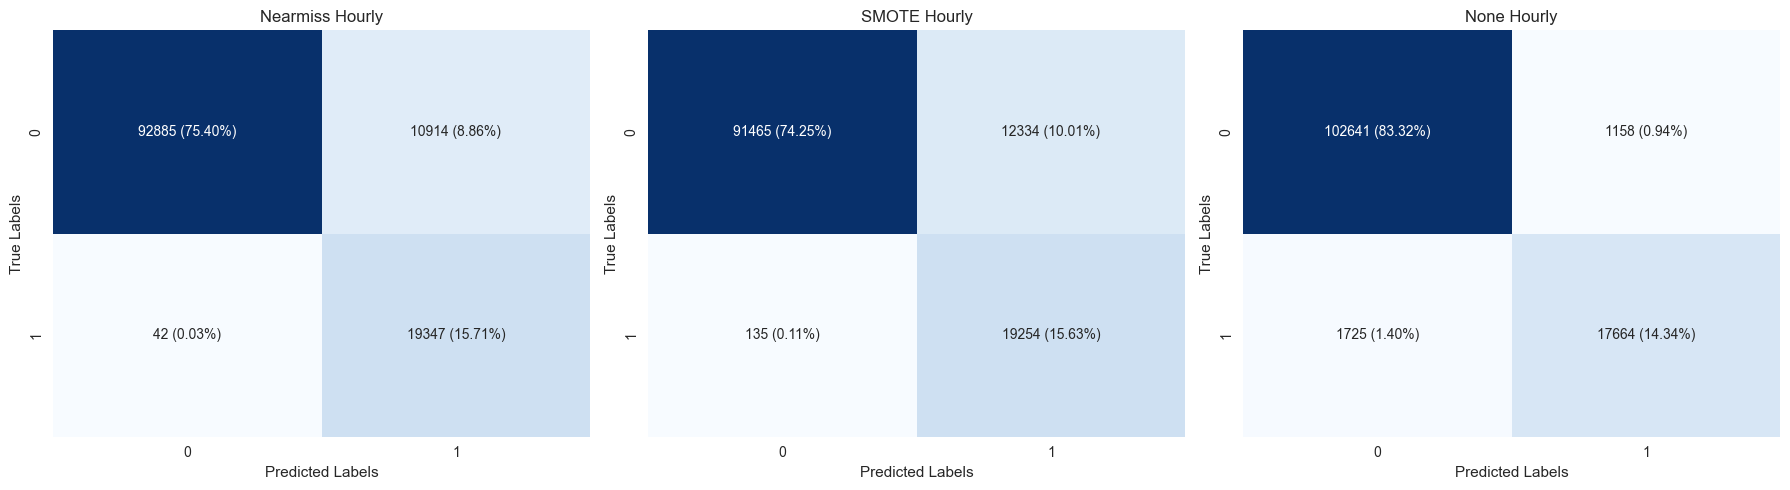

In [172]:

cm_near = np.array([[92885, 10914],
                    [   42, 19347]])

cm_smote = np.array([[91465, 12334],
                     [  135, 19254]])

cm_wo = np.array([[102641,   1158],
                  [  1725,  17664]])

cms = [cm_near, cm_smote, cm_wo]
titles = ["Nearmiss Hourly", "SMOTE Hourly", "None Hourly"]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ax in enumerate(axes):
    cm = cms[i]
    total = np.sum(cm)
    # Create labels with counts and percentages
    labels = np.array([[f"{value} ({value/total:.2%})" for value in row] for row in cm])
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

plt.tight_layout()
plt.show()


# Without NearMiss

In [104]:
def train_model(X_numerical, X_embeddings, y, validation_split=0.2, epochs=100, batch_size=256):
    scaler = StandardScaler()
    X_numerical_scaled = scaler.fit_transform(X_numerical)
    #X_numerical_scaled = StandardScaler().fit_transform(X_numerical)
    
    if X_embeddings:
        X_train = [X_numerical_scaled] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings.keys()]
    else:
        X_train = [X_numerical_scaled]
    
    model = build_model(X_numerical, X_embeddings)
    
    print("Model Architecture:")
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
    ]
    
    print("\nTraining model...")
    history = model.fit(
        X_train, y,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model

indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_num_train, X_num_test = X_numerical.iloc[train_idx], X_numerical.iloc[test_idx]
X_emb_train = {col: X_embeddings[col][train_idx] for col in X_embeddings.keys()}
X_emb_test = {col: X_embeddings[col][test_idx] for col in X_embeddings.keys()}
y_train, y_test = y[train_idx], y[test_idx]

# Train model
print("\n" + "="*50)
print("TRAINING DEEP LEARNING MODEL")
print("="*50)

history = train_model(X_num_train, X_emb_train, y_train, 
                            validation_split=0.2, epochs=50, batch_size=256)
    
# Evaluate on test set
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)
history, model = train_model(X_numerical, X_embeddings, y)



TRAINING DEEP LEARNING MODEL
Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │      2,688 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      8,256 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 13)        │          0 │ Location_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 21)        │          0 │ Unit_Type_embedd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 98)        │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ flatten_8[0][0],  │
│                     │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │     25,344 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     32,896 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 82,808 (323.47 KB)

 Trainable params: 81,784 (319.47 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 38.6827 - mae: 1.2428 - mse: 11.6892 - val_loss: 11.4298 - val_mae: 0.7605 - val_mse: 4.4680 - learning_rate: 0.0010
Epoch 2/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 11.3920 - mae: 0.7881 - mse: 5.6180 - val_loss: 12.8271 - val_mae: 0.9295 - val_mse: 8.6963 - learning_rate: 0.0010
Epoch 3/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 8.4007 - mae: 0.7037 - mse: 4.6525 - val_loss: 12.2125 - val_mae: 0.7313 - val_mse: 8.2480 - learning_rate: 0.0010
Epoch 4/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.3700 - mae: 0.6579 - mse: 3.9237 - val_loss: 8.1781 - val_mae: 0.7718 - val_mse: 5.3791 - learning_rate: 0.0010
Epoch 5/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 6.6834 - mae: 0.6367 - mse: 3.7379 - val_loss: 9.3511 - val_mae: 0.7670 - val_mse: 7.0991 - learning_rate: 0.0010
Epoch 6/50
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 5270s 3s/step - loss: 6.2914 - mae: 0.6097 - ms

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      2,688 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit Type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Location_embedding  │ (None, 1, 13)     │        325 │ Location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Type_embedding │ (None, 1, 21)     │        882 │ Unit              │
│ (Embedding)         │                   │            │ Type_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 13)        │          0 │ Location_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 21)        │          0 │ Unit_Type_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 98)        │          0 │ dense_31[0][0],   │
│ (Concatenate)       │                   │            │ flatten_10[0][0], │
│                     │                   │            │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     25,344 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │     32,896 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_33[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 82,808 (323.47 KB)

 Trainable params: 81,784 (319.47 KB)

 Non-trainable params: 1,024 (4.00 KB)


Training model...
Epoch 1/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 35.6465 - mae: 1.1392 - mse: 10.3978 - val_loss: 12.8290 - val_mae: 0.8383 - val_mse: 7.5818 - learning_rate: 0.0010
Epoch 2/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 9.0857 - mae: 0.6974 - mse: 4.7411 - val_loss: 10.9774 - val_mae: 0.9165 - val_mse: 7.0952 - learning_rate: 0.0010
Epoch 3/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 7.1261 - mae: 0.6340 - mse: 3.8728 - val_loss: 12.1876 - val_mae: 0.8331 - val_mse: 9.2523 - learning_rate: 0.0010
Epoch 4/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 7.7636 - mae: 0.6366 - mse: 4.2717 - val_loss: 7.3061 - val_mae: 0.6963 - val_mse: 4.0829 - learning_rate: 0.0010
Epoch 5/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 6.7623 - mae: 0.5891 - mse: 3.8628 - val_loss: 15.0995 - val_mae: 0.9847 - val_mse: 12.1151 - learning_rate: 0.0010
Epoch 6/100
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 5.7246 - mae: 0.5700

In [105]:
def evaluate_model( X_numerical, X_embeddings, y):
        """
        Evaluate model performance
        """
        # Scale features
        scaler = StandardScaler()
        X_numerical_scaled = scaler.fit_transform(X_numerical)
        
        # Prepare input data
        if X_embeddings:
            X_test = [X_numerical_scaled] + [X_embeddings[col].reshape(-1, 1) for col in X_embeddings.keys()]
        else:
            X_test = [X_numerical_scaled]
        
        # Make predictions
        y_pred = model.predict(X_test).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y - y_pred) / np.maximum(y, 1e-8))) * 100
        
        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape
        }
        
        return metrics, y_pred

test_metrics, y_pred_test = evaluate_model(X_num_test, X_emb_test, y_test)
    
print("\nTest Set Performance:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Evaluate on training set for comparison
train_metrics, y_pred_train = evaluate_model(X_num_train, X_emb_train, y_train)

print("\nTraining Set Performance (for comparison):")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

3850/3850 ━━━━━━━━━━━━━━━━━━━━ 3s 855us/step

Test Set Performance:
MSE: 1.5586
RMSE: 1.2484
MAE: 0.3104
R²: 0.9659
MAPE: 824363555.9824
15399/15399 ━━━━━━━━━━━━━━━━━━━━ 12s 756us/step

Training Set Performance (for comparison):
MSE: 1.5880
RMSE: 1.2602
MAE: 0.3188
R²: 0.9661
MAPE: 817146475.3559


In [106]:
def create_timeseries_data(X_numerical, X_embeddings, y, window_size=24):
    X_num_seq = []
    X_embed_unit_type = []
    y_seq = []

    for i in range(len(y) - window_size):
        X_num_seq.append(X_numerical[i:i+window_size])
        X_embed_unit_type.append(X_embeddings['Unit Type'][i:i+window_size])
        y_seq.append(y[i + window_size])  # predict the next time step

    return (
        np.array(X_num_seq, dtype=np.float32),
        np.array(X_embed_unit_type, dtype=np.int32),
        np.array(y_seq, dtype=np.float32)
    )

X_num_seq, X_unit_type_seq, y_seq = create_timeseries_data(X_numerical, X_embeddings, y)

from sklearn.model_selection import train_test_split

X_num_train, X_num_test, X_unit_train, X_unit_test, y_train, y_test = train_test_split(
    X_num_seq, X_unit_type_seq, y_seq, test_size=0.2, shuffle=False)

X_num_train, X_num_val, X_unit_train, X_unit_val, y_train, y_val = train_test_split(
    X_num_train, X_unit_train, y_train, test_size=0.2, shuffle=False)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate

# Define input shapes
numeric_input = Input(shape=(24, X_num_seq.shape[2]), name='numeric_input')
unit_input = Input(shape=(24,), dtype='int32', name='unit_type_input')

# Embedding for unit type
embedding_layer = Embedding(input_dim=embedding_dims['Unit Type']['vocab_size'],
                            output_dim=embedding_dims['Unit Type']['embedding_dim'],
                            name='unit_embedding')
embedded_unit = embedding_layer(unit_input)  # Shape: (batch, 24, embedding_dim)

# Concatenate numeric + embedding
x = Concatenate(axis=-1)([numeric_input, embedded_unit])
x = LSTM(64)(x)
output = Dense(1)(x)

model = Model(inputs=[numeric_input, unit_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(
    {'numeric_input': X_num_train, 'unit_type_input': X_unit_train},
    y_train,
    validation_data=(
        {'numeric_input': X_num_val, 'unit_type_input': X_unit_val},
        y_val
    ),
    epochs=10,
    batch_size=64
)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict({'numeric_input': X_num_test, 'unit_type_input': X_unit_test})
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ unit_type_input     │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 24, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ unit_embedding      │ (None, 24, 21)    │        882 │ unit_type_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 24, 41)    │          0 │ numeric_input[0]… │
│ (Concatenate)       │                   │            │ unit_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     27,136 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 1)         │         65 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,083 (109.70 KB)

 Trainable params: 28,083 (109.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - loss: 36.0742 - val_loss: 59.8101
Epoch 2/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - loss: 34.3069 - val_loss: 59.8365
Epoch 3/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - loss: 35.9365 - val_loss: 60.0443
Epoch 4/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - loss: 35.8180 - val_loss: 59.9338
Epoch 5/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - loss: 34.6744 - val_loss: 58.0545
Epoch 6/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 4095s 665ms/step - loss: 33.3700 - val_loss: 54.6069
Epoch 7/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - loss: 32.7719 - val_loss: 55.2632
Epoch 8/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 165s 27ms/step - loss: 31.4528 - val_loss: 53.5687
Epoch 9/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 157s 25ms/step - loss: 31.5091 - val_loss: 52.9095
Epoch 10/10
6160/6160 ━━━━━━━━━━━━━━━━━━━━ 203s 26ms/step - loss: 31.5252 - val_loss: 52.3579
3850/3850 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step
MAE: 2.956
RMSE: 7.417
R² Sco